# This notebook contains a project that involves predicting energies of molecules in the ANI dataset.

Molecules in the ANI dataset contain four atom types: hydrogen, carbon, nitrogen and oxygen. In this project, energies of molecules with up to five heavy atoms are predicted using an artificial neural network and then a residual neural network. Molecules are encoded using many-body tensor representation.

In [1]:
import random
import math

import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import SGD, Adam
from sklearn.model_selection import KFold
from tqdm import tqdm
from ase import Atoms
from dscribe.descriptors import MBTR
from IPython.display import Image

from pyanitools import anidataloader

# Unpacking ANI files
In the cells below, molecules are imported and unpacked using anidataloader. Lists of coordinates and energies in each file are created during unpacking.

### Training data
(ani_gdb_s01 - ani_gdb_s04)

In [2]:
# FIRST HDF5 FILE
hdf5file = 'ani_gdb_s01.h5'

# construct the data loader class
ad1 = anidataloader(hdf5file)

# initiate coordinate and energy lists
coords_list01 = []
energy_arr01 = np.array([])
# print the species of the data set one by one
for data in ad1:
#     print(data.keys())

    # extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']

    # print the data
    print("  Symbols:     ", S)
    print("  Coordinates: ", X.shape)
    coords_list01.append(X)
    print("  Energies:    ", E.shape, "\n")
    energy_arr01 = np.hstack((energy_arr01, E))
    
# closes the H5 data file
ad1.cleanup()

  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 

  Symbols:      ['N', 'H', 'H', 'H']
  Coordinates:  (3600, 4, 3)
  Energies:     (3600,) 

  Symbols:      ['O', 'H', 'H']
  Coordinates:  (1800, 3, 3)
  Energies:     (1800,) 



In [3]:
# SECOND HD5 FILE
hdf5file = 'ani_gdb_s02.h5'

# construct the data loader class
ad1 = anidataloader(hdf5file)

# initiate coordinate and energy lists
coords_list02 = []
energy_arr02 = np.array([])
# print the species of the data set one by one
for data in ad1:
#     print(data.keys())

    # extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']

    # print the data
    coords_list02.append(X)
    #print("  Energies:    ", E, "\n")
    energy_arr02 = np.hstack((energy_arr02, E))

# closes the H5 data file
ad1.cleanup()

print(energy_arr02.shape)

(50962,)


In [4]:
# THIRD HD5 FILE
hdf5file = 'ani_gdb_s03.h5'

# construct the data loader class
ad1 = anidataloader(hdf5file)

# initiate coordinate and energy lists
coords_list03 = []
energy_arr03 = np.array([])
# print the species of the data set one by one
for data in ad1:
#     print(data.keys())

    # extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']

    # print the data
    coords_list03.append(X)
    energy_arr03 = np.hstack((energy_arr03, E))

# closes the H5 data file
ad1.cleanup()

print(energy_arr03.shape)

(151200,)


In [5]:
# FOURTH HDF5 FILE
hdf5file = 'ani_gdb_s04.h5'

# construct the data loader class
ad1 = anidataloader(hdf5file)

# initiate coordinate and energy lists
coords_list04 = []
energy_arr04 = np.array([])
# print the species of the data set one by one
for data in ad1:
#     print(data.keys())

    # extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']

    # print the data
    coords_list04.append(X)
    energy_arr04 = np.hstack((energy_arr04, E))

# closes the H5 data file
ad1.cleanup()

print(energy_arr04.shape)

(651936,)


### Test data
ani_gdb_s05

In [6]:
# FIFTH HDF5 FILE
hdf5file = 'ani_gdb_s05.h5'

# construct the data loader class
ad1 = anidataloader(hdf5file)

# initiate coordinate and energy lists
coords_list05 = []
energy_arr05 = np.array([])
# print the species of the data set one by one
for data in ad1:
#     print(data.keys())

    # extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']

    # print the data
    coords_list05.append(X)
    energy_arr05 = np.hstack((energy_arr05, E))

# closes the H5 data file
ad1.cleanup()

print(energy_arr05.shape)

(1813151,)


# Getting coordinates and energies for each compound
Each molecule must be encoded separately. Its coordinates had to be separated in order to be matched with the corresponding molecule formula.

### Training set coordinates lists

In [7]:
# TRAINING SETS
# S01
CH4_coords_list = coords_list01[0]
NH3_coords_list = coords_list01[1]
H2O_coords_list = coords_list01[2]
# S02
C2H6_coords_list = coords_list02[0]
CH3NH2_coords_list = coords_list02[1]
N2_coords_list = coords_list02[2]
NH3O_coords_list = coords_list02[3]
NHO_coords_list = coords_list02[4]
CH3OH_coords_list = coords_list02[5]
C2H4_coords_list = coords_list02[6]
CH2O_coords_list = coords_list02[7]
O2_coords_list = coords_list02[8]
H2O2_coords_list = coords_list02[9]
C2H2_coords_list = coords_list02[10]
N2H4_coords_list = coords_list02[11]
H2N2_coords_list = coords_list02[12]
# S03
C3H8_coords_list = coords_list03[0]
CH3_2_NH_coords_list = coords_list03[1]
H3NCO_coords_list = coords_list03[2]
H2CO2_coords_list = coords_list03[3]
N2CH4_coords_list = coords_list03[4]
ONCH3_coords_list = coords_list03[5]
C3H4_coords_list = coords_list03[6]
C3H6_coords_list = coords_list03[7]
CCNH3_coords_list = coords_list03[8]
C2OH4_coords_list = coords_list03[9]
ONOH_coords_list = coords_list03[10]
H2O3_coords_list = coords_list03[11]
C2H6O_coords_list = coords_list03[12]
C2NH7_coords_list = coords_list03[13]
C2OH6_coords_list = coords_list03[14]
C3H6_coords_list2 = coords_list03[15]
C2OH4_coords_list2 = coords_list03[16]
CO2_coords_list = coords_list03[17]
C2NH3_coords_list = coords_list03[18]
CN2H4_coords_list = coords_list03[19]
# S04
C3NH9_coords_list = coords_list04[0]
C3OH8_coords_list = coords_list04[1]
O3CH2_coords_list = coords_list04[2]
C4H10_coords_list = coords_list04[3]
C3NH9_coords_list2 = coords_list04[4]
C3OH8_coords_list2 = coords_list04[5]
N2C2H8_coords_list = coords_list04[6]
NC2OH7_coords_list = coords_list04[7]
O2C2H6_coords_list = coords_list04[8]
C3NH9_coords_list3 = coords_list04[9]
C3OH8_coords_list3 = coords_list04[10]
C4H8_coords_list = coords_list04[11]
C3NH9_coords_list4 = coords_list04[12]
C3OH6_coords_list = coords_list04[13]
C3NH5_coords_list = coords_list04[14]
NC3H7_coords_list = coords_list04[15]
OC3H6_coords_list = coords_list04[16]
O2C2H4_coords_list = coords_list04[17]
OC2NH3_coords_list = coords_list04[18]
C2N2H6_coords_list = coords_list04[19]
C2NOH5_coords_list = coords_list04[20]
N3CH5_coords_list = coords_list04[22]
N2COH4_coords_list = coords_list04[22]
C4H8_coords_list2 = coords_list04[23]
ON2CH4_coords_list = coords_list04[24]
O2NCH3_coords_list = coords_list04[25]
C2N2H6_coords_list2 = coords_list04[26]
C3OH6_coords_list2 = coords_list04[27]
C2O2H4_coords_list = coords_list04[28]
C2ONH5_coords_list = coords_list04[29]
C4H6_coords_list = coords_list04[30]
NC3H5_coords_list = coords_list04[31]
OC3H4_coords_list = coords_list04[32]
C4H6_coords_list2 = coords_list04[33]
C3OH6_coords_list3 = coords_list04[34]
C3OH4_coords_list = coords_list04[35]
C3NH3_coords_list = coords_list04[36]
O2C2H2_coords_list = coords_list04[37]
OC2NH3_coords_list2 = coords_list04[38]
N2C2H8_coords_list2 = coords_list04[39]
C2N2H4_coords_list = coords_list04[40]
C4H4_coords_list = coords_list04[41]
OC3H2_coords_list = coords_list04[42]
C3NH_coords_list2 = coords_list04[43]
C4H2_coords_list = coords_list04[44]
C2N2H6_coords_list3 = coords_list04[45]
C2N2H6_coords_list4 = coords_list04[46]
C2NOH5_coords_list2 = coords_list04[47]
C4H8_coords_list3 = coords_list04[48]
NC3H7_coords_list2 = coords_list04[49]
OC3H6_coords_list2 = coords_list04[50]
C3NH7_coords_list = coords_list04[51]
C3OH6_coords_list4 = coords_list04[52]
C3NH7_coords_list2 = coords_list04[53]
C2NOH5_coords_list3 = coords_list04[54]
C4H8_coords_list4 = coords_list04[55]
C3NH7_coords_list3 = coords_list04[56]
C3OH6_coords_list5 = coords_list04[57]
C2O2H4_coords_list2 = coords_list04[58]
N3CH5_coords_list2 = coords_list04[59]
N2COH4_coords_list2 = coords_list04[60]

### Test set coordinates lists

In [8]:
# TEST SET
# S05
C4NH11_coords_list = coords_list05[0]
C4OH10_coords_list = coords_list05[1]
C3O2H8_coords_list = coords_list05[2]
C4NH9_coords_list = coords_list05[3]
OC4H6_coords_list = coords_list05[4]
OC3NH5_coords_list = coords_list05[5]
O2C3H4_coords_list = coords_list05[6]
OC3NH5_coords_list2 = coords_list05[7]
O2C3H4_coords_list2 = coords_list05[8]
C5H10_coords_list = coords_list05[9]
C4NH9_coords_list2 = coords_list05[10]
C4OH8_coords_list = coords_list05[11]
N2C3H8_coords_list = coords_list05[12]
C4NH11_coords_list2 = coords_list05[13]
NC3OH7_coords_list = coords_list05[14]
O2C3H6_coords_list = coords_list05[15]
C4NH9_coords_list3 = coords_list05[16]
C4OH8_coords_list2 = coords_list05[17]
C4NH9_coords_list4 = coords_list05[18]
C5H12_coords_list = coords_list05[19]
C4NH11_coords_list3 = coords_list05[20]
C4OH10_coords_list2 = coords_list05[21]
N2C3H10_coords_list = coords_list05[22]
NC3OH9_coords_list = coords_list05[23]
C4OH10_coords_list3 = coords_list05[24]
O2C3H8_coords_list = coords_list05[25]
C4NH11_coords_list4 = coords_list05[26]
C3N2H10_coords_list = coords_list05[27]
C3NOH9_coords_list = coords_list05[28]
C4OH10_coords_list4 = coords_list05[29]
C3ONH9_coords_list = coords_list05[30]
C3O2H8_coords_list = coords_list05[31]
C3O2H8_coords_list2 = coords_list05[32]
C4NH11_coords_list5 = coords_list05[33]
C4OH10_coords_list5 = coords_list05[34]
C4NH11_coords_list6 = coords_list05[35]
C5H10_coords_list2 = coords_list05[36]
C4OH8_coords_list3 = coords_list05[37]
C4NH7_coords_list = coords_list05[38]
NC4H9_coords_list = coords_list05[39]
OC4H8_coords_list = coords_list05[40]
O2C3H6_coords_list2 = coords_list05[41]
OC3NH5_coords_list3 = coords_list05[42]
C4NH9_coords_list5 = coords_list05[43]
C3NOH7_coords_list = coords_list05[44]
C3N2H6_coords_list = coords_list05[45]
C5H10_coords_list3 = coords_list05[46]
C4OH8_coords_list4 = coords_list05[47]
C3O2H6_coords_list = coords_list05[48]
C3ONH5_coords_list = coords_list05[49]
C3N2H8_coords_list = coords_list05[50]
C3NOH7_coords_list2 = coords_list05[51]
C3N2H8_coords_list2 = coords_list05[52]
C2N3H7_coords_list = coords_list05[53]
C2N2OH6_coords_list = coords_list05[54]
C2ON2H6_coords_list = coords_list05[55]
C2O2NH5_coords_list = coords_list05[56]
C4OH8_coords_list5 = coords_list05[57]
C4OH8_coords_list6 = coords_list05[58]
C3O2H6_coords_list2 = coords_list05[59]
C3ONH7_coords_list = coords_list05[60]
C5H8_coords_list = coords_list05[61]
NC4H7_coords_list = coords_list05[62]
OC4H6_coords_list2 = coords_list05[63]
C4NH7_coords_list2 = coords_list05[64]
C4OH6_coords_list = coords_list05[65]
C5H8_coords_list2 = coords_list05[66]
C4OH6_coords_list2 = coords_list05[67]
C4NH7_coords_list3 = coords_list05[68]
C4NH5_coords_list = coords_list05[69]
O2C3H4_coords_list3 = coords_list05[70]
OC3NH3_coords_list = coords_list05[71]
N2C3H2_coords_list = coords_list05[72]
C3N2H6_coords_list2 = coords_list05[73]
C3NOH5_coords_list = coords_list05[74]
N3C2H5_coords_list = coords_list05[75]
N2C2OH4_coords_list = coords_list05[76]
O2C2NH3_coords_list = coords_list05[77]
C2N3H5_coords_list = coords_list05[78]
C4NH9_coords_list6 = coords_list05[79]
C2N2OH4_coords_list = coords_list05[80]
C4OH6_coords_list3 = coords_list05[81]
C3O2H4_coords_list = coords_list05[82]
C2NO2H3_coords_list = coords_list05[83] 
C5H6_coords_list = coords_list05[84]
#C4NH3_coords_list = coords_list05[85] # formula and coordinates did not match
C5H4_coords_list = coords_list05[86]
C5H10_coords_list4 = coords_list05[87]
C4NH9_coords_list7 = coords_list05[88]
C4OH8_coords_list7 = coords_list05[89]
C4OH8_coords_list8 = coords_list05[90]
C3N2H8_coords_list3 = coords_list05[91]
C3NOH7_coords_list3 = coords_list05[92]
N2C2OH6_coords_list = coords_list05[93]
N2C2OH6_coords_list2 = coords_list05[94]
O2C2NH5_coords_list = coords_list05[95]
C3N2H8_coords_list4 = coords_list05[96]
C2N3H7_coords_list2 = coords_list05[97]
C2N2OH6_coords_list = coords_list05[98]
N4CH6_coords_list = coords_list05[99]
C3O2H6_coords_list3 = coords_list05[100]
N3COH5_coords_list = coords_list05[101]
O2N2CH4_coords_list = coords_list05[102]
C4OH8_coords_list9 = coords_list05[103]
C2ON2H6_coords_list2 = coords_list05[104]
C2O2NH5_coords_list2 = coords_list05[105]
C3N2H8_coords_list5 = coords_list05[106]
C3ONH7_coords_list2 = coords_list05[107]
C5H8_coords_list3 = coords_list05[108]
C4OH6_coords_list4 = coords_list05[109]
C4NH5_coords_list2 = coords_list05[110]
C5H12_coords_list2 = coords_list05[111]
C3ONH5_coords_list2 = coords_list05[112]
NC3OH5_coords_list = coords_list05[113]
N2C3H4_coords_list = coords_list05[114]
N2C3H6_coords_list = coords_list05[115]
ONC3H5_coords_list = coords_list05[116]
O2NC2H3_coords_list = coords_list05[117]
ON2C2H2_coords_list = coords_list05[118]
C3N2H6_coords_list3 = coords_list05[119]
C5H6_coords_list2 = coords_list05[120]
N2C3H4_coords_list2 = coords_list05[121]
ONC3H3_coords_list = coords_list05[122]
C3N2H8_coords_list6 = coords_list05[123]
C5H8_coords_list4 = coords_list05[124]
C4NH7_coords_list4 = coords_list05[125]
C4OH6_coords_list5 = coords_list05[126]
C4NH3_coords_list = coords_list05[127] 
C5H4_coords_list = coords_list05[128]
C5H10_coords_list5 = coords_list05[129]
NC4H9_coords_list2 = coords_list05[130]
OC4H8_coords_list2 = coords_list05[131]
C3NOH7_coords_list4 = coords_list05[132]
C4NH9_coords_list8 = coords_list05[133]
C4OH8_coords_list10 = coords_list05[134]
N2C3H8_coords_list2 = coords_list05[135]
OC3NH7_coords_list = coords_list05[137]
C4OH8_coords_list11 = coords_list05[138]
NC3OH7_coords_list2 = coords_list05[139]
O2C3H6_coords_list3 = coords_list05[140]
C4NH9_coords_list9 = coords_list05[141]
C5H8_coords_list5 = coords_list05[142]
C2N3H7_coords_list3 = coords_list05[143]
OC4H6_coords_list3 = coords_list05[144]
NC4H5_coords_list = coords_list05[145]
C4NH7_coords_list5 = coords_list05[146]
OC3NH5_coords_list4 = coords_list05[147]
N2C3H4_coords_list3 = coords_list05[148]
C4OH6_coords_list7 = coords_list05[149]
O2C3H4_coords_list4 = coords_list05[150]
NC3OH3_coords_list = coords_list05[151]
N2C3H6_coords_list2 = coords_list05[152]
OC3NH5_coords_list5 = coords_list05[153]
C2N2OH6_coords_list2 = coords_list05[154]
C3N2H6_coords_list4 = coords_list05[155]
C5H6_coords_list3 = coords_list05[156]
C4NH5_coords_list3 = coords_list05[157]
C4OH4_coords_list = coords_list05[158]
C4NH9_coords_list10 = coords_list05[159]
C4OH8_coords_list12 = coords_list05[160]
C3O2H6_coords_list4 = coords_list05[161]
C5H8_coords_list6 = coords_list05[162]
C3N2H6_coords_list5 = coords_list05[163]
C2N2OH6_coords_list3 = coords_list05[164]
C3N2H6_coords_list4 = coords_list05[165]
C4OH6_coords_list8 = coords_list05[166]
C3NOH5_coords_list2 = coords_list05[167]
C3O2H4_coords_list2 = coords_list05[168]
C2O2NH3_coords_list = coords_list05[169]
C4NH7_coords_list6 = coords_list05[170]
C4OH6_coords_list9 = coords_list05[171]
C5H6_coords_list4 = coords_list05[172]
C3N2H4_coords_list = coords_list05[173]
C4NH5_coords_list4 = coords_list05[174]
C2NO2H5_coords_list = coords_list05[175]
C3N2H4_coords_list2 = coords_list05[176]
C2N3H3_coords_list = coords_list05[177]
C3N2H4_coords_list3 = coords_list05[178]
C2N3H3_coords_list2 = coords_list05[179]
CN4H2_coords_list = coords_list05[180]
CN4H2_coords_list2 = coords_list05[181]
C4OH4_coords_list2 = coords_list05[182]
C3ONH3_coords_list = coords_list05[183]
C2N2OH2_coords_list = coords_list05[184]
C3NOH3_coords_list = coords_list05[185]
C3N2H8_coords_list7 = coords_list05[186]
C2ON2H2_coords_list = coords_list05[187]
C2N2OH2_coords_list2 = coords_list05[188]
CN3OH_coords_list = coords_list05[189]
C2N2OH2_coords_list3 = coords_list05[190]
CN3OH_coords_list2 = coords_list05[191]
C5H8_coords_list7 = coords_list05[192]
C4NH7_coords_list7 = coords_list05[193]
C4NH11_coords_list7 = coords_list05[194]
C4OH6_coords_list10 = coords_list05[195]
C5H10_coords_list6 = coords_list05[196]
C4NH9_coords_list11 = coords_list05[197]
C4OH8_coords_list13 = coords_list05[198]
C4OH8_coords_list14 = coords_list05[199]
C3O2H6_coords_list5 = coords_list05[200]
C3N2H8_coords_list8 = coords_list05[201]
N3C2H7_coords_list = coords_list05[202]
C4OH10_coords_list6 = coords_list05[203]
C3O2H6_coords_list6 = coords_list05[204]
NC2O2H5_coords_list = coords_list05[205]
O3C2H4_coords_list = coords_list05[206]
C3N2H8_coords_list9 = coords_list05[207]
C2N3H7_coords_list4 = coords_list05[208]
C2N2OH6_coords_list4 = coords_list05[209]
C3NOH7_coords_list5 = coords_list05[210]
C2ON2H6_coords_list3 = coords_list05[211]
C4NH11_coords_list8 = coords_list05[212]
C2O2NH5_coords_list3 = coords_list05[213]
C2N3H7_coords_list5 = coords_list05[214]
N4CH6_coords_list2 = coords_list05[215]
N3COH5_coords_list2 = coords_list05[216]
C2N2OH6_coords_list5 = coords_list05[217]
N3COH5_coords_list3 = coords_list05[218]
N2CO2H4_coords_list = coords_list05[219]
C4OH8_coords_list15 = coords_list05[220]
C3O2H6_coords_list7 = coords_list05[221]
C2ON2H6_coords_list4 = coords_list05[222]
C3N2H10_coords_list2 = coords_list05[223]
C2O2NH5_coords_list4 = coords_list05[224]
C5H8_coords_list8 = coords_list05[225]
C4OH6_coords_list11 = coords_list05[226]
C4NH5_coords_list5 = coords_list05[227]
C4OH6_coords_list12 = coords_list05[228]
C3O2H4_coords_list3 = coords_list05[229]
C3ONH3_coords_list2 = coords_list05[230]
N2C3H6_coords_list3 = coords_list05[231]
N2C2OH4_coords_list2 = coords_list05[232]
N3C2H3_coords_list = coords_list05[233]
C3NOH9_coords_list2 = coords_list05[234]
NC3OH5_coords_list2 = coords_list05[235]
NC2O2H3_coords_list = coords_list05[236]
N2C2OH2_coords_list = coords_list05[237]
O2C3H4_coords_list5 = coords_list05[238]
O3C2H2_coords_list = coords_list05[239]
O2C2NH_coords_list = coords_list05[240]
C5H6_coords_list5 = coords_list05[241]
C4OH4_coords_list3 = coords_list05[242]
N2C3H4_coords_list4 = coords_list05[243]
NC3OH3_coords_list2 = coords_list05[244]
C4OH10_coords_list7 = coords_list05[245]
O2C3H2_coords_list = coords_list05[246]
C5H10_coords_list7 = coords_list05[247]
C3N2H8_coords_list10 = coords_list05[248]
C3NOH7_coords_list6 = coords_list05[249]
C5H10_coords_list8 = coords_list05[250]
C4NH9_coords_list12 = coords_list05[251]
C4OH8_coords_list16 = coords_list05[252]
C4NH9_coords_list13 = coords_list05[253]
C4OH8_coords_list17 = coords_list05[254]
C5H10_coords_list9 = coords_list05[255]
C3ONH9_coords_list2 = coords_list05[256]
NC4H9_coords_list3 = coords_list05[257]
OC4H8_coords_list3 = coords_list05[258]
C4NH9_coords_list14 = coords_list05[259]
N2C3H8_coords_list3 = coords_list05[260]
OC3NH7_coords_list2 = coords_list05[261]
C4OH8_coords_list18 = coords_list05[262]
NC3OH7_coords_list3 = coords_list05[263]
O2C3H6_coords_list4 = coords_list05[264]
C4NH9_coords_list15 = coords_list05[265]
C4OH8_coords_list19 = coords_list05[266]

### Energies arrays can be np stacked; no need to separate these

In [9]:
# Training set energies
training_energies = np.hstack((energy_arr01, energy_arr02, energy_arr03, energy_arr04))

# Test set energies
ani5_energies = np.hstack((energy_arr05))

# The molecule representation being used is called many body tensor representation (MBTR) from the DScribe package.
MBTR encodes a structure by using a distribution of different structural motifs. Molecules must first be turned into atom objects (using the Atom builder from ASE package) and then encoded with MBTR. MBTR creates a numpy array of length 1000 to represent each molecule.


## Instantiate MBTR with parameters

In [10]:
# INSTANTIATE MBTR. Comments here are from documentation
mbtr = MBTR(
    species=['H', 'C', 'O', 'N'],
   # "Notice that [species] is not the atomic numbers that are present for an individual system,
   # but should contain all the elements that are ever going to be encountered when creating
   # the descriptors for a set of systems."
    geometry = {"function": "distance"}, # pairwise distance in angstroms
    grid = {"min": 0, "max": 1, "n": 100, "sigma": 0.1}, # grid on which functions are computed
    weighting = {"function": "unity", "scale": 0.5, "threshold": 1e-3}, # using unity (no weighting) for now just for dry run
    periodic = False,
    normalization = "l2", # none, l2, num_atoms or valle_oganov
)

### Creating ASE Atoms of all molecules

In [11]:
# TRAINING MOLECULES
# S01
CH4_atoms = []
for i, CH4_coords in enumerate(CH4_coords_list):
    CH4_coord = Atoms(
        symbols = ["C", "H", "H", "H", "H"],
        positions = CH4_coords
    )
    CH4_atoms.append(CH4_coord)

NH3_atoms = []
for i, NH3_coords in enumerate(NH3_coords_list):
    NH3_coord = Atoms(
        symbols = ["N", "H", "H", "H"],
        positions = NH3_coords
    )
    NH3_atoms.append(NH3_coord)

H2O_atoms = []
for i, H2O_coords in enumerate(H2O_coords_list):
    H2O_coord = Atoms(
        symbols = ["O", "H", "H"],
        positions = H2O_coords
    )
    H2O_atoms.append(H2O_coord)

# S02
C2H6_atoms = []
for i, C2H6_coords in enumerate(C2H6_coords_list):
    C2H6_coord = Atoms(
        symbols = ['C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2H6_coords)
    C2H6_atoms.append(C2H6_coord)

CH3NH2_atoms = []
for i, CH3NH2_coords in enumerate(CH3NH2_coords_list):
    CH3NH2_coord = Atoms(
        symbols = ['C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = CH3NH2_coords)
    CH3NH2_atoms.append(CH3NH2_coord)

N2_atoms = []
for i, N2_coords in enumerate(N2_coords_list):
    N2_coord = Atoms(
        symbols = ['N', 'N'],
        positions = N2_coords)
    N2_atoms.append(N2_coord)

NH3O_atoms = []
for i, NH3O_coords in enumerate(NH3O_coords_list):
    NH3O_coord = Atoms(
        symbols = ['O', 'N', 'H', 'H', 'H'],
        positions = NH3O_coords)
    NH3O_atoms.append(NH3O_coord)

NHO_atoms = []
for i, NHO_coords in enumerate(NHO_coords_list):
    NHO_coord = Atoms(
        symbols = ['O', 'N', 'H'],
        positions = NHO_coords)
    NHO_atoms.append(NHO_coord)

CH3OH_atoms = []
for i, CH3OH_coords in enumerate(CH3OH_coords_list):
    CH3OH_coord = Atoms(
        symbols = ['C', 'O', 'H', 'H', 'H', 'H'],
        positions = CH3OH_coords)
    CH3OH_atoms.append(CH3OH_coord)

C2H4_atoms = []
for i, C2H4_coords in enumerate(C2H4_coords_list):
    C2H4_coord = Atoms(
        symbols = ['C', 'C', 'H', 'H', 'H', 'H'],
        positions = C2H4_coords)
    C2H4_atoms.append(C2H4_coord)

CH2O_atoms = []
for i, CH2O_coords in enumerate(CH2O_coords_list):
    CH2O_coord = Atoms(
        symbols = ['C', 'O', 'H', 'H'],
        positions = CH2O_coords)
    CH2O_atoms.append(CH2O_coord)

O2_atoms = []
for i, O2_coords in enumerate(O2_coords_list):
    O2_coord = Atoms(
        symbols = ['O', 'O'],
        positions = O2_coords)
    O2_atoms.append(O2_coord)

H2O2_atoms = []
for i, H2O2_coords in enumerate(H2O2_coords_list):
    H2O2_coord = Atoms(
        symbols = ['O', 'O', 'H', 'H'],
        positions = H2O2_coords)
    H2O2_atoms.append(H2O2_coord)

C2H2_atoms = []
for i, C2H2_coords in enumerate(C2H2_coords_list):
    C2H2_coord = Atoms(
        symbols = ['C', 'C', 'H', 'H'],
        positions = C2H2_coords)
    C2H2_atoms.append(C2H2_coord)

N2H4_atoms = []
for i, N2H4_coords in enumerate(N2H4_coords_list):
    N2H4_coord = Atoms(
        symbols = ['N', 'N', 'H', 'H', 'H', 'H'],
        positions = N2H4_coords)
    N2H4_atoms.append(N2H4_coord)

H2N2_atoms = []
for i, H2N2_coords in enumerate(H2N2_coords_list):
    H2N2_coord = Atoms(
        symbols = ['N', 'N', 'H', 'H'],
        positions = H2N2_coords)
    H2N2_atoms.append(H2N2_coord)

# S03
C3H8_atoms = []
for i, C3H8_coords in enumerate(C3H8_coords_list):
    C3H8_coord = Atoms(
        symbols = ['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3H8_coords)
    C3H8_atoms.append(C3H8_coord)

CH3_2_NH_atoms = []
for i, CH3_2_NH_coords in enumerate(CH3_2_NH_coords_list):
    CH3_2_NH_coord = Atoms(
        symbols = ['C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = CH3_2_NH_coords)
    CH3_2_NH_atoms.append(CH3_2_NH_coord)

H3NCO_atoms = []
for i, H3NCO_coords in enumerate(H3NCO_coords_list):
    H3NCO_coord = Atoms(
        symbols = ['N', 'C', 'O', 'H', 'H', 'H'],
        positions = H3NCO_coords)
    H3NCO_atoms.append(H3NCO_coord)

H2CO2_atoms = []
for i, H2CO2_coords in enumerate(H2CO2_coords_list):
    H2CO2_coord = Atoms(
        symbols = ['O', 'C', 'O', 'H', 'H'],
        positions = H2CO2_coords)
    H2CO2_atoms.append(H2CO2_coord)

N2CH4_atoms = []
for i, N2CH4_coords in enumerate(N2CH4_coords_list):
    N2CH4_coord = Atoms(
        symbols = ['N', 'N', 'C', 'H', 'H', 'H', 'H'],
        positions = N2CH4_coords)
    N2CH4_atoms.append(N2CH4_coord)

ONCH3_atoms = []
for i, ONCH3_coords in enumerate(ONCH3_coords_list):
    ONCH3_coord = Atoms(
        symbols = ['O', 'N', 'C', 'H', 'H', 'H'],
        positions = ONCH3_coords)
    ONCH3_atoms.append(ONCH3_coord)

C3H4_atoms = []
for i, C3H4_coords in enumerate(C3H4_coords_list):
    C3H4_coord = Atoms(
        symbols = ['C', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = C3H4_coords)
    C3H4_atoms.append(C3H4_coord)

C3H6_atoms = []
for i, C3H6_coords in enumerate(C3H6_coords_list):
    C3H6_coord = Atoms(
        symbols = ['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3H6_coords)
    C3H6_atoms.append(C3H6_coord)

CCNH3_atoms = []
for i, CCNH3_coords in enumerate(CCNH3_coords_list):
    CCNH3_coord = Atoms(
        symbols = ['C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = CCNH3_coords)
    CCNH3_atoms.append(CCNH3_coord)

C2OH4_atoms = []
for i, C2OH4_coords in enumerate(C2OH4_coords_list):
    C2OH4_coord = Atoms(
        symbols = ['C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C2OH4_coords)
    C2OH4_atoms.append(C2OH4_coord)

ONOH_atoms = []
for i, ONOH_coords in enumerate(ONOH_coords_list):
    ONOH_coord = Atoms(
        symbols = ['O', 'N', 'O', 'H'],
        positions = ONOH_coords)
    ONOH_atoms.append(ONOH_coord)

H2O3_atoms = []
for i, H2O3_coords in enumerate(H2O3_coords_list):
    H2O3_coord = Atoms(
        symbols = ['O', 'O', 'O', 'H', 'H'],
        positions = H2O3_coords)
    H2O3_atoms.append(H2O3_coord)

C2H6O_atoms = []
for i, C2H6O_coords in enumerate(C2H6O_coords_list):
    C2H6O_coord = Atoms(
        symbols = ['C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2H6O_coords)
    C2H6O_atoms.append(C2H6O_coord)

C2NH7_atoms = []
for i, C2NH7_coords in enumerate(C2NH7_coords_list):
    C2NH7_coord = Atoms(
        symbols = ['C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2NH7_coords)
    C2NH7_atoms.append(C2NH7_coord)

C2OH6_atoms = []
for i, C2OH6_coords in enumerate(C2OH6_coords_list):
    C2OH6_coord = Atoms(
        symbols = ['C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2OH6_coords)
    C2OH6_atoms.append(C2OH6_coord)

C3H6_atoms = []
for i, C3H6_coords in enumerate(C3H6_coords_list):
    C3H6_coord = Atoms(
        symbols = ['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3H6_coords)
    C3H6_atoms.append(C3H6_coord)

C2OH4_atoms2 = []
for i, C2OH4_coords2 in enumerate(C2OH4_coords_list2):
    C2OH4_coord2 = Atoms(
        symbols = ['C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C2OH4_coords2)
    C2OH4_atoms2.append(C2OH4_coord2)

CO2_atoms = []
for i, CO2_coords in enumerate(CO2_coords_list):
    CO2_coord = Atoms(
        symbols = ['O', 'C', 'O'],
        positions = CO2_coords)
    CO2_atoms.append(CO2_coord)

C2NH3_atoms = []
for i, C2NH3_coords in enumerate(C2NH3_coords_list):
    C2NH3_coord = Atoms(
        symbols = ['C', 'C', 'N', 'H', 'H', 'H'],
        positions = C2NH3_coords)
    C2NH3_atoms.append(C2NH3_coord)

CN2H4_atoms = []
for i, CN2H4_coords in enumerate(CN2H4_coords_list):
    CN2H4_coord = Atoms(
        symbols =  ['N', 'C', 'N', 'H', 'H', 'H', 'H'],
        positions = CN2H4_coords)
    CN2H4_atoms.append(CN2H4_coord)

# S04
C3NH9_atoms = []
for i, C3NH9_coords in enumerate(C3NH9_coords_list):
    C3NH9_coord = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NH9_coords)
    C3NH9_atoms.append(C3NH9_coord)

C3OH8_atoms = []
for i, C3OH8_coords in enumerate(C3OH8_coords_list):
    C3OH8_coord = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3OH8_coords)
    C3OH8_atoms.append(C3OH8_coord)

O3CH2_atoms = []
for i, O3CH2_coords in enumerate(O3CH2_coords_list):
    O3CH2_coord = Atoms(
        symbols = ['O', 'C', 'O', 'O', 'H', 'H'],
        positions = O3CH2_coords)
    O3CH2_atoms.append(O3CH2_coord)

C4H10_atoms = []
for i, C4H10_coords in enumerate(C4H10_coords_list):
    C4H10_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4H10_coords)
    C4H10_atoms.append(C4H10_coord)

C3NH9_atoms2 = []
for i, C3NH9_coords2 in enumerate(C3NH9_coords_list2):
    C3NH9_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NH9_coords2)
    C3NH9_atoms2.append(C3NH9_coord2)

C3OH8_atoms2 = []
for i, C3OH8_coords2 in enumerate(C3OH8_coords_list2):
    C3OH8_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3OH8_coords2)
    C3OH8_atoms2.append(C3OH8_coord2)

N2C2H8_atoms = []
for i, N2C2H8_coords in enumerate(N2C2H8_coords_list):
    N2C2H8_coord = Atoms(
        symbols = ['N', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C2H8_coords)
    N2C2H8_atoms.append(N2C2H8_coord)

NC2OH7_atoms = []
for i, NC2OH7_coords in enumerate(NC2OH7_coords_list):
    NC2OH7_coord = Atoms(
        symbols = ['N', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC2OH7_coords)
    NC2OH7_atoms.append(NC2OH7_coord)

O2C2H6_atoms = []
for i, O2C2H6_coords in enumerate(O2C2H6_coords_list):
    O2C2H6_coord = Atoms(
        symbols = ['O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = O2C2H6_coords)
    O2C2H6_atoms.append(O2C2H6_coord)

C3NH9_atoms3 = []
for i, C3NH9_coords3 in enumerate(C3NH9_coords_list3):
    C3NH9_coord3 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NH9_coords3)
    C3NH9_atoms3.append(C3NH9_coord3)

C3OH8_atoms3 = []
for i, C3OH8_coords3 in enumerate(C3OH8_coords_list3):
    C3OH8_coord3 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3OH8_coords3)
    C3OH8_atoms3.append(C3OH8_coord3)

C4H8_atoms = []
for i, C4H8_coords in enumerate(C4H8_coords_list):
    C4H8_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4H8_coords)
    C4H8_atoms.append(C4H8_coord)

C3NH9_atoms4 = []
for i, C3NH9_coords4 in enumerate(C3NH9_coords_list4):
    C3NH9_coord4 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NH9_coords4)
    C3NH9_atoms4.append(C3NH9_coord4)

C3OH6_atoms = []
for i, C3OH6_coords in enumerate(C3OH6_coords_list):
    C3OH6_coord = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3OH6_coords)
    C3OH6_atoms.append(C3OH6_coord)

C3NH5_atoms = []
for i, C3NH5_coords in enumerate(C3NH5_coords_list):
    C3NH5_coord = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NH5_coords)
    C3NH5_atoms.append(C3NH5_coord)

NC3H7_atoms = []
for i, NC3H7_coords in enumerate(NC3H7_coords_list):
    NC3H7_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3H7_coords)
    NC3H7_atoms.append(NC3H7_coord)

OC3H6_atoms = []
for i, OC3H6_coords in enumerate(OC3H6_coords_list):
    OC3H6_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3H6_coords)
    OC3H6_atoms.append(OC3H6_coord)

O2C2H4_atoms = []
for i, O2C2H4_coords in enumerate(O2C2H4_coords_list):
    O2C2H4_coord = Atoms(
        symbols = ['O', 'C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = O2C2H4_coords)
    O2C2H4_atoms.append(O2C2H4_coord)

OC2NH3_atoms = []
for i, OC2NH3_coords in enumerate(OC2NH3_coords_list):
    OC2NH3_coord = Atoms(
        symbols = ['O', 'C', 'C', 'N', 'H', 'H', 'H'],
        positions = OC2NH3_coords)
    OC2NH3_atoms.append(OC2NH3_coord)

C2N2H6_atoms = []
for i, C2N2H6_coords in enumerate(C2N2H6_coords_list):
    C2N2H6_coord = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2H6_coords)
    C2N2H6_atoms.append(C2N2H6_coord)

C2NOH5_atoms = []
for i, C2NOH5_coords in enumerate(C2NOH5_coords_list):
    C2NOH5_coord = Atoms(
        symbols = ['N', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C2NOH5_coords)
    C2NOH5_atoms.append(C2NOH5_coord)

N3CH5_atoms = []
for i, N3CH5_coords in enumerate(N3CH5_coords_list):
    N3CH5_coord = Atoms(
        symbols = ['N', 'N', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = N3CH5_coords)
    N3CH5_atoms.append(N3CH5_coord)

C4H8_atoms2 = []
for i, C4H8_coords2 in enumerate(C4H8_coords_list2):
    C4H8_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4H8_coords2)
    C4H8_atoms2.append(C4H8_coord2)

N2COH4_atoms = []
for i, N2COH4_coords in enumerate(N2COH4_coords_list):
    N2COH4_coord = Atoms(
        symbols = ['O', 'N', 'C', 'N', 'H', 'H', 'H', 'H'],
        positions = N2COH4_coords)
    N2COH4_atoms.append(N2COH4_coord)

ON2CH4_atoms = []
for i, ON2CH4_coords in enumerate(ON2CH4_coords_list):
    ON2CH4_coord = Atoms(
        symbols = ['O', 'N', 'C', 'N', 'H', 'H', 'H', 'H'],
        positions = ON2CH4_coords)
    ON2CH4_atoms.append(ON2CH4_coord)

O2NCH3_atoms = []
for i, O2NCH3_coords in enumerate(O2NCH3_coords_list):
    O2NCH3_coord = Atoms(
        symbols = ['O', 'N', 'C', 'O', 'H', 'H', 'H'],
        positions = O2NCH3_coords)
    O2NCH3_atoms.append(O2NCH3_coord)

C2N2H6_atoms2 = []
for i, C2N2H6_coords2 in enumerate(C2N2H6_coords_list2):
    C2N2H6_coord2 = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2H6_coords2)
    C2N2H6_atoms2.append(C2N2H6_coord2)

C3OH6_atoms2 = []
for i, C3OH6_coords2 in enumerate(C3OH6_coords_list2):
    C3OH6_coord2 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3OH6_coords2)
    C3OH6_atoms2.append(C3OH6_coord2)

C2O2H4_atoms = []
for i, C2O2H4_coords in enumerate(C2O2H4_coords_list):
    C2O2H4_coord = Atoms(
        symbols = ['C', 'O', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C2O2H4_coords)
    C2O2H4_atoms.append(C2O2H4_coord)

C2ONH5_atoms = []
for i, C2ONH5_coords in enumerate(C2ONH5_coords_list):
    C2ONH5_coord = Atoms(
        symbols = ['C', 'O', 'N', 'C', 'H', 'H', 'H', 'H', 'H'],
        positions = C2ONH5_coords)
    C2ONH5_atoms.append(C2ONH5_coord)

C4H6_atoms = []
for i, C4H6_coords in enumerate(C4H6_coords_list):
    C4H6_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4H6_coords)
    C4H6_atoms.append(C4H6_coord)

NC3H5_atoms = []
for i, NC3H5_coords in enumerate(NC3H5_coords_list):
    NC3H5_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3H5_coords)
    NC3H5_atoms.append(NC3H5_coord)

OC3H4_atoms = []
for i, OC3H4_coords in enumerate(OC3H4_coords_list):
    OC3H4_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = OC3H4_coords)
    OC3H4_atoms.append(OC3H4_coord)

C4H6_atoms2 = []
for i, C4H6_coords2 in enumerate(C4H6_coords_list2):
    C4H6_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4H6_coords2)
    C4H6_atoms2.append(C4H6_coord2)

C3OH6_atoms3 = []
for i, C3OH6_coords3 in enumerate(C3OH6_coords_list3):
    C3OH6_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3OH6_coords3)
    C3OH6_atoms3.append(C3OH6_coord3)

C3OH4_atoms = []
for i, C3OH4_coords in enumerate(C3OH4_coords_list):
    C3OH4_coord = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C3OH4_coords)
    C3OH4_atoms.append(C3OH4_coord)

C3NH3_atoms = []
for i, C3NH3_coords in enumerate(C3NH3_coords_list):
    C3NH3_coord = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'H', 'H', 'H'],
        positions = C3NH3_coords)
    C3NH3_atoms.append(C3NH3_coord)

O2C2H2_atoms = []
for i, O2C2H2_coords in enumerate(O2C2H2_coords_list):
    O2C2H2_coord = Atoms(
        symbols = ['O', 'C', 'C', 'O', 'H', 'H'],
        positions = O2C2H2_coords)
    O2C2H2_atoms.append(O2C2H2_coord)

OC2NH3_atoms2 = []
for i, OC2NH3_coords2 in enumerate(OC2NH3_coords_list2):
    OC2NH3_coord2 = Atoms(
        symbols = ['O', 'C', 'C', 'N', 'H'],
        positions = OC2NH3_coords2)
    OC2NH3_atoms2.append(OC2NH3_coord2)

N2C2H8_atoms2 = []
for i, N2C2H8_coords2 in enumerate(N2C2H8_coords_list2):
    N2C2H8_coord2 = Atoms(
        symbols = ['N', 'C', 'C', 'N'],
        positions = N2C2H8_coords2)
    N2C2H8_atoms2.append(N2C2H8_coord2)

C2N2H4_atoms = []
for i, C2N2H4_coords in enumerate(C2N2H4_coords_list):
    C2N2H4_coord = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'H', 'H', 'H', 'H'],
        positions = C2N2H4_coords)
    C2N2H4_atoms.append(C2N2H4_coord)

C4H4_atoms = []
for i, C4H4_coords in enumerate(C4H4_coords_list):
    C4H4_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = C4H4_coords)
    C4H4_atoms.append(C4H4_coord)

OC3H2_atoms = []
for i, OC3H2_coords in enumerate(OC3H2_coords_list):
    OC3H2_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'H', 'H'],
        positions = OC3H2_coords)
    OC3H2_atoms.append(OC3H2_coord)

C3NH_atoms2 = []
for i, C3NH_coords2 in enumerate(C3NH_coords_list2):
    C3NH_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'H'],
        positions = C3NH_coords2)
    C3NH_atoms2.append(C3NH_coord2)

C4H2_atoms = []
for i, C4H2_coords in enumerate(C4H2_coords_list):
    C4H2_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H'],
        positions = C4H2_coords)
    C4H2_atoms.append(C4H2_coord)

C2N2H6_atoms3 = []
for i, C2N2H6_coords3 in enumerate(C2N2H6_coords_list3):
    C2N2H6_coord3 = Atoms(
        symbols = ['C', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2H6_coords3)
    C2N2H6_atoms3.append(C2N2H6_coord3)

C2N2H6_atoms4 = []
for i, C2N2H6_coords4 in enumerate(C2N2H6_coords_list4):
    C2N2H6_coord4 = Atoms(
        symbols = ['C', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2H6_coords4)
    C2N2H6_atoms4.append(C2N2H6_coord4)

C2NOH5_atoms2 = []
for i, C2NOH5_coords2 in enumerate(C2NOH5_coords_list2):
    C2NOH5_coord2 = Atoms(
        symbols = ['C', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C2NOH5_coords2)
    C2NOH5_atoms2.append(C2NOH5_coord2)

C4H8_atoms3 = []
for i, C4H8_coords3 in enumerate(C4H8_coords_list3):
    C4H8_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4H8_coords3)
    C4H8_atoms3.append(C4H8_coord3)

NC3H7_atoms2 = []
for i, NC3H7_coords2 in enumerate(NC3H7_coords_list2):
    NC3H7_coord2 = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3H7_coords2)
    NC3H7_atoms2.append(NC3H7_coord2)

OC3H6_atoms2 = []
for i, OC3H6_coords2 in enumerate(OC3H6_coords_list2):
    OC3H6_coord2 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3H6_coords2)
    OC3H6_atoms2.append(OC3H6_coord2)

C3NH7_atoms = []
for i, C3NH7_coords in enumerate(C3NH7_coords_list):
    C3NH7_coord = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NH7_coords)
    C3NH7_atoms.append(C3NH7_coord)

C3OH6_atoms4 = []
for i, C3OH6_coords4 in enumerate(C3OH6_coords_list4):
    C3OH6_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3OH6_coords4)
    C3OH6_atoms4.append(C3OH6_coord4)

C3NH7_atoms2 = []
for i, C3NH7_coords2 in enumerate(C3NH7_coords_list):
    C3NH7_coord2 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NH7_coords2)
    C3NH7_atoms2.append(C3NH7_coord2)

C2NOH5_atoms3 = []
for i, C2NOH5_coords3 in enumerate(C2NOH5_coords_list3):
    C2NOH5_coord3 = Atoms(
        symbols = ['C', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C2NOH5_coords3)
    C2NOH5_atoms3.append(C2NOH5_coord3)

C4H8_atoms4 = []
for i, C4H8_coords4 in enumerate(C4H8_coords_list4):
    C4H8_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4H8_coords4)
    C4H8_atoms4.append(C4H8_coord4)

C3NH7_atoms3 = []
for i, C3NH7_coords3 in enumerate(C3NH7_coords_list3):
    C3NH7_coord3 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NH7_coords3)
    C3NH7_atoms3.append(C3NH7_coord3)

C3OH6_atoms5 = []
for i, C3OH6_coords5 in enumerate(C3OH6_coords_list5):
    C3OH6_coord5 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3OH6_coords5)
    C3OH6_atoms5.append(C3OH6_coord5)

C2O2H4_atoms2 = []
for i, C2O2H4_coords2 in enumerate(C2O2H4_coords_list2):
    C2O2H4_coord2 = Atoms(
        symbols = ['C', 'C', 'O', 'O', 'H', 'H', 'H', 'H'],
        positions = C2O2H4_coords2)
    C2O2H4_atoms2.append(C2O2H4_coord2)

N3CH5_atoms2 = []
for i, N3CH5_coords2 in enumerate(N3CH5_coords_list2):
    N3CH5_coord2 = Atoms(
        symbols = ['N', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = N3CH5_coords2)
    N3CH5_atoms2.append(N3CH5_coord2)

N2COH4_atoms2 = []
for i, N2COH4_coords2 in enumerate(N2COH4_coords_list2):
    N2COH4_coord2 = Atoms(
        symbols = ['N', 'C', 'N', 'O', 'H', 'H', 'H', 'H'],
        positions = N2COH4_coords2)
    N2COH4_atoms2.append(N2COH4_coord2)


# TESTING MOLECULES
#S05
C4NH11_atoms = []
for i, C4NH11_coords in enumerate(C4NH11_coords_list):
    C4NH11_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH11_coords)
    C4NH11_atoms.append(C4NH11_coord)

C4OH10_atoms = []
for i, C4OH10_coords in enumerate(C4OH10_coords_list):
    C4OH10_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH10_coords)
    C4OH10_atoms.append(C4OH10_coord)

C3O2H8_atoms = []
for i, C3O2H8_coords in enumerate(C3O2H8_coords_list):
    C3O2H8_coord = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H8_coords)
    C3O2H8_atoms.append(C3O2H8_coord)

C4NH9_atoms = []
for i, C4NH9_coords in enumerate(C4NH9_coords_list):
    C4NH9_coord = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords)
    C4NH9_atoms.append(C4NH9_coord)

OC4H6_atoms = []
for i, OC4H6_coords in enumerate(OC4H6_coords_list):
    OC4H6_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC4H6_coords)
    OC4H6_atoms.append(OC4H6_coord)

OC3NH5_atoms = []
for i, OC3NH5_coords in enumerate(OC3NH5_coords_list):
    OC3NH5_coord = Atoms(
        symbols = ['O', 'C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3NH5_coords)
    OC3NH5_atoms.append(OC3NH5_coord)

O2C3H4_atoms = []
for i, O2C3H4_coords in enumerate(O2C3H4_coords_list):
    O2C3H4_coord = Atoms(
        symbols = ['O', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H'],
        positions = O2C3H4_coords)
    O2C3H4_atoms.append(O2C3H4_coord)

OC3NH5_atoms2 = []
for i, OC3NH5_coords2 in enumerate(OC3NH5_coords_list2):
    OC3NH5_coord2 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3NH5_coords2)
    OC3NH5_atoms2.append(OC3NH5_coord2)

O2C3H4_atoms2 = []
for i, O2C3H4_coords2 in enumerate(O2C3H4_coords_list2):
    O2C3H4_coord2 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = O2C3H4_coords2)
    O2C3H4_atoms2.append(O2C3H4_coord2)

C5H10_atoms = []
for i, C5H10_coords in enumerate(C5H10_coords_list):
    C5H10_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords)
    C5H10_atoms.append(C5H10_coord)

C4NH9_atoms2 = []
for i, C4NH9_coords2 in enumerate(C4NH9_coords_list2):
    C4NH9_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords2)
    C4NH9_atoms2.append(C4NH9_coord2)

C4OH8_atoms = []
for i, C4OH8_coords in enumerate(C4OH8_coords_list):
    C4OH8_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords)
    C4OH8_atoms.append(C4OH8_coord)

N2C3H8_atoms = []
for i, N2C3H8_coords in enumerate(N2C3H8_coords_list):
    N2C3H8_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C3H8_coords)
    N2C3H8_atoms.append(N2C3H8_coord)

C4NH11_atoms2 = []
for i, C4NH11_coords2 in enumerate(C4NH11_coords_list2):
    C4NH11_coord2 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH11_coords2)
    C4NH11_atoms2.append(C4NH11_coord2)

NC3OH7_atoms = []
for i, NC3OH7_coords in enumerate(NC3OH7_coords_list):
    NC3OH7_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3OH7_coords)
    NC3OH7_atoms.append(NC3OH7_coord)

O2C3H6_atoms = []
for i, O2C3H6_coords in enumerate(O2C3H6_coords_list):
    O2C3H6_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = O2C3H6_coords)
    O2C3H6_atoms.append(O2C3H6_coord)

C4NH9_atoms3 = []
for i, C4NH9_coords3 in enumerate(C4NH9_coords_list3):
    C4NH9_coord3 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords3)
    C4NH9_atoms3.append(C4NH9_coord3)

C4OH8_atoms2 = []
for i, C4OH8_coords2 in enumerate(C4OH8_coords_list2):
    C4OH8_coord2 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords2)
    C4OH8_atoms2.append(C4OH8_coord2)

C4NH9_atoms4 = []
for i, C4NH9_coords4 in enumerate(C4NH9_coords_list4):
    C4NH9_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords4)
    C4NH9_atoms4.append(C4NH9_coord4)

C5H12_atoms = []
for i, C5H12_coords in enumerate(C5H12_coords_list):
    C5H12_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H12_coords)
    C5H12_atoms.append(C5H12_coord)

C4NH11_atoms3 = []
for i, C4NH11_coords3 in enumerate(C4NH11_coords_list3):
    C4NH11_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH11_coords3)
    C4NH11_atoms3.append(C4NH11_coord3)

C4OH10_atoms2 = []
for i, C4OH10_coords2 in enumerate(C4OH10_coords_list2):
    C4OH10_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH10_coords2)
    C4OH10_atoms2.append(C4OH10_coord2)

N2C3H10_atoms = []
for i, N2C3H10_coords in enumerate(N2C3H10_coords_list):
    N2C3H10_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C3H10_coords)
    N2C3H10_atoms.append(N2C3H10_coord)

NC3OH9_atoms = []
for i, NC3OH9_coords in enumerate(NC3OH9_coords_list):
    NC3OH9_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3OH9_coords)
    NC3OH9_atoms.append(NC3OH9_coord)

C4OH10_atoms3 = []
for i, C4OH10_coords3 in enumerate(C4OH10_coords_list3):
    C4OH10_coord3 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH10_coords3)
    C4OH10_atoms3.append(C4OH10_coord3)

O2C3H8_atoms = []
for i, O2C3H8_coords in enumerate(O2C3H8_coords_list):
    O2C3H8_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = O2C3H8_coords)
    O2C3H8_atoms.append(O2C3H8_coord)

C4NH11_atoms4 = []
for i, C4NH11_coords4 in enumerate(C4NH11_coords_list4):
    C4NH11_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH11_coords4)
    C4NH11_atoms4.append(C4NH11_coord4)

C3N2H10_atoms = []
for i, C3N2H10_coords in enumerate(C3N2H10_coords_list):
    C3N2H10_coord = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H10_coords)
    C3N2H10_atoms.append(C3N2H10_coord)

C3NOH9_atoms = []
for i, C3NOH9_coords in enumerate(C3NOH9_coords_list):
    C3NOH9_coord = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH9_coords)
    C3NOH9_atoms.append(C3NOH9_coord)

C4OH10_atoms4 = []
for i, C4OH10_coords4 in enumerate(C4OH10_coords_list4):
    C4OH10_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH10_coords4)
    C4OH10_atoms4.append(C4OH10_coord4)

C3ONH9_atoms = []
for i, C3ONH9_coords in enumerate(C3ONH9_coords_list):
    C3ONH9_coord = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3ONH9_coords)
    C3ONH9_atoms.append(C3ONH9_coord)

C3O2H8_atoms = []
for i, C3O2H8_coords in enumerate(C3O2H8_coords_list):
    C3O2H8_coord = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H8_coords)
    C3O2H8_atoms.append(C3O2H8_coord)
# 97
C3O2H8_atoms2 = []
for i, C3O2H8_coords2 in enumerate(C3O2H8_coords_list2):
    C3O2H8_coord2 = Atoms(
        symbols = ['C', 'O', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H8_coords2)
    C3O2H8_atoms2.append(C3O2H8_coord2)

C4NH11_atoms5 = []
for i, C4NH11_coords5 in enumerate(C4NH11_coords_list5):
    C4NH11_coord5 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH11_coords5)
    C4NH11_atoms5.append(C4NH11_coord5)

C4OH10_atoms5 = []
for i, C4OH10_coords5 in enumerate(C4OH10_coords_list5):
    C4OH10_coords5 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH10_coords5)
    C4OH10_atoms5.append(C4OH10_coords5)

C4NH11_atoms6 = []
for i, C4NH11_coords6 in enumerate(C4NH11_coords_list6):
    C4NH11_coord6 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH11_coords6)
    C4NH11_atoms6.append(C4NH11_coord6)

C5H10_atoms2 = []
for i, C5H10_coords2 in enumerate(C5H10_coords_list2):
    C5H10_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords2)
    C5H10_atoms2.append(C5H10_coord2)

C4OH8_atoms3 = []
for i, C4OH8_coords3 in enumerate(C4OH8_coords_list3):
    C4OH8_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords3)
    C4OH8_atoms3.append(C4OH8_coord3)

C4NH7_atoms = []
for i, C4NH7_coords in enumerate(C4NH7_coords_list):
    C4NH7_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH7_coords)
    C4NH7_atoms.append(C4NH7_coord)

NC4H9_atoms = []
for i, NC4H9_coords in enumerate(NC4H9_coords_list):
    NC4H9_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC4H9_coords)
    NC4H9_atoms.append(NC4H9_coord)

OC4H8_atoms = []
for i, OC4H8_coords in enumerate(OC4H8_coords_list):
    OC4H8_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC4H8_coords)
    OC4H8_atoms.append(OC4H8_coord)

O2C3H6_atoms2 = []
for i, O2C3H6_coords2 in enumerate(O2C3H6_coords_list2):
    O2C3H6_coord2 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = O2C3H6_coords2)
    O2C3H6_atoms2.append(O2C3H6_coord2)

OC3NH5_atoms3 = []
for i, OC3NH5_coords3 in enumerate(OC3NH5_coords_list3):
    OC3NH5_coord3 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3NH5_coords3)
    OC3NH5_atoms3.append(OC3NH5_coord3)

C4NH9_atoms5 = []
for i, C4NH9_coords5 in enumerate(C4NH9_coords_list5):
    C4NH9_coord5 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords5)
    C4NH9_atoms5.append(C4NH9_coord5)

C3NOH7_atoms = []
for i, C3NOH7_coords in enumerate(C3NOH7_coords_list):
    C3NOH7_coord = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH7_coords)
    C3NOH7_atoms.append(C3NOH7_coord)

C3N2H6_atoms = []
for i, C3N2H6_coords in enumerate(C3N2H6_coords_list):
    C3N2H6_coord = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H6_coords)
    C3N2H6_atoms.append(C3N2H6_coord)

C5H10_atoms3 = []
for i, C5H10_coords3 in enumerate(C5H10_coords_list3):
    C5H10_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords3)
    C5H10_atoms3.append(C5H10_coord3)

C4OH8_atoms4 = []
for i, C4OH8_coords4 in enumerate(C4OH8_coords_list4):
    C4OH8_coord4 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords4)
    C4OH8_atoms4.append(C4OH8_coord4)

C3O2H6_atoms = []
for i, C3O2H6_coords in enumerate(C3O2H6_coords_list):
    C3O2H6_coord = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H6_coords)
    C3O2H6_atoms.append(C3O2H6_coord)

C3ONH5_atoms = []
for i, C3ONH5_coords in enumerate(C3ONH5_coords_list):
    C3ONH5_coord = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C3ONH5_coords)
    C3ONH5_atoms.append(C3ONH5_coord)

C3N2H8_atoms = []
for i, C3N2H8_coords in enumerate(C3N2H8_coords_list):
    C3N2H8_coord = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords)
    C3N2H8_atoms.append(C3N2H8_coord)

C3NOH7_atoms2 = []
for i, C3NOH7_coords2 in enumerate(C3NOH7_coords_list2):
    C3NOH7_coord2 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH7_coords2)
    C3NOH7_atoms2.append(C3NOH7_coord2)

C3N2H8_atoms2 = []
for i, C3N2H8_coords2 in enumerate(C3N2H8_coords_list2):
    C3N2H8_coord2 = Atoms(
        symbols = ['C', 'C', 'N', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords2)
    C3N2H8_atoms2.append(C3N2H8_coord2)

C2N3H7_atoms = []
for i, C2N3H7_coords in enumerate(C2N3H7_coords_list):
    C2N3H7_coord = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N3H7_coords)
    C2N3H7_atoms.append(C2N3H7_coord)

C2N2OH6_atoms = []
for i, C2N2OH6_coords in enumerate(C2N2OH6_coords_list):
    C2N2OH6_coord = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2OH6_coords)
    C2N2OH6_atoms.append(C2N2OH6_coord)

C2ON2H6_atoms = []
for i, C2ON2H6_coords in enumerate(C2ON2H6_coords_list):
    C2ON2H6_coord = Atoms(
        symbols = ['C', 'O', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2ON2H6_coords)
    C2ON2H6_atoms.append(C2ON2H6_coord)

C2O2NH5_atoms = []
for i, C2O2NH5_coords in enumerate(C2O2NH5_coords_list):
    C2O2NH5_coord = Atoms(
        symbols = ['C', 'O', 'N', 'C', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C2O2NH5_coords)
    C2O2NH5_atoms.append(C2O2NH5_coord)

C4OH8_atoms5 = []
for i, C4OH8_coords5 in enumerate(C4OH8_coords_list5):
    C4OH8_coord5 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords5)
    C4OH8_atoms5.append(C4OH8_coord5)

C4OH8_atoms6 = []
for i, C4OH8_coords6 in enumerate(C4OH8_coords_list6):
    C4OH8_coord6 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords6)
    C4OH8_atoms6.append(C4OH8_coord6)

C3O2H6_atoms2 = []
for i, C3O2H6_coords2 in enumerate(C3O2H6_coords_list2):
    C3O2H6_coord2 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H6_coords2)
    C3O2H6_atoms2.append(C3O2H6_coord2)

C3ONH7_atoms = []
for i, C3ONH7_coords in enumerate(C3ONH7_coords_list):
    C3ONH7_coord = Atoms(
        symbols = ['C', 'C', 'O', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3ONH7_coords)
    C3ONH7_atoms.append(C3ONH7_coord)

C5H8_atoms = []
for i, C5H8_coords in enumerate(C5H8_coords_list):
    C5H8_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H8_coords)
    C5H8_atoms.append(C5H8_coord)

NC4H7_atoms = []
for i, NC4H7_coords in enumerate(NC4H7_coords_list):
    NC4H7_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC4H7_coords)
    NC4H7_atoms.append(NC4H7_coord)

OC4H6_atoms2 = []
for i, OC4H6_coords2 in enumerate(OC4H6_coords_list2):
    OC4H6_coord2 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC4H6_coords2)
    OC4H6_atoms2.append(OC4H6_coord2)

C4NH7_atoms2 = []
for i, C4NH7_coords2 in enumerate(C4NH7_coords_list2):
    C4NH7_coord2 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH7_coords2)
    C4NH7_atoms2.append(C4NH7_coord2)

C4OH6_atoms = []
for i, C4OH6_coords in enumerate(C4OH6_coords_list):
    C4OH6_coord = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords)
    C4OH6_atoms.append(C4OH6_coord)

C5H8_atoms2 = []
for i, C5H8_coords2 in enumerate(C5H8_coords_list2):
    C5H8_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H8_coords2)
    C5H8_atoms2.append(C5H8_coord2)

C4OH6_atoms2 = []
for i, C4OH6_coords2 in enumerate(C4OH6_coords_list2):
    C4OH6_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords2)
    C4OH6_atoms2.append(C4OH6_coord2)

C4NH7_atoms3 = []
for i, C4NH7_coords3 in enumerate(C4NH7_coords_list3):
    C4NH7_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH7_coords3)
    C4NH7_atoms3.append(C4NH7_coord3)

C4NH5_atoms = []
for i, C4NH5_coords in enumerate(C4NH5_coords_list):
    C4NH5_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH5_coords)
    C4NH5_atoms.append(C4NH5_coord)

O2C3H4_atoms3 = []
for i, O2C3H4_coords3 in enumerate(O2C3H4_coords_list3):
    O2C3H4_coord3 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = O2C3H4_coords3)
    O2C3H4_atoms3.append(O2C3H4_coord3)

OC3NH3_atoms = []
for i, OC3NH3_coords in enumerate(OC3NH3_coords_list):
    OC3NH3_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'N', 'H', 'H', 'H'],
        positions = OC3NH3_coords)
    OC3NH3_atoms.append(OC3NH3_coord)

N2C3H2_atoms = []
for i, N2C3H2_coords in enumerate(N2C3H2_coords_list):
    N2C3H2_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'N', 'H', 'H'],
        positions = N2C3H2_coords)
    N2C3H2_atoms.append(N2C3H2_coord)

C3N2H6_atoms2 = []
for i, C3N2H6_coords2 in enumerate(C3N2H6_coords_list2):
    C3N2H6_coord2 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H6_coords2)
    C3N2H6_atoms2.append(C3N2H6_coord2)

C3NOH5_atoms = []
for i, C3NOH5_coords in enumerate(C3NOH5_coords_list):
    C3NOH5_coord = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH5_coords)
    C3NOH5_atoms.append(C3NOH5_coord)

N3C2H5_atoms = []
for i, N3C2H5_coords in enumerate(N3C2H5_coords_list):
    N3C2H5_coord = Atoms(
        symbols = ['N', 'C', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = N3C2H5_coords)
    N3C2H5_atoms.append(N3C2H5_coord)

N2C2OH4_atoms = []
for i, N2C2OH4_coords in enumerate(N2C2OH4_coords_list):
    N2C2OH4_coord = Atoms(
        symbols = ['N', 'C', 'N', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = N2C2OH4_coords)
    N2C2OH4_atoms.append(N2C2OH4_coord)

O2C2NH3_atoms = []
for i, O2C2NH3_coords in enumerate(O2C2NH3_coords_list):
    O2C2NH3_coord = Atoms(
        symbols = ['O', 'C', 'N', 'C', 'O', 'H', 'H', 'H'],
        positions = O2C2NH3_coords)
    O2C2NH3_atoms.append(O2C2NH3_coord)

C2N3H5_atoms = []
for i, C2N3H5_coords in enumerate(C2N3H5_coords_list):
    C2N3H5_coord = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N3H5_coords)
    C2N3H5_atoms.append(C2N3H5_coord)

C4NH9_atoms6 = []
for i, C4NH9_coords6 in enumerate(C4NH9_coords_list6):
    C4NH9_coord6 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords6)
    C4NH9_atoms6.append(C4NH9_coord6)

C2N2OH4_atoms = []
for i, C2N2OH4_coords in enumerate(C2N2OH4_coords_list):
    C2N2OH4_coord = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C2N2OH4_coords)
    C2N2OH4_atoms.append(C2N2OH4_coord)

C4OH6_atoms3 = []
for i, C4OH6_coords3 in enumerate(C4OH6_coords_list3):
    C4OH6_coord3 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords3)
    C4OH6_atoms3.append(C4OH6_coord3)

C3O2H4_atoms = []
for i, C3O2H4_coords in enumerate(C3O2H4_coords_list):
    C3O2H4_coord = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C3O2H4_coords)
    C3O2H4_atoms.append(C3O2H4_coord)

C2NO2H3_atoms = []
for i, C2NO2H3_coords in enumerate(C2NO2H3_coords_list):
    C2NO2H3_coord = Atoms(
        symbols = ['C', 'N', 'O', 'C', 'O', 'H', 'H', 'H'],
        positions = C2NO2H3_coords)
    C2NO2H3_atoms.append(C2NO2H3_coord)

C5H6_atoms = []
for i, C5H6_coords in enumerate(C5H6_coords_list):
    C5H6_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H6_coords)
    C5H6_atoms.append(C5H6_coord)

# FORMULA AND COORDINATES DID NOT MATCH
# C4NH3_atoms = []
# for i, C4NH3_coords in enumerate(C4NH3_coords_list):
#     C4NH3_coord = Atoms(
#         symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H'], # wanted 9 atoms instead
#         positions = C4NH3_coords)
#     C4NH3_atoms.append(C4NH3_coord)

C5H4_atoms = []
for i, C5H4_coords in enumerate(C5H4_coords_list):
    C5H4_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = C5H4_coords)
    C5H4_atoms.append(C5H4_coord)

C5H10_atoms4 = []
for i, C5H10_coords4 in enumerate(C5H10_coords_list4):
    C5H10_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords4)
    C5H10_atoms4.append(C5H10_coord4)

C4NH9_atoms7 = []
for i, C4NH9_coords7 in enumerate(C4NH9_coords_list7):
    C4NH9_coord7 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords7)
    C4NH9_atoms7.append(C4NH9_coord7)

C4OH8_atoms7 = []
for i, C4OH8_coords7 in enumerate(C4OH8_coords_list7):
    C4OH8_coord7 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords7)
    C4OH8_atoms7.append(C4OH8_coord7)

C4OH8_atoms8 = []
for i, C4OH8_coords8 in enumerate(C4OH8_coords_list8):
    C4OH8_coord8 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords8)
    C4OH8_atoms8.append(C4OH8_coord8)

C3N2H8_atoms3 = []
for i, C3N2H8_coords3 in enumerate(C3N2H8_coords_list3):
    C3N2H8_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords3)
    C3N2H8_atoms3.append(C3N2H8_coord3)

C3NOH7_atoms3 = []
for i, C3NOH7_coords3 in enumerate(C3NOH7_coords_list3):
    C3NOH7_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH7_coords3)
    C3NOH7_atoms3.append(C3NOH7_coord3)

N2C2OH6_atoms = []
for i, N2C2OH6_coords in enumerate(N2C2OH6_coords_list):
    N2C2OH6_coord = Atoms(
        symbols = ['N', 'C', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C2OH6_coords)
    N2C2OH6_atoms.append(N2C2OH6_coord)

N2C2OH6_atoms2 = []
for i, N2C2OH6_coords2 in enumerate(N2C2OH6_coords_list2):
    N2C2OH6_coord2 = Atoms(
        symbols = ['N', 'N', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C2OH6_coords2)
    N2C2OH6_atoms2.append(N2C2OH6_coord2)

O2C2NH5_atoms = []
for i, O2C2NH5_coords in enumerate(O2C2NH5_coords_list):
    O2C2NH5_coord = Atoms(
        symbols = ['O', 'C', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = O2C2NH5_coords)
    O2C2NH5_atoms.append(O2C2NH5_coord)

C3N2H8_atoms4 = []
for i, C3N2H8_coords4 in enumerate(C3N2H8_coords_list4):
    C3N2H8_coord4 = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords4)
    C3N2H8_atoms4.append(C3N2H8_coord4)

C2N3H7_atoms2 = []
for i, C2N3H7_coords2 in enumerate(C2N3H7_coords_list2):
    C2N3H7_coord2 = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N3H7_coords2)
    C2N3H7_atoms2.append(C2N3H7_coord2)

C2N2OH6_atoms = []
for i, C2N2OH6_coords in enumerate(C2N2OH6_coords_list):
    C2N2OH6_coord = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2OH6_coords)
    C2N2OH6_atoms.append(C2N2OH6_coord)

N4CH6_atoms = []
for i, N4CH6_coords in enumerate(N4CH6_coords_list):
    N4CH6_coord = Atoms(
        symbols = ['N', 'N', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N4CH6_coords)
    N4CH6_atoms.append(N4CH6_coord)

C3O2H6_atoms3 = []
for i, C3O2H6_coords3 in enumerate(C3O2H6_coords_list3):
    C3O2H6_coord3 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H6_coords3)
    C3O2H6_atoms3.append(C3O2H6_coord3)

N3COH5_atoms = []
for i, N3COH5_coords in enumerate(N3COH5_coords_list):
    N3COH5_coord = Atoms(
        symbols = ['N', 'N', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = N3COH5_coords)
    N3COH5_atoms.append(N3COH5_coord)

O2N2CH4_atoms = []
for i, O2N2CH4_coords in enumerate(O2N2CH4_coords_list):
    O2N2CH4_coord = Atoms(
        symbols = ['O', 'N', 'C', 'N', 'O', 'H', 'H', 'H', 'H'],
        positions = O2N2CH4_coords)
    O2N2CH4_atoms.append(O2N2CH4_coord)

C4OH8_atoms9 = []
for i, C4OH8_coords9 in enumerate(C4OH8_coords_list9):
    C4OH8_coord9 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords9)
    C4OH8_atoms9.append(C4OH8_coord9)

C2ON2H6_atoms2 = []
for i, C2ON2H6_coords2 in enumerate(C2ON2H6_coords_list2):
    C2ON2H6_coord2 = Atoms(
        symbols = ['C', 'O', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2ON2H6_coords2)
    C2ON2H6_atoms2.append(C2ON2H6_coord2)

C2O2NH5_atoms2 = []
for i, C2O2NH5_coords2 in enumerate(C2O2NH5_coords_list2):
    C2O2NH5_coord2 = Atoms(
        symbols = ['C', 'O', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C2O2NH5_coords2)
    C2O2NH5_atoms2.append(C2O2NH5_coord2)

C3N2H8_atoms5 = []
for i, C3N2H8_coords5 in enumerate(C3N2H8_coords_list5):
    C3N2H8_coord5 = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords5)
    C3N2H8_atoms5.append(C3N2H8_coord5)

C3ONH7_atoms2 = []
for i, C3ONH7_coords2 in enumerate(C3ONH7_coords_list2):
    C3ONH7_coord2 = Atoms(
        symbols = ['C', 'O', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3ONH7_coords2)
    C3ONH7_atoms2.append(C3ONH7_coord2)

C5H8_atoms3 = []
for i, C5H8_coords3 in enumerate(C5H8_coords_list3):
    C5H8_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H8_coords3)
    C5H8_atoms3.append(C5H8_coord3)

C4OH6_atoms4 = []
for i, C4OH6_coords4 in enumerate(C4OH6_coords_list4):
    C4OH6_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords4)
    C4OH6_atoms4.append(C4OH6_coord4)

C4NH5_atoms2 = []
for i, C4NH5_coords2 in enumerate(C4NH5_coords_list2):
    C4NH5_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH5_coords2)
    C4NH5_atoms2.append(C4NH5_coord2)

C5H12_atoms2 = []
for i, C5H12_coords2 in enumerate(C5H12_coords_list2):
    C5H12_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H12_coords2)
    C5H12_atoms2.append(C5H12_coord2)

C3ONH5_atoms2 = []
for i, C3ONH5_coords2 in enumerate(C3ONH5_coords_list2):
    C3ONH5_coord2 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C3ONH5_coords2)
    C3ONH5_atoms2.append(C3ONH5_coord2)

NC3OH5_atoms = []
for i, NC3OH5_coords in enumerate(NC3OH5_coords_list):
    NC3OH5_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3OH5_coords)
    NC3OH5_atoms.append(NC3OH5_coord)

N2C3H4_atoms = []
for i, N2C3H4_coords in enumerate(N2C3H4_coords_list):
    N2C3H4_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H'],
        positions = N2C3H4_coords)
    N2C3H4_atoms.append(N2C3H4_coord)

N2C3H6_atoms = []
for i, N2C3H6_coords in enumerate(N2C3H6_coords_list):
    N2C3H6_coord = Atoms(
        symbols = ['N', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C3H6_coords)
    N2C3H6_atoms.append(N2C3H6_coord)

ONC3H5_atoms = []
for i, ONC3H5_coords in enumerate(ONC3H5_coords_list):
    ONC3H5_coord = Atoms(
        symbols = ['O', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H'],
        positions = ONC3H5_coords)
    ONC3H5_atoms.append(ONC3H5_coord)

O2NC2H3_atoms = []
for i, O2NC2H3_coords in enumerate(O2NC2H3_coords_list):
    O2NC2H3_coord = Atoms(
        symbols = ['O', 'N', 'C', 'C', 'O', 'H', 'H', 'H'],
        positions = O2NC2H3_coords)
    O2NC2H3_atoms.append(O2NC2H3_coord)

ON2C2H2_atoms = []
for i, ON2C2H2_coords in enumerate(ON2C2H2_coords_list):
    ON2C2H2_coord = Atoms(
        symbols = ['O', 'N', 'C', 'C', 'N', 'H', 'H'],
        positions = ON2C2H2_coords)
    ON2C2H2_atoms.append(ON2C2H2_coord)

C3N2H6_atoms3 = []
for i, C3N2H6_coords3 in enumerate(C3N2H6_coords_list3):
    C3N2H6_coord3 = Atoms(
        symbols = ['C', 'C', 'N', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H6_coords3)
    C3N2H6_atoms3.append(C3N2H6_coord3)

C5H6_atoms2 = []
for i, C5H6_coords2 in enumerate(C5H6_coords_list2):
    C5H6_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H6_coords2)
    C5H6_atoms2.append(C5H6_coord2)

N2C3H4_atoms2 = []
for i, N2C3H4_coords2 in enumerate(N2C3H4_coords_list2):
    N2C3H4_coord2 = Atoms(
        symbols = ['N', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = N2C3H4_coords2)
    N2C3H4_atoms2.append(N2C3H4_coord2)

ONC3H3_atoms = []
for i, ONC3H3_coords in enumerate(ONC3H3_coords_list):
    ONC3H3_coord = Atoms(
        symbols = ['O', 'N', 'C', 'C', 'C', 'H', 'H', 'H'],
        positions = ONC3H3_coords)
    ONC3H3_atoms.append(ONC3H3_coord)

C3N2H8_atoms6 = []
for i, C3N2H8_coords6 in enumerate(C3N2H8_coords_list6):
    C3N2H8_coord6 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords6)
    C3N2H8_atoms6.append(C3N2H8_coord6)

C5H8_atoms4 = []
for i, C5H8_coords4 in enumerate(C5H8_coords_list4):
    C5H8_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H8_coords4)
    C5H8_atoms4.append(C5H8_coord4)

C4NH7_atoms4 = []
for i, C4NH7_coords4 in enumerate(C4NH7_coords_list4):
    C4NH7_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH7_coords4)
    C4NH7_atoms4.append(C4NH7_coord4)

C4OH6_atoms5 = []
for i, C4OH6_coords5 in enumerate(C4OH6_coords_list5):
    C4OH6_coord5 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords5)
    C4OH6_atoms5.append(C4OH6_coord5)

C4NH3_atoms = []
for i, C4NH3_coords in enumerate(C4NH3_coords_list):
    C4NH3_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H'],
        positions = C4NH3_coords)
    C4NH3_atoms.append(C4NH3_coord)

C5H4_atoms = []
for i, C5H4_coords in enumerate(C5H4_coords_list):
    C5H4_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = C5H4_coords)
    C5H4_atoms.append(C5H4_coord)

C5H10_atoms5 = []
for i, C5H10_coords5 in enumerate(C5H10_coords_list5):
    C5H10_coord5 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords5)
    C5H10_atoms5.append(C5H10_coord5)

NC4H9_atoms2 = []
for i, NC4H9_coords2 in enumerate(NC4H9_coords_list2):
    NC4H9_coord2 = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC4H9_coords2)
    NC4H9_atoms2.append(NC4H9_coord2)

OC4H8_atoms2 = []
for i, OC4H8_coords2 in enumerate(OC4H8_coords_list2):
    OC4H8_coord2 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC4H8_coords2)
    OC4H8_atoms2.append(OC4H8_coord2)

C3NOH7_atoms4 = []
for i, C3NOH7_coords4 in enumerate(C3NOH7_coords_list4):
    C3NOH7_coord4 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH7_coords4)
    C3NOH7_atoms4.append(C3NOH7_coord4)

C4NH9_atoms8 = []
for i, C4NH9_coords8 in enumerate(C4NH9_coords_list8):
    C4NH9_coord8 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords8)
    C4NH9_atoms8.append(C4NH9_coord8)

C4OH8_atoms10 = []
for i, C4OH8_coords10 in enumerate(C4OH8_coords_list10):
    C4OH8_coord10 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords10)
    C4OH8_atoms10.append(C4OH8_coord10)

N2C3H8_atoms2 = []
for i, N2C3H8_coords2 in enumerate(N2C3H8_coords_list2):
    N2C3H8_coord2 = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C3H8_coords2)
    N2C3H8_atoms2.append(N2C3H8_coord2)

OC3NH7_atoms = []
for i, OC3NH7_coords in enumerate(OC3NH7_coords_list):
    OC3NH7_coord = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3NH7_coords)
    OC3NH7_atoms.append(OC3NH7_coord)

C4OH8_atoms11 = []
for i, C4OH8_coords11 in enumerate(C4OH8_coords_list11):
    C4OH8_coord11 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords11)
    C4OH8_atoms11.append(C4OH8_coord11)

NC3OH7_atoms2 = []
for i, NC3OH7_coords2 in enumerate(NC3OH7_coords_list2):
    NC3OH7_coord2 = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3OH7_coords2)
    NC3OH7_atoms2.append(NC3OH7_coord2)

O2C3H6_atoms3 = []
for i, O2C3H6_coords3 in enumerate(O2C3H6_coords_list3):
    O2C3H6_coord3 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = O2C3H6_coords3)
    O2C3H6_atoms3.append(O2C3H6_coord3)

C4NH9_atoms9 = []
for i, C4NH9_coords9 in enumerate(C4NH9_coords_list9):
    C4NH9_coord9 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords9)
    C4NH9_atoms9.append(C4NH9_coord9)

C5H8_atoms5 = []
for i, C5H8_coords5 in enumerate(C5H8_coords_list5):
    C5H8_coord5 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H8_coords5)
    C5H8_atoms5.append(C5H8_coord5)

C2N3H7_atoms3 = []
for i, C2N3H7_coords3 in enumerate(C2N3H7_coords_list3):
   C2N3H7_coord3 = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N3H7_coords3)
C2N3H7_atoms3.append(C2N3H7_coord3)

OC4H6_atoms3 = []
for i, OC4H6_coords3 in enumerate(OC4H6_coords_list3):
    OC4H6_coord3 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC4H6_coords3)
    OC4H6_atoms3.append(OC4H6_coord3)

NC4H5_atoms = []
for i, NC4H5_coords in enumerate(NC4H5_coords_list):
    NC4H5_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H'],
        positions = NC4H5_coords)
    NC4H5_atoms.append(NC4H5_coord)

C4NH7_atoms5 = []
for i, C4NH7_coords5 in enumerate(C4NH7_coords_list5):
    X_coord5 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH7_coords5)
    C4NH7_atoms5.append(X_coord5)

OC3NH5_atoms4 = []
for i, OC3NH5_coords4 in enumerate(OC3NH5_coords_list4):
    OC3NH5_coord4 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3NH5_coords4)
    OC3NH5_atoms4.append(OC3NH5_coord4)

N2C3H4_atoms3 = []
for i, N2C3H4_coords3 in enumerate(N2C3H4_coords_list3):
    N2C3H4_coord3 = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H'],
        positions = N2C3H4_coords3)
    N2C3H4_atoms3.append(N2C3H4_coord3)

C4OH6_atoms7 = []
for i, C4OH6_coords7 in enumerate(C4OH6_coords_list7):
    C4OH6_coord7 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords7)
    C4OH6_atoms7.append(C4OH6_coord7)

O2C3H4_atoms4 = []
for i, O2C3H4_coords4 in enumerate(O2C3H4_coords_list4):
    O2C3H4_coord4 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = O2C3H4_coords4)
    O2C3H4_atoms4.append(O2C3H4_coord4)

NC3OH3_atoms = []
for i, NC3OH3_coords in enumerate(NC3OH3_coords_list):
    NC3OH3_coord = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'O', 'H', 'H', 'H'],
        positions = NC3OH3_coords)
    NC3OH3_atoms.append(NC3OH3_coord)

N2C3H6_atoms2 = []
for i, N2C3H6_coords2 in enumerate(N2C3H6_coords_list2):
    N2C3H6_coord2 = Atoms(
        symbols = ['N', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C3H6_coords2)
    N2C3H6_atoms2.append(N2C3H6_coord2)

OC3NH5_atoms5 = []
for i, OC3NH5_coords5 in enumerate(OC3NH5_coords_list5):
    OC3NH5_coord5 = Atoms(
        symbols = ['O', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3NH5_coords5)
    OC3NH5_atoms5.append(OC3NH5_coord5)

C2N2OH6_atoms2 = []
for i, C2N2OH6_coords2 in enumerate(C2N2OH6_coords_list2):
    C2N2OH6_coord2 = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2OH6_coords2)
    C2N2OH6_atoms2.append(C2N2OH6_coord2)

C3N2H6_atoms4 = []
for i, C3N2H6_coords4 in enumerate(C3N2H6_coords_list4):
    C3N2H6_coord4 = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H6_coords4)
    C3N2H6_atoms4.append(C3N2H6_coord4)

C5H6_atoms3 = []
for i, C5H6_coords3 in enumerate(C5H6_coords_list3):
    C5H6_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H6_coords3)
    C5H6_atoms3.append(C5H6_coord3)

C4NH5_atoms3 = []
for i, C4NH5_coords3 in enumerate(C4NH5_coords_list3):
    C4NH5_coord3 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH5_coords3)
    C4NH5_atoms3.append(C4NH5_coord3)

C4OH4_atoms = []
for i, C4OH4_coords in enumerate(C4OH4_coords_list):
    C4OH4_coord = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C4OH4_coords)
    C4OH4_atoms.append(C4OH4_coord)

C4NH9_atoms10 = []
for i, C4NH9_coords10 in enumerate(C4NH9_coords_list10):
    C4NH9_coord10 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords10)
    C4NH9_atoms10.append(C4NH9_coord10)

C4OH8_atoms12 = []
for i, C4OH8_coords12 in enumerate(C4OH8_coords_list12):
    C4OH8_coord12 = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords12)
    C4OH8_atoms12.append(C4OH8_coord12)

C3O2H6_atoms4 = []
for i, C3O2H6_coords4 in enumerate(C3O2H6_coords_list4):
    C3O2H6_coord4 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H6_coords4)
    C3O2H6_atoms4.append(C3O2H6_coord4)

C5H8_atoms6 = []
for i, C5H8_coords6 in enumerate(C5H8_coords_list6):
    C5H8_coord6 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H8_coords6)
    C5H8_atoms6.append(C5H8_coord6)

C3N2H6_atoms5 = []
for i, C3N2H6_coords5 in enumerate(C3N2H6_coords_list5):
    C3N2H6_coord5 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H6_coords5)
    C3N2H6_atoms5.append(C3N2H6_coord5)

C2N2OH6_atoms3 = []
for i, C2N2OH6_coords3 in enumerate(C2N2OH6_coords_list3):
    C2N2OH6_coord3 = Atoms(
        symbols = ['C', 'N', 'O', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2OH6_coords3)
    C2N2OH6_atoms3.append(C2N2OH6_coord3)

C3N2H6_atoms4 = []
for i, C3N2H6_coords4 in enumerate(C3N2H6_coords_list4):
    C3N2H6_coord4 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H6_coords4)
    C3N2H6_atoms4.append(C3N2H6_coord4)

C4OH6_atoms8 = []
for i, C4OH6_coords8 in enumerate(C4OH6_coords_list8):
    C4OH6_coord8 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords8)
    C4OH6_atoms8.append(C4OH6_coord8)

C3NOH5_atoms2 = []
for i, C3NOH5_coords2 in enumerate(C3NOH5_coords_list2):
    C3NOH5_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH5_coords2)
    C3NOH5_atoms2.append(C3NOH5_coord2)

C3O2H4_atoms2 = []
for i, C3O2H4_coords2 in enumerate(C3O2H4_coords_list2):
    C3O2H4_coord2 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C3O2H4_coords2)
    C3O2H4_atoms2.append(C3O2H4_coord2)

C2O2NH3_atoms = []
for i, C2O2NH3_coords in enumerate(C2O2NH3_coords_list):
    C2O2NH3_coord = Atoms(
        symbols = ['C', 'O', 'C', 'N', 'O', 'H', 'H', 'H'],
        positions = C2O2NH3_coords)
    C2O2NH3_atoms.append(C2O2NH3_coord)

C4NH7_atoms6 = []
for i, C4NH7_coords6 in enumerate(C4NH7_coords_list6):
    C4NH7_coord6 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH7_coords6)
    C4NH7_atoms6.append(C4NH7_coord6)

C4OH6_atoms9 = []
for i, C4OH6_coords9 in enumerate(C4OH6_coords_list):
    C4OH6_coord9 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords9)
    C4OH6_atoms9.append(C4OH6_coord9)

C5H6_atoms4 = []
for i, C5H6_coords4 in enumerate(C5H6_coords_list4):
    C5H6_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H6_coords4)
    C5H6_atoms4.append(C5H6_coord4)

C3N2H4_atoms = []
for i, C3N2H4_coords in enumerate(C3N2H4_coords_list):
    C3N2H4_coord = Atoms(
        symbols = ['C', 'C', 'N', 'N', 'C', 'H', 'H', 'H', 'H'],
        positions = C3N2H4_coords)
    C3N2H4_atoms.append(C3N2H4_coord)

C4NH5_atoms4 = []
for i, C4NH5_coords4 in enumerate(C4NH5_coords_list4):
    C4NH5_coord4 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH5_coords4)
    C4NH5_atoms4.append(C4NH5_coord4)

C2NO2H5_atoms = []
for i, C2NO2H5_coords in enumerate(C2NO2H5_coords_list):
    C2NO2H5_coord = Atoms(
        symbols = ['C', 'N', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C2NO2H5_coords)
    C2NO2H5_atoms.append(C2NO2H5_coord)

C3N2H4_atoms2 = []
for i, C3N2H4_coords2 in enumerate(C3N2H4_coords_list2):
    C3N2H4_coord2 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'N', 'H', 'H', 'H', 'H'],
        positions = C3N2H4_coords2)
    C3N2H4_atoms2.append(C3N2H4_coord2)

C2N3H3_atoms = []
for i, C2N3H3_coords in enumerate(C2N3H3_coords_list):
    C2N3H3_coord = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'N', 'H', 'H', 'H'],
        positions = C2N3H3_coords)
    C2N3H3_atoms.append(C2N3H3_coord)

C3N2H4_atoms3 = []
for i, C3N2H4_coords3 in enumerate(C3N2H4_coords_list3):
    C3N2H4_coord3 = Atoms(
        symbols = ['C', 'C', 'N', 'N', 'C', 'H', 'H', 'H', 'H'],
        positions = C3N2H4_coords3)
    C3N2H4_atoms3.append(C3N2H4_coord3)

C2N3H3_atoms2 = []
for i, C2N3H3_coords2 in enumerate(C2N3H3_coords_list2):
    C2N3H3_coord2 = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'N', 'H', 'H', 'H'],
        positions = C2N3H3_coords2)
    C2N3H3_atoms2.append(C2N3H3_coord2)

CN4H2_atoms = []
for i, CN4H2_coords in enumerate(CN4H2_coords_list):
    CN4H2_coord = Atoms(
        symbols = ['C', 'N', 'N', 'N', 'N', 'H', 'H'],
        positions = CN4H2_coords)
    CN4H2_atoms.append(CN4H2_coord)

CN4H2_atoms2 = []
for i, CN4H2_coords2 in enumerate(CN4H2_coords_list2):
    CN4H2_coord2 = Atoms(
        symbols = ['C', 'N', 'N', 'N', 'N', 'H', 'H'],
        positions = CN4H2_coords2)
    CN4H2_atoms2.append(CN4H2_coord2)

C4OH4_atoms2 = []
for i, C4OH4_coords2 in enumerate(C4OH4_coords_list2):
    C4OH4_coord2 = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H'],
        positions = C4OH4_coords2)
    C4OH4_atoms2.append(C4OH4_coord2)

C3ONH3_atoms = []
for i, C3ONH3_coords in enumerate(C3ONH3_coords_list):
    C3ONH3_coord = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'N', 'H', 'H', 'H'],
        positions = C3ONH3_coords)
    C3ONH3_atoms.append(C3ONH3_coord)

C2N2OH2_atoms = []
for i, C2N2OH2_coords in enumerate(C2N2OH2_coords_list):
    C2N2OH2_coord = Atoms(
        symbols = ['C', 'N', 'N', 'C', 'O', 'H', 'H'],
        positions = C2N2OH2_coords)
    C2N2OH2_atoms.append(C2N2OH2_coord)

C3NOH3_atoms = []
for i, C3NOH3_coords in enumerate(C3NOH3_coords_list):
    C3NOH3_coord = Atoms(
        symbols = ['C', 'C', 'N', 'O', 'C', 'H', 'H', 'H'],
        positions = C3NOH3_coords)
    C3NOH3_atoms.append(C3NOH3_coord)

C3N2H8_atoms7 = []
for i, C3N2H8_coords7 in enumerate(C3N2H8_coords_list7):
    C3N2H8_coord7 = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords7)
    C3N2H8_atoms7.append(C3N2H8_coord7)

C2ON2H2_atoms = []
for i, C2ON2H2_coords in enumerate(C2ON2H2_coords_list):
    C2ON2H2_coord = Atoms(
        symbols = ['C', 'C', 'O', 'N', 'N', 'H', 'H'],
        positions = C2ON2H2_coords)
    C2ON2H2_atoms.append(C2ON2H2_coord)

C2N2OH2_atoms2 = []
for i, C2N2OH2_coords2 in enumerate(C2N2OH2_coords_list2):
    C2N2OH2_coord2 = Atoms(
        symbols = ['C', 'N', 'C', 'O', 'N', 'H', 'H'],
        positions = C2N2OH2_coords2)
    C2N2OH2_atoms2.append(C2N2OH2_coord2)

CN3OH_atoms = []
for i, CN3OH_coords in enumerate(CN3OH_coords_list):
    CN3OH_coord = Atoms(
        symbols = ['C', 'N', 'N', 'N', 'O', 'H'],
        positions = CN3OH_coords)
    CN3OH_atoms.append(CN3OH_coord)

C2N2OH2_atoms3 = []
for i, C2N2OH2_coords3 in enumerate(C2N2OH2_coords_list3):
    C2N2OH2_coord3 = Atoms(
        symbols = ['C', 'C', 'N', 'O', 'N', 'H', 'H'],
        positions = C2N2OH2_coords3)
    C2N2OH2_atoms3.append(C2N2OH2_coord3)

CN3OH_atoms2 = []
for i, CN3OH_coords2 in enumerate(CN3OH_coords_list2):
    CN3OH_coord2 = Atoms(
        symbols = ['C', 'N', 'N', 'O', 'N', 'H'],
        positions = CN3OH_coords2)
    CN3OH_atoms2.append(CN3OH_coord2)

C5H8_atoms7 = []
for i, C5H8_coords7 in enumerate(C5H8_coords_list7):
    C5H8_coord7 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H8_coords7)
    C5H8_atoms7.append(C5H8_coord7)

C4NH7_atoms7 = []
for i, C4NH7_coords7 in enumerate(C4NH7_coords_list7):
    C4NH7_coord7 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH7_coords7)
    C4NH7_atoms7.append(C4NH7_coord7)

C4NH11_atoms7 = []
for i, C4NH11_coords7 in enumerate(C4NH11_coords_list7):
    C4NH11_coord7 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH11_coords7)
    C4NH11_atoms7.append(C4NH11_coord7)

C4OH6_atoms10 = []
for i, C4OH6_coords10 in enumerate(C4OH6_coords_list10):
    C4OH6_coord10 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords10)
    C4OH6_atoms10.append(C4OH6_coord10)

C5H10_atoms6 = []
for i, C5H10_coords6 in enumerate(C5H10_coords_list6):
    C5H10_coord6 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords6)
    C5H10_atoms6.append(C5H10_coord6)

C4NH9_atoms11 = []
for i, C4NH9_coords11 in enumerate(C4NH9_coords_list11):
    C4NH9_coord11 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords11)
    C4NH9_atoms11.append(C4NH9_coord11)

C4OH8_atoms13 = []
for i, C4OH8_coords13 in enumerate(C4OH8_coords_list13):
    C4OH8_coord13 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords13)
    C4OH8_atoms13.append(C4OH8_coord13)

C4OH8_atoms14 = []
for i, C4OH8_coords14 in enumerate(C4OH8_coords_list14):
    C4OH8_coord14 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords14)
    C4OH8_atoms14.append(C4OH8_coord14)

C3O2H6_atoms5 = []
for i, C3O2H6_coords5 in enumerate(C3O2H6_coords_list5):
    C3O2H6_coord5 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H6_coords5)
    C3O2H6_atoms5.append(C3O2H6_coord5)

C3N2H8_atoms8 = []
for i, C3N2H8_coords8 in enumerate(C3N2H8_coords_list8):
    C3N2H8_coord8 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords8)
    C3N2H8_atoms8.append(C3N2H8_coord8)

N3C2H7_atoms = []
for i, N3C2H7_coords in enumerate(N3C2H7_coords_list):
    N3C2H7_coord = Atoms(
        symbols = ['N', 'C', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N3C2H7_coords)
    N3C2H7_atoms.append(N3C2H7_coord)

C4OH10_atoms6 = []
for i, C4OH10_coords6 in enumerate(C4OH10_coords_list6):
    C4OH10_coord6 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH10_coords6)
    C4OH10_atoms6.append(C4OH10_coord6)

C3O2H6_atoms6 = []
for i, C3O2H6_coords6 in enumerate(C3O2H6_coords_list6):
    C3O2H6_coord6 = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H6_coords6)
    C3O2H6_atoms6.append(C3O2H6_coord6)

NC2O2H5_atoms = []
for i, NC2O2H5_coords in enumerate(NC2O2H5_coords_list):
    NC2O2H5_coord = Atoms(
        symbols = ['N', 'C', 'C', 'O', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = NC2O2H5_coords)
    NC2O2H5_atoms.append(NC2O2H5_coord)

O3C2H4_atoms = []
for i, O3C2H4_coords in enumerate(O3C2H4_coords_list):
    O3C2H4_coord = Atoms(
        symbols = ['O', 'C', 'C', 'O', 'O', 'H', 'H', 'H', 'H'],
        positions = O3C2H4_coords)
    O3C2H4_atoms.append(O3C2H4_coord)

C3N2H8_atoms9 = []
for i, C3N2H8_coords9 in enumerate(C3N2H8_coords_list9):
    C3N2H8_coord9 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords9)
    C3N2H8_atoms9.append(C3N2H8_coord9)

C2N3H7_atoms4 = []
for i, C2N3H7_coords4 in enumerate(C2N3H7_coords_list4):
    C2N3H7_coord4 = Atoms(
        symbols = ['C', 'C', 'N', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N3H7_coords4)
    C2N3H7_atoms4.append(C2N3H7_coord4)

C2N2OH6_atoms4 = []
for i, C2N2OH6_coords4 in enumerate(C2N2OH6_coords_list4):
    C2N2OH6_coord4 = Atoms(
        symbols = ['C', 'C', 'N', 'N', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2OH6_coords4)
    C2N2OH6_atoms4.append(C2N2OH6_coord4)

C3NOH7_atoms5 = []
for i, C3NOH7_coords5 in enumerate(C3NOH7_coords_list5):
    C3NOH7_coord5 = Atoms(
        symbols = ['C', 'N', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH7_coords5)
    C3NOH7_atoms5.append(C3NOH7_coord5)

C2ON2H6_atoms3 = []
for i, C2ON2H6_coords3 in enumerate(C2ON2H6_coords_list3):
    C2ON2H6_coord3 = Atoms(
        symbols = ['C', 'C', 'O', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2ON2H6_coords3)
    C2ON2H6_atoms3.append(C2ON2H6_coord3)

C4NH11_atoms8 = []
for i, C4NH11_coords8 in enumerate(C4NH11_coords_list8):
    C4NH11_coord8 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH11_coords8)
    C4NH11_atoms8.append(C4NH11_coord8)

C2O2NH5_atoms3 = []
for i, C2O2NH5_coords3 in enumerate(C2O2NH5_coords_list3):
    C2O2NH5_coord3 = Atoms(
        symbols = ['C', 'C', 'O', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C2O2NH5_coords3)
    C2O2NH5_atoms3.append(C2O2NH5_coord3)

C2N3H7_atoms5 = []
for i, C2N3H7_coords5 in enumerate(C2N3H7_coords_list5):
    C2N3H7_coord5 = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N3H7_coords5)
    C2N3H7_atoms5.append(C2N3H7_coord5)

N4CH6_atoms2 = []
for i, N4CH6_coords2 in enumerate(N4CH6_coords_list2):
    N4CH6_coord2 = Atoms(
        symbols = ['N', 'N', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N4CH6_coords2)
    N4CH6_atoms2.append(N4CH6_coord2)

N3COH5_atoms2 = []
for i, N3COH5_coords2 in enumerate(N3COH5_coords_list2):
    N3COH5_coord2 = Atoms(
        symbols = ['N', 'C', 'N', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = N3COH5_coords2)
    N3COH5_atoms2.append(N3COH5_coord2)

C2N2OH6_atoms5 = []
for i, C2N2OH6_coords5 in enumerate(C2N2OH6_coords_list5):
    C2N2OH6_coord5 = Atoms(
        symbols = ['C', 'N', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2N2OH6_coords5)
    C2N2OH6_atoms5.append(C2N2OH6_coord5)

N3COH5_atoms3 = []
for i, N3COH5_coords3 in enumerate(N3COH5_coords_list3):
    N3COH5_coord3 = Atoms(
        symbols = ['N', 'N', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = N3COH5_coords3)
    N3COH5_atoms3.append(N3COH5_coord3)

N2CO2H4_atoms = []
for i, N2CO2H4_coords in enumerate(N2CO2H4_coords_list):
    N2CO2H4_coord = Atoms(
        symbols = ['N', 'C', 'O', 'N', 'O', 'H', 'H', 'H', 'H'],
        positions = N2CO2H4_coords)
    N2CO2H4_atoms.append(N2CO2H4_coord)

C4OH8_atoms15 = []
for i, C4OH8_coords15 in enumerate(C4OH8_coords_list15):
    C4OH8_coord15 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords15)
    C4OH8_atoms15.append(C4OH8_coord15)

C3O2H6_atoms7 = []
for i, C3O2H6_coords7 in enumerate(C3O2H6_coords_list7):
    C3O2H6_coord7 = Atoms(
        symbols = ['C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3O2H6_coords7)
    C3O2H6_atoms7.append(C3O2H6_coord7)

C2ON2H6_atoms4 = []
for i, C2ON2H6_coords4 in enumerate(C2ON2H6_coords_list4):
    C2ON2H6_coord4 = Atoms(
        symbols = ['C', 'O', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C2ON2H6_coords4)
    C2ON2H6_atoms4.append(C2ON2H6_coord4)

C3N2H10_atoms2 = []
for i, C3N2H10_coords2 in enumerate(C3N2H10_coords_list2):
    C3N2H10_coord2 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H10_coords2)
    C3N2H10_atoms2.append(C3N2H10_coord2)

C2O2NH5_atoms4 = []
for i, C2O2NH5_coords4 in enumerate(C2O2NH5_coords_list4):
    C2O2NH5_coord4 = Atoms(
        symbols = ['C', 'O', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H'],
        positions = C2O2NH5_coords4)
    C2O2NH5_atoms4.append(C2O2NH5_coord4)

C5H8_atoms8 = []
for i, C5H8_coords8 in enumerate(C5H8_coords_list8):
    C5H8_coord8 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H8_coords8)
    C5H8_atoms8.append(C5H8_coord8)

C4OH6_atoms11 = []
for i, C4OH6_coords11 in enumerate(C4OH6_coords_list11):
    C4OH6_coord11 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords11)
    C4OH6_atoms11.append(C4OH6_coord11)

C4NH5_atoms5 = []
for i, C4NH5_coords5 in enumerate(C4NH5_coords_list5):
    C4NH5_coord5 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH5_coords5)
    C4NH5_atoms5.append(C4NH5_coord5)

C4OH6_atoms12 = []
for i, C4OH6_coords12 in enumerate(C4OH6_coords_list12):
    C4OH6_coord12 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH6_coords12)
    C4OH6_atoms12.append(C4OH6_coord12)

C3O2H4_atoms3 = []
for i, C3O2H4_coords3 in enumerate(C3O2H4_coords_list3):
    C3O2H4_coord3 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = C3O2H4_coords3)
    C3O2H4_atoms3.append(C3O2H4_coord3)

C3ONH3_atoms2 = []
for i, C3ONH3_coords2 in enumerate(C3ONH3_coords_list2):
    C3ONH3_coord2 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'N', 'H', 'H', 'H'],
        positions = C3ONH3_coords2)
    C3ONH3_atoms2.append(C3ONH3_coord2)

N2C3H6_atoms3 = []
for i, N2C3H6_coords3 in enumerate(N2C3H6_coords_list3):
    N2C3H6_coord3 = Atoms(
        symbols = ['N', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C3H6_coords3)
    N2C3H6_atoms3.append(N2C3H6_coord3)

N2C2OH4_atoms2 = []
for i, N2C2OH4_coords2 in enumerate(N2C2OH4_coords_list2):
    N2C2OH4_coord2 = Atoms(
        symbols = ['N', 'C', 'N', 'C', 'O', 'H', 'H', 'H', 'H'],
        positions = N2C2OH4_coords2)
    N2C2OH4_atoms2.append(N2C2OH4_coord2)

N3C2H3_atoms = []
for i, N3C2H3_coords in enumerate(N3C2H3_coords_list):
    N3C2H3_coord = Atoms(
        symbols = ['N', 'C', 'N', 'C', 'N', 'H', 'H', 'H'],
        positions = N3C2H3_coords)
    N3C2H3_atoms.append(N3C2H3_coord)

C3NOH9_atoms2 = []
for i, C3NOH9_coords in enumerate(C3NOH9_coords_list2):
    C3NOH9_coord = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH9_coords)
    C3NOH9_atoms2.append(C3NOH9_coord)

NC3OH5_atoms2 = []
for i, NC3OH5_coords2 in enumerate(NC3OH5_coords_list2):
    NC3OH5_coord2 = Atoms(
        symbols = ['N', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3OH5_coords2)
    NC3OH5_atoms2.append(NC3OH5_coord2)

NC2O2H3_atoms = []
for i, NC2O2H3_coords in enumerate(NC2O2H3_coords_list):
    NC2O2H3_coord = Atoms(
        symbols = ['N', 'C', 'O', 'C', 'O', 'H', 'H', 'H'],
        positions = NC2O2H3_coords)
    NC2O2H3_atoms.append(NC2O2H3_coord)

N2C2OH2_atoms = []
for i, N2C2OH2_coords in enumerate(N2C2OH2_coords_list):
    N2C2OH2_coord = Atoms(
        symbols = ['N', 'C', 'O', 'C', 'N', 'H', 'H'],
        positions = N2C2OH2_coords)
    N2C2OH2_atoms.append(N2C2OH2_coord)

O2C3H4_atoms5 = []
for i, O2C3H4_coords5 in enumerate(O2C3H4_coords_list5):
    O2C3H4_coord5 = Atoms(
        symbols = ['O', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = O2C3H4_coords5)
    O2C3H4_atoms5.append(O2C3H4_coord5)

O3C2H2_atoms = []
for i, O3C2H2_coords in enumerate(O3C2H2_coords_list):
    O3C2H2_coord = Atoms(
        symbols = ['O', 'C', 'O', 'C', 'O', 'H', 'H'],
        positions = O3C2H2_coords)
    O3C2H2_atoms.append(O3C2H2_coord)

O2C2NH_atoms = []
for i, O2C2NH_coords in enumerate(O2C2NH_coords_list):
    O2C2NH_coord = Atoms(
        symbols = ['O', 'C', 'O', 'C', 'N', 'H'],
        positions = O2C2NH_coords)
    O2C2NH_atoms.append(O2C2NH_coord)

C5H6_atoms5 = []
for i, C5H6_coords5 in enumerate(C5H6_coords_list5):
    C5H6_coord5 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H6_coords5)
C5H6_atoms5.append(C5H6_coord5)

C4OH4_atoms3 = []
for i, C4OH4_coords3 in enumerate(C4OH4_coords_list3):
    C4OH4_coord3 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = C4OH4_coords3)
    C4OH4_atoms3.append(C4OH4_coord3)

N2C3H4_atoms4 = []
for i, N2C3H4_coords4 in enumerate(N2C3H4_coords_list4):
    N2C3H4_coord4 = Atoms(
        symbols = ['N', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H'],
        positions = N2C3H4_coords4)
    N2C3H4_atoms4.append(N2C3H4_coord4)

NC3OH3_atoms2 = []
for i, NC3OH3_coords2 in enumerate(NC3OH3_coords_list2):
    NC3OH3_coord2 = Atoms(
        symbols = ['N', 'C', 'O', 'C', 'C', 'H', 'H', 'H'],
        positions = NC3OH3_coords2)
    NC3OH3_atoms2.append(NC3OH3_coord2)

C4OH10_atoms7 = []
for i, C4OH10_coords7 in enumerate(C4OH10_coords_list7):
    C4OH10_coord7 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH10_coords7)
    C4OH10_atoms7.append(C4OH10_coord7)

O2C3H2_atoms = []
for i, O2C3H2_coords in enumerate(O2C3H2_coords_list):
    O2C3H2_coord = Atoms(
        symbols = ['O', 'C', 'O', 'C', 'C', 'H', 'H'],
        positions = O2C3H2_coords)
    O2C3H2_atoms.append(O2C3H2_coord)

C5H10_atoms7 = []
for i, C5H10_coords7 in enumerate(C5H10_coords_list7):
    C5H10_coord7 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords7)
    C5H10_atoms7.append(C5H10_coord7)

C3N2H8_atoms10 = []
for i, C3N2H8_coords10 in enumerate(C3N2H8_coords_list10):
    C3N2H8_coord10 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3N2H8_coords10)
    C3N2H8_atoms10.append(C3N2H8_coord10)

C3NOH7_atoms6 = []
for i, C3NOH7_coords6 in enumerate(C3NOH7_coords_list6):
    C3NOH7_coord6 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3NOH7_coords6)
    C3NOH7_atoms6.append(C3NOH7_coord6)

C5H10_atoms8 = []
for i, C5H10_coords8 in enumerate(C5H10_coords_list):
    C5H10_coord8 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords8)
    C5H10_atoms8.append(C5H10_coord8)

C4NH9_atoms12 = []
for i, C4NH9_coords12 in enumerate(C4NH9_coords_list12):
    C4NH9_coord12 = Atoms(
        symbols = ['C', 'C', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords12)
    C4NH9_atoms12.append(C4NH9_coord12)

C4OH8_atoms16 = []
for i, C4OH8_coords16 in enumerate(C4OH8_coords_list16):
    C4OH8_coord16 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords16)
    C4OH8_atoms16.append(C4OH8_coord16)

C4NH9_atoms13 = []
for i, C4NH9_coords13 in enumerate(C4NH9_coords_list13):
    C4NH9_coord13 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords13)
    C4NH9_atoms13.append(C4NH9_coord13)

C4OH8_atoms17 = []
for i, C4OH8_coords17 in enumerate(C4OH8_coords_list17):
    C4OH8_coord17 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords17)
    C4OH8_atoms17.append(C4OH8_coord17)

C5H10_atoms9 = []
for i, C5H10_coords9 in enumerate(C5H10_coords_list9):
    C5H10_coord9 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C5H10_coords9)
    C5H10_atoms9.append(C5H10_coord9)

C3ONH9_atoms2 = []
for i, C3ONH9_coords2 in enumerate(C3ONH9_coords_list2):
    C3ONH9_coord2 = Atoms(
        symbols = ['C', 'C', 'O', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C3ONH9_coords2)
    C3ONH9_atoms2.append(C3ONH9_coord2)

NC4H9_atoms3 = []
for i, NC4H9_coords3 in enumerate(NC4H9_coords_list3):
    NC4H9_coord3 = Atoms(
        symbols = ['N', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC4H9_coords3)
    NC4H9_atoms3.append(NC4H9_coord3)

OC4H8_atoms3 = []
for i, OC4H8_coords3 in enumerate(OC4H8_coords_list3):
    OC4H8_coord3 = Atoms(
        symbols = ['O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC4H8_coords3)
    OC4H8_atoms3.append(OC4H8_coord3)

C4NH9_atoms14 = []
for i, C4NH9_coords14 in enumerate(C4NH9_coords_list14):
    C4NH9_coord14 = Atoms(
        symbols = ['C', 'C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords14)
    C4NH9_atoms14.append(C4NH9_coord14)

N2C3H8_atoms3 = []
for i, N2C3H8_coords3 in enumerate(N2C3H8_coords_list3):
    N2C3H8_coord3 = Atoms(
        symbols = ['N', 'C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = N2C3H8_coords3)
    N2C3H8_atoms3.append(N2C3H8_coord3)

OC3NH7_atoms2 = []
for i, OC3NH7_coords2 in enumerate(OC3NH7_coords_list2):
    OC3NH7_coord2 = Atoms(
        symbols = ['O', 'C', 'C', 'N', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = OC3NH7_coords2)
    OC3NH7_atoms2.append(OC3NH7_coord2)

C4OH8_atoms18 = []
for i, C4OH8_coords18 in enumerate(C4OH8_coords_list18):
    C4OH8_coord18 = Atoms(
        symbols = ['C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords18)
    C4OH8_atoms18.append(C4OH8_coord18)

NC3OH7_atoms3 = []
for i, NC3OH7_coords3 in enumerate(NC3OH7_coords_list3):
    NC3OH7_coord3 = Atoms(
        symbols = ['N', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = NC3OH7_coords3)
    NC3OH7_atoms3.append(NC3OH7_coord3)

O2C3H6_atoms4 = []
for i, O2C3H6_coords4 in enumerate(O2C3H6_coords_list4):
    O2C3H6_coord4 = Atoms(
        symbols = ['O', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = O2C3H6_coords4)
    O2C3H6_atoms4.append(O2C3H6_coord4)

C4NH9_atoms15 = []
for i, C4NH9_coords15 in enumerate(C4NH9_coords_list15):
    C4NH9_coord15 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4NH9_coords15)
    C4NH9_atoms15.append(C4NH9_coord15)

C4OH8_atoms19 = []
for i, C4OH8_coords19 in enumerate(C4OH8_coords_list19):
    C4OH8_coord19 = Atoms(
        symbols = ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
        positions = C4OH8_coords19)
    C4OH8_atoms19.append(C4OH8_coord19)


## Create MBTR representations from ASE Atoms.
Once representations are created, they can be 'added' to form a list of all representations (a list of numpy arrays).

The following block of code originally contained separate for loops to create each MBTR representation. However, using a dictionary and a nested for loop, I was able to reduce the code by ___ lines and runtime by ___.

|       | Original | New |
| ------- | ------- | ----|
| Num lines | 507 | (150?) |
| Runtime | 134s | s |

### Training molecules
### first cell is trying new way

In [31]:
molecules = {
    #S01
    'CH4': CH4_atoms,
    'NH3': NH3_atoms,
    'H2O': H2O_atoms
}

mbtr_rep_list = []

# for each key in dictionary, iterate through the list
# and make MBTR representations. Append to list
for molecule_name, atoms in molecules.items():

    for atom in atoms:
        mbtr_rep = mbtr.create(atom)
        mbtr_rep_list.append(mbtr_rep)

# change lists of representations to numpy arrays
training_reps = np.array(mbtr_rep_list)


mbtr_CH4 = mbtr_test['CH4']
mbtr_NH3 = mbtr_test['NH3']

10800

In [32]:
mbtr_rep_list

In [26]:
# mbtr_representations = []

# for key in mbtr_test:
#     all.extend(mbtr_test[key])


# train_all = np.array(all)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# change lists of representations to numpy arrays
training_reps = np.array(mbtr_reps)

keys don't matter too much. you need to take all values (lists), put them together, and convert to numpy arrays

In [ ]:
# TRAINING MOLECULES


molecules = {
    #S01
    'CH4': CH4_atoms,
    'NH3': NH3_atoms,
    'H2O': H2O_atoms,
    #S02
    'C2H6': C2H6_atoms,
    'CH3NH2': CH3NH2_atoms,
    'N2': N2_atoms,
    'NH3O': NH3O_atoms,
    'NHO': NHO_atoms,
    'CH3OH': CH3OH_atoms,
    'C2H4': C2H4_atoms,
    'CH2O': CH2O_atoms,
    'O2': O2_atoms,
    'H2O2': H2O2_atoms,
    'C2H2': C2H2_atoms,
    'N2H4': N2H4_atoms,
    'H2N2': H2N2_atoms,
    #S03
    'C3H8': C3H8_atoms,
    'CH3_2_NH': CH3_2_NH_atoms,
    'H3NCO': H3NCO_atoms,
    'H2CO2': H2CO2_atoms,
    'N2CH4': N2CH4_atoms,
    'ONCH3': ONCH3_atoms,
    'C3H4': C3H4_atoms,
    'C3H6': C3H6_atoms,
    'CCNH3': CCNH3_atoms,
    'C2OH4': C2OH4_atoms,
    'ONOH': ONOH_atoms,
    'H2O3': H2O3_atoms,
    'C2H6O': C2H6O_atoms,
    'C2NH7': C2NH7_atoms,
    'C2OH6': C2OH6_atoms,
    'C3H6': C3H6_atoms,
    'C2OH4_2': C2OH4_atoms2,
    'CO2': CO2_atoms,
    'C2NH3': C2NH3_atoms,
    'CN2H4': CN2H4_atoms,
    #S04
    'C3NH9': C3NH9_atoms,
    'C3OH8': C3OH8_atoms,
    'O3CH2': O3CH2_atoms,
    'C4H10': C4H10_atoms,
    'C3NH9_2': C3NH9_atoms2,
    'C3OH8_2': C3OH8_atoms2,
    'N2C2H8': N2C2H8_atoms,
    'NC2OH7': NC2OH7_atoms,
    'O2C2H6': O2C2H6_atoms,
    'C3NH9_3': C3NH9_atoms3,
    '':
    '':
    '':
    '':
    '':
    '':
    '':
    '':
    '':
    '':
    '':
    '':
    '':
}


mbtr_rep_list = []

# for each key in dictionary, iterate through the list
# and make MBTR representations. Append to list
for molecule_name, atoms in molecules.items():

    for atom in atoms:
        mbtr_rep = mbtr.create(atom)
        mbtr_rep_list.append(mbtr_rep)

# change lists of representations to numpy arrays
training_reps = np.array(mbtr_rep_list)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



mbtr3_C3OH8 = []
for atom in C3OH8_atoms3:
    C3OH8_rep3 = mbtr.create(atom)
    mbtr3_C3OH8.append(C3OH8_rep3)

mbtr_C4H8 = []
for atom in C4H8_atoms:
    C4H8_rep = mbtr.create(atom)
    mbtr_C4H8.append(C4H8_rep)

mbtr4_C3NH9 = []
for atom in C3NH9_atoms4:
    C3NH9_rep4 = mbtr.create(atom)
    mbtr4_C3NH9.append(C3NH9_rep4)

mbtr_C3OH6 = []
for atom in C3OH6_atoms:
    C3OH6_rep = mbtr.create(atom)
    mbtr_C3OH6.append(C3OH6_rep)

mbtr_C3NH5 = []
for atom in C3NH5_atoms:
    C3NH5_rep = mbtr.create(atom)
    mbtr_C3NH5.append(C3NH5_rep)

mbtr_NC3H7 = []
for atom in NC3H7_atoms:
    NC3H7_rep = mbtr.create(atom)
    mbtr_NC3H7.append(NC3H7_rep)

mbtr_OC3H6 = []
for atom in OC3H6_atoms:
    OC3H6_rep = mbtr.create(atom)
    mbtr_OC3H6.append(OC3H6_rep)

mbtr_O2C2H4 = []
for atom in O2C2H4_atoms:
    O2C2H4_rep = mbtr.create(atom)
    mbtr_O2C2H4.append(O2C2H4_rep)

mbtr_OC2NH3 = []
for atom in OC2NH3_atoms:
    OC2NH3_rep = mbtr.create(atom)
    mbtr_OC2NH3.append(OC2NH3_rep)

mbtr_C2N2H6 = []
for atom in C2N2H6_atoms:
    C2N2H6_rep = mbtr.create(atom)
    mbtr_C2N2H6.append(C2N2H6_rep)

mbtr_C2NOH5 = []
for atom in C2NOH5_atoms:
    C2NOH5_rep = mbtr.create(atom)
    mbtr_C2NOH5.append(C2NOH5_rep)

mbtr_N3CH5 = []
for atom in N3CH5_atoms:
    N3CH5_rep = mbtr.create(atom)
    mbtr_N3CH5.append(N3CH5_rep)

mbtr_N2COH4 = []
for atom in N2COH4_atoms:
    N2COH4_rep = mbtr.create(atom)
    mbtr_N2COH4.append(N2COH4_rep)

mbtr2_C4H8 = []
for atom in C4H8_atoms2:
    C4H8_rep2 = mbtr.create(atom)
    mbtr2_C4H8.append(C4H8_rep2)

mbtr_ON2CH4 = []
for atom in ON2CH4_atoms:
    ON2CH4_rep = mbtr.create(atom)
    mbtr_ON2CH4.append(ON2CH4_rep)

mbtr_O2NCH3 = []
for atom in O2NCH3_atoms:
    O2NCH3_rep = mbtr.create(atom)
    mbtr_O2NCH3.append(O2NCH3_rep)

mbtr2_C2N2H6 = []
for atom in C2N2H6_atoms2:
    C2N2H6_rep2 = mbtr.create(atom)
    mbtr2_C2N2H6.append(C2N2H6_rep2)

mbtr2_C3OH6 = []
for atom in C3OH6_atoms2:
    C3OH6_rep2 = mbtr.create(atom)
    mbtr2_C3OH6.append(C3OH6_rep2)

mbtr_C2O2H4 = []
for atom in C2O2H4_atoms:
    C2O2H4_rep = mbtr.create(atom)
    mbtr_C2O2H4.append(C2O2H4_rep)

mbtr_C2ONH5 = []
for atom in C2ONH5_atoms:
    C2ONH5_rep = mbtr.create(atom)
    mbtr_C2ONH5.append(C2ONH5_rep)

mbtr_C4H6 = []
for atom in C4H6_atoms:
    C4H6_rep = mbtr.create(atom)
    mbtr_C4H6.append(C4H6_rep)

mbtr2_NC3H5 = []
for atom in C4H6_atoms2:
    NC3H5_rep2 = mbtr.create(atom)
    mbtr2_NC3H5.append(NC3H5_rep2)

mbtr_OC3H4 = []
for atom in OC3H4_atoms:
    OC3H4_rep = mbtr.create(atom)
    mbtr_OC3H4.append(OC3H4_rep)


mbtr2_C4H6 = []
for atom in C4H6_atoms2:
    C4H6_rep2 = mbtr.create(atom)
    mbtr2_C4H6.append(C4H6_rep2)

mbtr3_C3OH6 = []
for atom in C3OH6_atoms3:
    C3OH6_rep3 = mbtr.create(atom)
    mbtr3_C3OH6.append(C3OH6_rep3)

mbtr_C3OH4 = []
for atom in C3OH4_atoms:
    C3OH4_rep = mbtr.create(atom)
    mbtr_C3OH4.append(C3OH4_rep)

mbtr_C3NH3 = []
for atom in C3NH3_atoms:
    C3NH3_rep = mbtr.create(atom)
    mbtr_C3NH3.append(C3NH3_rep)

mbtr_O2C2H2 = []
for atom in O2C2H2_atoms:
    O2C2H2_rep = mbtr.create(atom)
    mbtr_O2C2H2.append(O2C2H2_rep)

mbtr2_OC2NH3 = []
for atom in OC2NH3_atoms2:
    OC2NH3_rep2 = mbtr.create(atom)
    mbtr2_OC2NH3.append(OC2NH3_rep2)

mbtr2_N2C2H8 = []
for atom in N2C2H8_atoms2:
    N2C2H8_rep2 = mbtr.create(atom)
    mbtr2_N2C2H8.append(N2C2H8_rep2)

mbtr_C2N2H4 = []
for atom in C2N2H4_atoms:
    C2N2H4_rep = mbtr.create(atom)
    mbtr_C2N2H4.append(C2N2H4_rep)

mbtr_C4H4 = []
for atom in C4H4_atoms:
    C4H4_rep = mbtr.create(atom)
    mbtr_C4H4.append(C4H4_rep)

mbtr_OC3H2 = []
for atom in OC3H2_atoms:
    OC3H2_rep = mbtr.create(atom)
    mbtr_OC3H2.append(OC3H2_rep)

mbtr2_C3NH = []
for atom in C3NH_atoms2:
    C3NH_rep2 = mbtr.create(atom)
    mbtr2_C3NH.append(C3NH_rep2)

mbtr_C4H2 = []
for atom in C4H2_atoms:
    C4H2_rep = mbtr.create(atom)
    mbtr_C4H2.append(C4H2_rep)

mbtr3_C2N2H6 = []
for atom in C2N2H6_atoms3:
    C2N2H6_rep3 = mbtr.create(atom)
    mbtr3_C2N2H6.append(C2N2H6_rep3)

mbtr4_C2N2H6 = []
for atom in C2N2H6_atoms4:
    C2N2H6_rep4 = mbtr.create(atom)
    mbtr4_C2N2H6.append(C2N2H6_rep4)

mbtr2_C2NOH5 = []
for atom in C2NOH5_atoms2:
    C2NOH5_rep2 = mbtr.create(atom)
    mbtr2_C2NOH5.append(C2NOH5_rep2)

mbtr3_C4H8 = []
for atom in C4H8_atoms3:
    C4H8_rep3 = mbtr.create(atom)
    mbtr3_C4H8.append(C4H8_rep3)

mbtr2_NC3H7 = []
for atom in NC3H7_atoms2:
    NC3H7_rep2 = mbtr.create(atom)
    mbtr2_NC3H7.append(NC3H7_rep2)

mbtr2_OC3H6 = []
for atom in OC3H6_atoms2:
    OC3H6_rep2 = mbtr.create(atom)
    mbtr2_OC3H6.append(OC3H6_rep2)

mbtr_C3NH7 = []
for atom in C3NH7_atoms:
    C3NH7_rep = mbtr.create(atom)
    mbtr_C3NH7.append(C3NH7_rep)

mbtr4_C3OH6 = []
for atom in C3OH6_atoms4:
    C3OH6_rep4 = mbtr.create(atom)
    mbtr4_C3OH6.append(C3OH6_rep4)

mbtr2_C3NH7 = []
for atom in C3NH7_atoms2:
    C3NH7_rep2 = mbtr.create(atom)
    mbtr2_C3NH7.append(C3NH7_rep2)

mbtr3_C2NOH5 = []
for atom in C2NOH5_atoms3:
    C2NOH5_rep3 = mbtr.create(atom)
    mbtr3_C2NOH5.append(C2NOH5_rep3)

mbtr4_C4H8 = []
for atom in C4H8_atoms4:
    C4H8_rep4 = mbtr.create(atom)
    mbtr4_C4H8.append(C4H8_rep4)

mbtr3_C3NH7 = []
for atom in C3NH7_atoms3:
    C3NH7_rep3 = mbtr.create(atom)
    mbtr3_C3NH7.append(C3NH7_rep3)

mbtr5_C3OH6 = []
for atom in C3OH6_atoms5:
    C3OH6_rep5 = mbtr.create(atom)
    mbtr5_C3OH6.append(C3OH6_rep5)

mbtr2_C2O2H4 = []
for atom in C2O2H4_atoms2:
    C2O2H4_rep2 = mbtr.create(atom)
    mbtr2_C2O2H4.append(C2O2H4_rep2)

mbtr2_N3CH5 = []
for atom in N3CH5_atoms2:
    N3CH5_rep2 = mbtr.create(atom)
    mbtr2_N3CH5.append(N3CH5_rep2)

mbtr2_N2COH4 = []
for atom in N2COH4_atoms2:
    N2COH4_rep2 = mbtr.create(atom)
    mbtr2_N2COH4.append(N2COH4_rep2)


# put all representation lists together
mbtr_reps = (mbtr_CH4 + mbtr_NH3 + mbtr_H2O #end S01
            + mbtr_C2H6 + mbtr_CH3NH2 + mbtr_N2 + mbtr_NH3O + mbtr_NHO + mbtr_CH3OH
            + mbtr_C2H4 + mbtr_CH2O + mbtr_O2 + mbtr_H2O2 + mbtr_C2H2 + mbtr_N2H4 + mbtr_H2N2 #end S02
            + mbtr_C3H8 + mbtr_CH3_2_NH + mbtr_H3NCO + mbtr_H2CO2 + mbtr_N2CH4 + mbtr_ONCH3 + mbtr_C3H4 + mbtr_C3H6 + mbtr_CCNH3 + mbtr_C2OH4
            + mbtr_ONOH + mbtr_H2O3 + mbtr_C2H6O + mbtr_C2NH7 + mbtr_C2OH6 + mbtr_C3H6 + mbtr2_C2OH4 + mbtr_CO2 + mbtr_C2NH3 + mbtr_CN2H4 #end S03
            + mbtr_C3NH9 + mbtr_C3OH8 + mbtr_O3CH2 + mbtr_C4H10 + mbtr2_C3NH9 + mbtr2_C3OH8 + mbtr_N2C2H8 + mbtr_NC2OH7 + mbtr_O2C2H6 + mbtr3_C3NH9
            + mbtr3_C3OH8 + mbtr_C4H8 + mbtr4_C3NH9 + mbtr_C3OH6 + mbtr_C3NH5 + mbtr_NC3H7 + mbtr_OC3H6 + mbtr_O2C2H4 + mbtr_OC2NH3 + mbtr_C2N2H6
            + mbtr_C2NOH5 + mbtr_N3CH5 + mbtr_N2COH4 + mbtr2_C4H8 + mbtr_ON2CH4 + mbtr_O2NCH3 + mbtr2_C2N2H6 + mbtr2_C3OH6 + mbtr_C2O2H4 + mbtr_C2ONH5
            + mbtr_C4H6 + mbtr2_NC3H5 + mbtr_OC3H4 + mbtr2_C4H6 + mbtr3_C3OH6 + mbtr_C3OH4 + mbtr_C3NH3 + mbtr_O2C2H2 + mbtr2_OC2NH3 + mbtr2_N2C2H8
            + mbtr_C2N2H4 + mbtr_C4H4 + mbtr_OC3H2 + mbtr2_C3NH + mbtr_C4H2 + mbtr3_C2N2H6 + mbtr4_C2N2H6 + mbtr2_C2NOH5 + mbtr3_C4H8 + mbtr2_NC3H7
            + mbtr2_OC3H6 + mbtr_C3NH7 + mbtr4_C3OH6 + mbtr2_C3NH7 + mbtr3_C2NOH5 + mbtr4_C4H8 + mbtr3_C3NH7 + mbtr5_C3OH6 + mbtr2_C2O2H4 + mbtr2_N3CH5 + mbtr2_N2COH4) #end S04

# change lists of representations to numpy arrays
training_reps = np.array(mbtr_reps)

# don't touch the one below for now

In [17]:
# TRAINING MOLECULES
# S01
mbtr_CH4 = []
for atom in CH4_atoms:
    CH4_rep = mbtr.create(atom)
    mbtr_CH4.append(CH4_rep)

mbtr_NH3 = []
for atom in NH3_atoms:
    NH3_rep = mbtr.create(atom)
    mbtr_NH3.append(NH3_rep)

mbtr_H2O = []
for atom in H2O_atoms:
    H2O_rep = mbtr.create(atom)
    mbtr_H2O.append(H2O_rep)

# S02
mbtr_C2H6 = []
for atom in C2H6_atoms:
    C2H6_rep = mbtr.create(atom)
    mbtr_C2H6.append(C2H6_rep)

mbtr_CH3NH2 = []
for atom in CH3NH2_atoms:
    CH3NH2_rep = mbtr.create(atom)
    mbtr_CH3NH2.append(CH3NH2_rep)

mbtr_N2 = []
for atom in N2_atoms:
    N2_rep = mbtr.create(atom)
    mbtr_N2.append(N2_rep)

mbtr_NH3O = []
for atom in NH3O_atoms:
    NH3O_rep = mbtr.create(atom)
    mbtr_NH3O.append(NH3O_rep)

mbtr_NHO = []
for atom in NHO_atoms:
    NHO_rep = mbtr.create(atom)
    mbtr_NHO.append(NHO_rep)

mbtr_CH3OH = []
for atom in CH3OH_atoms:
    CH3OH_rep = mbtr.create(atom)
    mbtr_CH3OH.append(CH3OH_rep)

mbtr_C2H4 = []
for atom in C2H4_atoms:
    C2H4_rep = mbtr.create(atom)
    mbtr_C2H4.append(C2H4_rep)

mbtr_CH2O = []
for atom in CH2O_atoms:
    CH2O_rep = mbtr.create(atom)
    mbtr_CH2O.append(CH2O_rep)

mbtr_O2 = []
for atom in O2_atoms:
    O2_rep = mbtr.create(atom)
    mbtr_O2.append(O2_rep)

mbtr_H2O2 = []
for atom in H2O2_atoms:
    H2O2_rep = mbtr.create(atom)
    mbtr_H2O2.append(H2O2_rep)

mbtr_C2H2 = []
for atom in C2H2_atoms:
    C2H2_rep = mbtr.create(atom)
    mbtr_C2H2.append(C2H2_rep)

mbtr_N2H4 = []
for atom in N2H4_atoms:
    N2H4_rep = mbtr.create(atom)
    mbtr_N2H4.append(N2H4_rep)

mbtr_H2N2 = []
for atom in H2N2_atoms:
    H2N2_rep = mbtr.create(atom)
    mbtr_H2N2.append(H2N2_rep)

# S03
mbtr_C3H8 = []
for atom in C3H8_atoms:
    C3H8_rep = mbtr.create(atom)
    mbtr_C3H8.append(C3H8_rep)

mbtr_CH3_2_NH = []
for atom in CH3_2_NH_atoms:
    CH3_2_NH_rep = mbtr.create(atom)
    mbtr_CH3_2_NH.append(CH3_2_NH_rep)

mbtr_H3NCO = []
for atom in H3NCO_atoms:
    H3NCO_rep = mbtr.create(atom)
    mbtr_H3NCO.append(H3NCO_rep)

mbtr_H2CO2 = []
for atom in H2CO2_atoms:
    H2CO2_rep = mbtr.create(atom)
    mbtr_H2CO2.append(H2CO2_rep)

mbtr_N2CH4 = []
for atom in N2CH4_atoms:
    N2CH4_rep = mbtr.create(atom)
    mbtr_N2CH4.append(N2CH4_rep)

mbtr_ONCH3 = []
for atom in ONCH3_atoms:
    ONCH3_rep = mbtr.create(atom)
    mbtr_ONCH3.append(ONCH3_rep)

mbtr_C3H4 = []
for atom in C3H4_atoms:
    C3H4_rep = mbtr.create(atom)
    mbtr_C3H4.append(C3H4_rep)

mbtr_C3H6 = []
for atom in C3H6_atoms:
    C3H6_rep = mbtr.create(atom)
    mbtr_C3H6.append(C3H6_rep)

mbtr_CCNH3 = []
for atom in CCNH3_atoms:
    CCNH3_rep = mbtr.create(atom)
    mbtr_CCNH3.append(CCNH3_rep)

mbtr_C2OH4 = []
for atom in C2OH4_atoms:
    C2OH4_rep = mbtr.create(atom)
    mbtr_C2OH4.append(C2OH4_rep)

mbtr_ONOH = []
for atom in ONOH_atoms:
    ONOH_rep = mbtr.create(atom)
    mbtr_ONOH.append(ONOH_rep)

mbtr_H2O3 = []
for atom in H2O3_atoms:
    H2O3_rep = mbtr.create(atom)
    mbtr_H2O3.append(H2O3_rep)

mbtr_C2H6O = []
for atom in C2H6O_atoms:
    C2H6O_rep = mbtr.create(atom)
    mbtr_C2H6O.append(C2H6O_rep)

mbtr_C2NH7 = []
for atom in C2NH7_atoms:
    C2NH7_rep = mbtr.create(atom)
    mbtr_C2NH7.append(C2NH7_rep)

mbtr_C2OH6 = []
for atom in C2OH6_atoms:
    C2OH6_rep = mbtr.create(atom)
    mbtr_C2OH6.append(C2OH6_rep)

mbtr_C3H6 = []
for atom in C3H6_atoms:
    C3H6_rep = mbtr.create(atom)
    mbtr_C3H6.append(C3H6_rep)

mbtr2_C2OH4 = []
for atom in C2OH4_atoms2:
    C2OH4_rep2 = mbtr.create(atom)
    mbtr2_C2OH4.append(C2OH4_rep2)

mbtr_CO2 = []
for atom in CO2_atoms:
    CO2_rep = mbtr.create(atom)
    mbtr_CO2.append(CO2_rep)

mbtr_C2NH3 = []
for atom in C2NH3_atoms:
    C2NH3_rep = mbtr.create(atom)
    mbtr_C2NH3.append(C2NH3_rep)

mbtr_CN2H4 = []
for atom in CN2H4_atoms:
    CN2H4_rep = mbtr.create(atom)
    mbtr_CN2H4.append(CN2H4_rep)

# S04
mbtr_C3NH9 = []
for atom in C3NH9_atoms:
    C3NH9_rep = mbtr.create(atom)
    mbtr_C3NH9.append(C3NH9_rep)

mbtr_C3OH8 = []
for atom in C3OH8_atoms:
    C3OH8_rep = mbtr.create(atom)
    mbtr_C3OH8.append(C3OH8_rep)

mbtr_O3CH2 = []
for atom in O3CH2_atoms:
    O3CH2_rep = mbtr.create(atom)
    mbtr_O3CH2.append(O3CH2_rep)

mbtr_C4H10 = []
for atom in C4H10_atoms:
    C4H10_rep = mbtr.create(atom)
    mbtr_C4H10.append(C4H10_rep)

mbtr2_C3NH9 = []
for atom in C3NH9_atoms2:
    C3NH9_rep2 = mbtr.create(atom)
    mbtr2_C3NH9.append(C3NH9_rep2)

mbtr2_C3OH8 = []
for atom in C3OH8_atoms2:
    C3OH8_rep2 = mbtr.create(atom)
    mbtr2_C3OH8.append(C3OH8_rep2)

mbtr_N2C2H8 = []
for atom in N2C2H8_atoms:
    N2C2H8_rep = mbtr.create(atom)
    mbtr_N2C2H8.append(N2C2H8_rep)

mbtr_NC2OH7 = []
for atom in NC2OH7_atoms:
    NC2OH7_rep = mbtr.create(atom)
    mbtr_NC2OH7.append(NC2OH7_rep)

mbtr_O2C2H6 = []
for atom in O2C2H6_atoms:
    O2C2H6_rep = mbtr.create(atom)
    mbtr_O2C2H6.append(O2C2H6_rep)

mbtr3_C3NH9 = []
for atom in C3NH9_atoms3:
    C3NH9_rep3 = mbtr.create(atom)
    mbtr3_C3NH9.append(C3NH9_rep3)

mbtr3_C3OH8 = []
for atom in C3OH8_atoms3:
    C3OH8_rep3 = mbtr.create(atom)
    mbtr3_C3OH8.append(C3OH8_rep3)

mbtr_C4H8 = []
for atom in C4H8_atoms:
    C4H8_rep = mbtr.create(atom)
    mbtr_C4H8.append(C4H8_rep)

mbtr4_C3NH9 = []
for atom in C3NH9_atoms4:
    C3NH9_rep4 = mbtr.create(atom)
    mbtr4_C3NH9.append(C3NH9_rep4)

mbtr_C3OH6 = []
for atom in C3OH6_atoms:
    C3OH6_rep = mbtr.create(atom)
    mbtr_C3OH6.append(C3OH6_rep)

mbtr_C3NH5 = []
for atom in C3NH5_atoms:
    C3NH5_rep = mbtr.create(atom)
    mbtr_C3NH5.append(C3NH5_rep)

mbtr_NC3H7 = []
for atom in NC3H7_atoms:
    NC3H7_rep = mbtr.create(atom)
    mbtr_NC3H7.append(NC3H7_rep)

mbtr_OC3H6 = []
for atom in OC3H6_atoms:
    OC3H6_rep = mbtr.create(atom)
    mbtr_OC3H6.append(OC3H6_rep)

mbtr_O2C2H4 = []
for atom in O2C2H4_atoms:
    O2C2H4_rep = mbtr.create(atom)
    mbtr_O2C2H4.append(O2C2H4_rep)

mbtr_OC2NH3 = []
for atom in OC2NH3_atoms:
    OC2NH3_rep = mbtr.create(atom)
    mbtr_OC2NH3.append(OC2NH3_rep)

mbtr_C2N2H6 = []
for atom in C2N2H6_atoms:
    C2N2H6_rep = mbtr.create(atom)
    mbtr_C2N2H6.append(C2N2H6_rep)

mbtr_C2NOH5 = []
for atom in C2NOH5_atoms:
    C2NOH5_rep = mbtr.create(atom)
    mbtr_C2NOH5.append(C2NOH5_rep)

mbtr_N3CH5 = []
for atom in N3CH5_atoms:
    N3CH5_rep = mbtr.create(atom)
    mbtr_N3CH5.append(N3CH5_rep)

mbtr_N2COH4 = []
for atom in N2COH4_atoms:
    N2COH4_rep = mbtr.create(atom)
    mbtr_N2COH4.append(N2COH4_rep)

mbtr2_C4H8 = []
for atom in C4H8_atoms2:
    C4H8_rep2 = mbtr.create(atom)
    mbtr2_C4H8.append(C4H8_rep2)

mbtr_ON2CH4 = []
for atom in ON2CH4_atoms:
    ON2CH4_rep = mbtr.create(atom)
    mbtr_ON2CH4.append(ON2CH4_rep)

mbtr_O2NCH3 = []
for atom in O2NCH3_atoms:
    O2NCH3_rep = mbtr.create(atom)
    mbtr_O2NCH3.append(O2NCH3_rep)

mbtr2_C2N2H6 = []
for atom in C2N2H6_atoms2:
    C2N2H6_rep2 = mbtr.create(atom)
    mbtr2_C2N2H6.append(C2N2H6_rep2)

mbtr2_C3OH6 = []
for atom in C3OH6_atoms2:
    C3OH6_rep2 = mbtr.create(atom)
    mbtr2_C3OH6.append(C3OH6_rep2)

mbtr_C2O2H4 = []
for atom in C2O2H4_atoms:
    C2O2H4_rep = mbtr.create(atom)
    mbtr_C2O2H4.append(C2O2H4_rep)

mbtr_C2ONH5 = []
for atom in C2ONH5_atoms:
    C2ONH5_rep = mbtr.create(atom)
    mbtr_C2ONH5.append(C2ONH5_rep)

mbtr_C4H6 = []
for atom in C4H6_atoms:
    C4H6_rep = mbtr.create(atom)
    mbtr_C4H6.append(C4H6_rep)

mbtr2_NC3H5 = []
for atom in C4H6_atoms2:
    NC3H5_rep2 = mbtr.create(atom)
    mbtr2_NC3H5.append(NC3H5_rep2)

mbtr_OC3H4 = []
for atom in OC3H4_atoms:
    OC3H4_rep = mbtr.create(atom)
    mbtr_OC3H4.append(OC3H4_rep)


mbtr2_C4H6 = []
for atom in C4H6_atoms2:
    C4H6_rep2 = mbtr.create(atom)
    mbtr2_C4H6.append(C4H6_rep2)

mbtr3_C3OH6 = []
for atom in C3OH6_atoms3:
    C3OH6_rep3 = mbtr.create(atom)
    mbtr3_C3OH6.append(C3OH6_rep3)

mbtr_C3OH4 = []
for atom in C3OH4_atoms:
    C3OH4_rep = mbtr.create(atom)
    mbtr_C3OH4.append(C3OH4_rep)

mbtr_C3NH3 = []
for atom in C3NH3_atoms:
    C3NH3_rep = mbtr.create(atom)
    mbtr_C3NH3.append(C3NH3_rep)

mbtr_O2C2H2 = []
for atom in O2C2H2_atoms:
    O2C2H2_rep = mbtr.create(atom)
    mbtr_O2C2H2.append(O2C2H2_rep)

mbtr2_OC2NH3 = []
for atom in OC2NH3_atoms2:
    OC2NH3_rep2 = mbtr.create(atom)
    mbtr2_OC2NH3.append(OC2NH3_rep2)

mbtr2_N2C2H8 = []
for atom in N2C2H8_atoms2:
    N2C2H8_rep2 = mbtr.create(atom)
    mbtr2_N2C2H8.append(N2C2H8_rep2)

mbtr_C2N2H4 = []
for atom in C2N2H4_atoms:
    C2N2H4_rep = mbtr.create(atom)
    mbtr_C2N2H4.append(C2N2H4_rep)

mbtr_C4H4 = []
for atom in C4H4_atoms:
    C4H4_rep = mbtr.create(atom)
    mbtr_C4H4.append(C4H4_rep)

mbtr_OC3H2 = []
for atom in OC3H2_atoms:
    OC3H2_rep = mbtr.create(atom)
    mbtr_OC3H2.append(OC3H2_rep)

mbtr2_C3NH = []
for atom in C3NH_atoms2:
    C3NH_rep2 = mbtr.create(atom)
    mbtr2_C3NH.append(C3NH_rep2)

mbtr_C4H2 = []
for atom in C4H2_atoms:
    C4H2_rep = mbtr.create(atom)
    mbtr_C4H2.append(C4H2_rep)

mbtr3_C2N2H6 = []
for atom in C2N2H6_atoms3:
    C2N2H6_rep3 = mbtr.create(atom)
    mbtr3_C2N2H6.append(C2N2H6_rep3)

mbtr4_C2N2H6 = []
for atom in C2N2H6_atoms4:
    C2N2H6_rep4 = mbtr.create(atom)
    mbtr4_C2N2H6.append(C2N2H6_rep4)

mbtr2_C2NOH5 = []
for atom in C2NOH5_atoms2:
    C2NOH5_rep2 = mbtr.create(atom)
    mbtr2_C2NOH5.append(C2NOH5_rep2)

mbtr3_C4H8 = []
for atom in C4H8_atoms3:
    C4H8_rep3 = mbtr.create(atom)
    mbtr3_C4H8.append(C4H8_rep3)

mbtr2_NC3H7 = []
for atom in NC3H7_atoms2:
    NC3H7_rep2 = mbtr.create(atom)
    mbtr2_NC3H7.append(NC3H7_rep2)

mbtr2_OC3H6 = []
for atom in OC3H6_atoms2:
    OC3H6_rep2 = mbtr.create(atom)
    mbtr2_OC3H6.append(OC3H6_rep2)

mbtr_C3NH7 = []
for atom in C3NH7_atoms:
    C3NH7_rep = mbtr.create(atom)
    mbtr_C3NH7.append(C3NH7_rep)

mbtr4_C3OH6 = []
for atom in C3OH6_atoms4:
    C3OH6_rep4 = mbtr.create(atom)
    mbtr4_C3OH6.append(C3OH6_rep4)

mbtr2_C3NH7 = []
for atom in C3NH7_atoms2:
    C3NH7_rep2 = mbtr.create(atom)
    mbtr2_C3NH7.append(C3NH7_rep2)

mbtr3_C2NOH5 = []
for atom in C2NOH5_atoms3:
    C2NOH5_rep3 = mbtr.create(atom)
    mbtr3_C2NOH5.append(C2NOH5_rep3)

mbtr4_C4H8 = []
for atom in C4H8_atoms4:
    C4H8_rep4 = mbtr.create(atom)
    mbtr4_C4H8.append(C4H8_rep4)

mbtr3_C3NH7 = []
for atom in C3NH7_atoms3:
    C3NH7_rep3 = mbtr.create(atom)
    mbtr3_C3NH7.append(C3NH7_rep3)

mbtr5_C3OH6 = []
for atom in C3OH6_atoms5:
    C3OH6_rep5 = mbtr.create(atom)
    mbtr5_C3OH6.append(C3OH6_rep5)

mbtr2_C2O2H4 = []
for atom in C2O2H4_atoms2:
    C2O2H4_rep2 = mbtr.create(atom)
    mbtr2_C2O2H4.append(C2O2H4_rep2)

mbtr2_N3CH5 = []
for atom in N3CH5_atoms2:
    N3CH5_rep2 = mbtr.create(atom)
    mbtr2_N3CH5.append(N3CH5_rep2)

mbtr2_N2COH4 = []
for atom in N2COH4_atoms2:
    N2COH4_rep2 = mbtr.create(atom)
    mbtr2_N2COH4.append(N2COH4_rep2)


# put all representation lists together
mbtr_reps = (mbtr_CH4 + mbtr_NH3 + mbtr_H2O #end S01
            + mbtr_C2H6 + mbtr_CH3NH2 + mbtr_N2 + mbtr_NH3O + mbtr_NHO + mbtr_CH3OH
            + mbtr_C2H4 + mbtr_CH2O + mbtr_O2 + mbtr_H2O2 + mbtr_C2H2 + mbtr_N2H4 + mbtr_H2N2 #end S02
            + mbtr_C3H8 + mbtr_CH3_2_NH + mbtr_H3NCO + mbtr_H2CO2 + mbtr_N2CH4 + mbtr_ONCH3 + mbtr_C3H4 + mbtr_C3H6 + mbtr_CCNH3 + mbtr_C2OH4
            + mbtr_ONOH + mbtr_H2O3 + mbtr_C2H6O + mbtr_C2NH7 + mbtr_C2OH6 + mbtr_C3H6 + mbtr2_C2OH4 + mbtr_CO2 + mbtr_C2NH3 + mbtr_CN2H4 #end S03
            + mbtr_C3NH9 + mbtr_C3OH8 + mbtr_O3CH2 + mbtr_C4H10 + mbtr2_C3NH9 + mbtr2_C3OH8 + mbtr_N2C2H8 + mbtr_NC2OH7 + mbtr_O2C2H6 + mbtr3_C3NH9
            + mbtr3_C3OH8 + mbtr_C4H8 + mbtr4_C3NH9 + mbtr_C3OH6 + mbtr_C3NH5 + mbtr_NC3H7 + mbtr_OC3H6 + mbtr_O2C2H4 + mbtr_OC2NH3 + mbtr_C2N2H6
            + mbtr_C2NOH5 + mbtr_N3CH5 + mbtr_N2COH4 + mbtr2_C4H8 + mbtr_ON2CH4 + mbtr_O2NCH3 + mbtr2_C2N2H6 + mbtr2_C3OH6 + mbtr_C2O2H4 + mbtr_C2ONH5
            + mbtr_C4H6 + mbtr2_NC3H5 + mbtr_OC3H4 + mbtr2_C4H6 + mbtr3_C3OH6 + mbtr_C3OH4 + mbtr_C3NH3 + mbtr_O2C2H2 + mbtr2_OC2NH3 + mbtr2_N2C2H8
            + mbtr_C2N2H4 + mbtr_C4H4 + mbtr_OC3H2 + mbtr2_C3NH + mbtr_C4H2 + mbtr3_C2N2H6 + mbtr4_C2N2H6 + mbtr2_C2NOH5 + mbtr3_C4H8 + mbtr2_NC3H7
            + mbtr2_OC3H6 + mbtr_C3NH7 + mbtr4_C3OH6 + mbtr2_C3NH7 + mbtr3_C2NOH5 + mbtr4_C4H8 + mbtr3_C3NH7 + mbtr5_C3OH6 + mbtr2_C2O2H4 + mbtr2_N3CH5 + mbtr2_N2COH4) #end S04

# change lists of representations to numpy arrays
training_reps = np.array(mbtr_reps)

### Create MBTR representation of test molecules

In [12]:
# TEST MOLECULES
# S05
mbtr_C4NH11 = []
for atom in C4NH11_atoms:
    C4NH11_rep = mbtr.create(atom)
    mbtr_C4NH11.append(C4NH11_rep)

mbtr_C4OH10 = []
for atom in C4OH10_atoms:
    C4OH10_rep = mbtr.create(atom)
    mbtr_C4OH10.append(C4OH10_rep)

mbtr_C3O2H8 = []
for atom in C3O2H8_atoms:
    C3O2H8_rep = mbtr.create(atom)
    mbtr_C3O2H8.append(C3O2H8_rep)

mbtr_C4NH9 = []
for atom in C4NH9_atoms:
    C4NH9_rep = mbtr.create(atom)
    mbtr_C4NH9.append(C4NH9_rep)

mbtr_OC4H6 = []
for atom in OC4H6_atoms:
    OC4H6_rep = mbtr.create(atom)
    mbtr_OC4H6.append(OC4H6_rep)

mbtr_OC3NH5 = []
for atom in OC3NH5_atoms:
    OC3NH5_rep = mbtr.create(atom)
    mbtr_OC3NH5.append(OC3NH5_rep)

mbtr_O2C3H4 = []
for atom in O2C3H4_atoms:
    O2C3H4_rep = mbtr.create(atom)
    mbtr_O2C3H4.append(O2C3H4_rep)

mbtr2_OC3NH5 = []
for atom in OC3NH5_atoms2:
    OC3NH5_rep2 = mbtr.create(atom)
    mbtr2_OC3NH5.append(OC3NH5_rep2)

mbtr2_O2C3H4 = []
for atom in O2C3H4_atoms2:
    O2C3H4_rep2 = mbtr.create(atom)
    mbtr2_O2C3H4.append(O2C3H4_rep2)

mbtr_C5H10 = []
for atom in C5H10_atoms:
    C5H10_rep = mbtr.create(atom)
    mbtr_C5H10.append(C5H10_rep)

mbtr2_C4NH9 = []
for atom in C4NH9_atoms:
    C4NH9_rep2 = mbtr.create(atom)
    mbtr2_C4NH9.append(C4NH9_rep2)

mbtr_C4OH8 = []
for atom in C4OH8_atoms:
    C4OH8_rep = mbtr.create(atom)
    mbtr_C4OH8.append(C4OH8_rep)

mbtr_N2C3H8 = []
for atom in N2C3H8_atoms:
    N2C3H8_rep = mbtr.create(atom)
    mbtr_N2C3H8.append(N2C3H8_rep)

mbtr2_C4NH11 = []
for atom in C4NH11_atoms:
    C4NH11_rep2 = mbtr.create(atom)
    mbtr2_C4NH11.append(C4NH11_rep2)

mbtr_NC3OH7 = []
for atom in NC3OH7_atoms:
    NC3OH7_rep = mbtr.create(atom)
    mbtr_NC3OH7.append(NC3OH7_rep)

mbtr_O2C3H6 = []
for atom in O2C3H6_atoms:
    O2C3H6_rep = mbtr.create(atom)
    mbtr_O2C3H6.append(O2C3H6_rep)

mbtr3_C4NH9 = []
for atom in C4NH9_atoms3:
    C4NH9_rep3 = mbtr.create(atom)
    mbtr3_C4NH9.append(C4NH9_rep3)

mbtr2_C4OH8 = []
for atom in C4OH8_atoms2:
    C4OH8_rep2 = mbtr.create(atom)
    mbtr2_C4OH8.append(C4OH8_rep2)

mbtr4_C4NH9 = []
for atom in C4NH9_atoms4:
    C4NH9_rep4 = mbtr.create(atom)
    mbtr4_C4NH9.append(C4NH9_rep4)

mbtr_C5H12 = []
for atom in C5H12_atoms:
    C5H12_rep = mbtr.create(atom)
    mbtr_C5H12.append(C5H12_rep)

mbtr3_C4NH11 = []
for atom in C4NH11_atoms3:
    C4NH11_rep3 = mbtr.create(atom)
    mbtr3_C4NH11.append(C4NH11_rep3)

mbtr2_C4OH10 = []
for atom in C4OH10_atoms2:
    C4OH10_rep2 = mbtr.create(atom)
    mbtr2_C4OH10.append(C4OH10_rep2)

mbtr_N2C3H10 = []
for atom in N2C3H10_atoms:
    N2C3H10_rep = mbtr.create(atom)
    mbtr_N2C3H10.append(N2C3H10_rep)

mbtr_NC3OH9 = []
for atom in NC3OH9_atoms:
    NC3OH9_rep = mbtr.create(atom)
    mbtr_NC3OH9.append(NC3OH9_rep)

mbtr3_C4OH10 = []
for atom in C4OH10_atoms3:
    C4OH10_rep3 = mbtr.create(atom)
    mbtr3_C4OH10.append(C4OH10_rep3)

mbtr_O2C3H8 = []
for atom in O2C3H8_atoms:
    O2C3H8_rep = mbtr.create(atom)
    mbtr_O2C3H8.append(O2C3H8_rep)

mbtr4_C4NH11 = []
for atom in C4NH11_atoms4:
    C4NH11_rep4 = mbtr.create(atom)
    mbtr4_C4NH11.append(C4NH11_rep4)

mbtr_C3N2H10 = []
for atom in C3N2H10_atoms:
    C3N2H10_rep = mbtr.create(atom)
    mbtr_C3N2H10.append(C3N2H10_rep)

mbtr_C3NOH9 = []
for atom in C3NOH9_atoms:
    C3NOH9_rep = mbtr.create(atom)
    mbtr_C3NOH9.append(C3NOH9_rep)

mbtr4_C4OH10 = []
for atom in C4OH10_atoms4:
    C4OH10_rep4 = mbtr.create(atom)
    mbtr4_C4OH10.append(C4OH10_rep4)

mbtr_C3ONH9 = []
for atom in C3ONH9_atoms:
    C3ONH9_rep = mbtr.create(atom)
    mbtr_C3ONH9.append(C3ONH9_rep)

mbtr_C3O2H8 = []
for atom in C3O2H8_atoms:
    C3O2H8_rep = mbtr.create(atom)
    mbtr_C3O2H8.append(C3O2H8_rep)

mbtr2_C3O2H8 = []
for atom in C3O2H8_atoms2:
    C3O2H8_rep2 = mbtr.create(atom)
    mbtr2_C3O2H8.append(C3O2H8_rep2)

mbtr5_C4NH11 = []
for atom in C4NH11_atoms5:
    C4NH11_rep5 = mbtr.create(atom)
    mbtr5_C4NH11.append(C4NH11_rep5)

mbtr5_C4OH10 = []
for atom in C4OH10_atoms5:
    C4OH10_rep5 = mbtr.create(atom)
    mbtr5_C4OH10.append(C4OH10_rep5)

mbtr6_C4NH11 = []
for atom in C4NH11_atoms6:
    C4NH11_rep6 = mbtr.create(atom)
    mbtr6_C4NH11.append(C4NH11_rep6)

mbtr2_C5H10 = []
for atom in C5H10_atoms2:
    C5H10_rep2 = mbtr.create(atom)
    mbtr2_C5H10.append(C5H10_rep2)

mbtr3_C4OH8 = []
for atom in C4OH8_atoms3:
    C4OH8_rep3 = mbtr.create(atom)
    mbtr3_C4OH8.append(C4OH8_rep3)

mbtr_C4NH7 = []
for atom in C4NH7_atoms:
    C4NH7_rep = mbtr.create(atom)
    mbtr_C4NH7.append(C4NH7_rep)

mbtr_NC4H9 = []
for atom in NC4H9_atoms:
    NC4H9_rep = mbtr.create(atom)
    mbtr_NC4H9.append(NC4H9_rep)

mbtr_OC4H8 = []
for atom in OC4H8_atoms:
    OC4H8_rep = mbtr.create(atom)
    mbtr_OC4H8.append(OC4H8_rep)

mbtr2_O2C3H6 = []
for atom in O2C3H6_atoms2:
    O2C3H6_rep2 = mbtr.create(atom)
    mbtr2_O2C3H6.append(O2C3H6_rep2)

mbtr3_OC3NH5 = []
for atom in OC3NH5_atoms3:
    OC3NH5_rep3 = mbtr.create(atom)
    mbtr3_OC3NH5.append(OC3NH5_rep3)

mbtr5_C4NH9 = []
for atom in C4NH9_atoms5:
    C4NH9_rep5 = mbtr.create(atom)
    mbtr5_C4NH9.append(C4NH9_rep5)

mbtr_C3NOH7 = []
for atom in C3NOH7_atoms:
    C3NOH7_rep = mbtr.create(atom)
    mbtr_C3NOH7.append(C3NOH7_rep)

mbtr_C3N2H6 = []
for atom in C3N2H6_atoms:
    C3N2H6_rep = mbtr.create(atom)
    mbtr_C3N2H6.append(C3N2H6_rep)

mbtr3_C5H10 = []
for atom in C5H10_atoms3:
    C5H10_rep3 = mbtr.create(atom)
    mbtr3_C5H10.append(C5H10_rep3)

mbtr4_C4OH8 = []
for atom in C4OH8_atoms4:
    C4OH8_rep4 = mbtr.create(atom)
    mbtr4_C4OH8.append(C4OH8_rep4)

mbtr_C3O2H6 = []
for atom in C3O2H6_atoms:
    C3O2H6_rep = mbtr.create(atom)
    mbtr_C3O2H6.append(C3O2H6_rep)

mbtr_C3ONH5 = []
for atom in C3ONH5_atoms:
    C3ONH5_rep = mbtr.create(atom)
    mbtr_C3ONH5.append(C3ONH5_rep)

mbtr_C3N2H8 = []
for atom in C3N2H8_atoms:
    C3N2H8_rep = mbtr.create(atom)
    mbtr_C3N2H8.append(C3N2H8_rep)

mbtr2_C3NOH7 = []
for atom in C3NOH7_atoms2:
    C3NOH7_rep2 = mbtr.create(atom)
    mbtr2_C3NOH7.append(C3NOH7_rep2)

mbtr2_C3N2H8 = []
for atom in C3N2H8_atoms2:
    C3N2H8_rep2 = mbtr.create(atom)
    mbtr2_C3N2H8.append(C3N2H8_rep2)

mbtr_C2N3H7 = []
for atom in C2N3H7_atoms:
    C2N3H7_rep = mbtr.create(atom)
    mbtr_C2N3H7.append(C2N3H7_rep)

mbtr_C2N2OH6 = []
for atom in C2N2OH6_atoms:
    C2N2OH6_rep = mbtr.create(atom)
    mbtr_C2N2OH6.append(C2N2OH6_rep)

mbtr_C2ON2H6 = []
for atom in C2ON2H6_atoms:
    C2ON2H6_rep = mbtr.create(atom)
    mbtr_C2ON2H6.append(C2ON2H6_rep)

mbtr_C2O2NH5 = []
for atom in C2O2NH5_atoms:
    C2O2NH5_rep = mbtr.create(atom)
    mbtr_C2O2NH5.append(C2O2NH5_rep)

mbtr5_C4OH8 = []
for atom in C4OH8_atoms5:
    C4OH8_rep5 = mbtr.create(atom)
    mbtr5_C4OH8.append(C4OH8_rep5)

mbtr6_C4OH8 = []
for atom in C4OH8_atoms6:
    C4OH8_rep6 = mbtr.create(atom)
    mbtr6_C4OH8.append(C4OH8_rep6)

mbtr2_C3O2H6 = []
for atom in C3O2H6_atoms2:
    C3O2H6_rep2 = mbtr.create(atom)
    mbtr2_C3O2H6.append(C3O2H6_rep2)

mbtr_C3ONH7 = []
for atom in C3ONH7_atoms:
    C3ONH7_rep = mbtr.create(atom)
    mbtr_C3ONH7.append(C3ONH7_rep)

mbtr_C5H8 = []
for atom in C5H8_atoms:
    C5H8_rep = mbtr.create(atom)
    mbtr_C5H8.append(C5H8_rep)

mbtr_NC4H7 = []
for atom in NC4H7_atoms:
    NC4H7_rep = mbtr.create(atom)
    mbtr_NC4H7.append(NC4H7_rep)

mbtr2_OC4H6 = []
for atom in OC4H6_atoms2:
    OC4H6_rep2 = mbtr.create(atom)
    mbtr2_OC4H6.append(OC4H6_rep2)

mbtr2_C4NH7 = []
for atom in C4NH7_atoms2:
    C4NH7_rep2 = mbtr.create(atom)
    mbtr2_C4NH7.append(C4NH7_rep2)

mbtr_C4OH6 = []
for atom in C4OH6_atoms:
    C4OH6_rep = mbtr.create(atom)
    mbtr_C4OH6.append(C4OH6_rep)

mbtr2_C5H8 = []
for atom in C5H8_atoms2:
    C5H8_rep2 = mbtr.create(atom)
    mbtr2_C5H8.append(C5H8_rep2)

mbtr2_C4OH6 = []
for atom in C4OH6_atoms2:
    C4OH6_rep2 = mbtr.create(atom)
    mbtr2_C4OH6.append(C4OH6_rep2)

mbtr3_C4NH7 = []
for atom in C4NH7_atoms3:
    C4NH7_rep3 = mbtr.create(atom)
    mbtr3_C4NH7.append(C4NH7_rep3)

mbtr_C4NH5 = []
for atom in C4NH5_atoms:
    C4NH5_rep = mbtr.create(atom)
    mbtr_C4NH5.append(C4NH5_rep)

mbtr3_O2C3H4 = []
for atom in O2C3H4_atoms3:
    O2C3H4_rep3 = mbtr.create(atom)
    mbtr3_O2C3H4.append(O2C3H4_rep3)

mbtr_OC3NH3 = []
for atom in OC3NH3_atoms:
    OC3NH3_rep = mbtr.create(atom)
    mbtr_OC3NH3.append(OC3NH3_rep)

mbtr_N2C3H2 = []
for atom in N2C3H2_atoms:
    N2C3H2_rep = mbtr.create(atom)
    mbtr_N2C3H2.append(N2C3H2_rep)

mbtr2_C3N2H6 = []
for atom in C3N2H6_atoms2:
    C3N2H6_rep2 = mbtr.create(atom)
    mbtr2_C3N2H6.append(C3N2H6_rep2)

mbtr_C3NOH5 = []
for atom in C3NOH5_atoms:
    C3NOH5_rep = mbtr.create(atom)
    mbtr_C3NOH5.append(C3NOH5_rep)

mbtr_N3C2H5 = []
for atom in N3C2H5_atoms:
    N3C2H5_rep = mbtr.create(atom)
    mbtr_N3C2H5.append(N3C2H5_rep)

mbtr_N2C2OH4 = []
for atom in N2C2OH4_atoms:
    N2C2OH4_rep = mbtr.create(atom)
    mbtr_N2C2OH4.append(N2C2OH4_rep)

mbtr_O2C2NH3 = []
for atom in O2C2NH3_atoms:
    O2C2NH3_rep = mbtr.create(atom)
    mbtr_O2C2NH3.append(O2C2NH3_rep)

mbtr_C2N3H5 = []
for atom in C2N3H5_atoms:
    C2N3H5_rep = mbtr.create(atom)
    mbtr_C2N3H5.append(C2N3H5_rep)

mbtr6_C4NH9 = []
for atom in C4NH9_atoms:
    C4NH9_rep6 = mbtr.create(atom)
    mbtr6_C4NH9.append(C4NH9_rep6)

mbtr_C2N2OH4 = []
for atom in C2N2OH4_atoms:
    C2N2OH4_rep = mbtr.create(atom)
    mbtr_C2N2OH4.append(C2N2OH4_rep)

mbtr3_C4OH6 = []
for atom in C4OH6_atoms3:
    C4OH6_rep3 = mbtr.create(atom)
    mbtr3_C4OH6.append(C4OH6_rep3)

mbtr_C3O2H4 = []
for atom in C3O2H4_atoms:
    C3O2H4_rep = mbtr.create(atom)
    mbtr_C3O2H4.append(C3O2H4_rep)

mbtr_C2NO2H3 = []
for atom in C2NO2H3_atoms:
    C2NO2H3_rep = mbtr.create(atom)
    mbtr_C2NO2H3.append(C2NO2H3_rep)

mbtr_C5H6 = []
for atom in C5H6_atoms:
    C5H6_rep = mbtr.create(atom)
    mbtr_C5H6.append(C5H6_rep)

mbtr_C4NH3 = []
for atom in C4NH3_atoms:
    C4NH3_rep = mbtr.create(atom)
    mbtr_C4NH3.append(C4NH3_rep)

mbtr_C5H4 = []
for atom in C5H4_atoms:
    C5H4_rep = mbtr.create(atom)
    mbtr_C5H4.append(C5H4_rep)

mbtr4_C5H10 = []
for atom in C5H10_atoms4:
    C5H10_rep4 = mbtr.create(atom)
    mbtr4_C5H10.append(C5H10_rep4)

mbtr7_C4NH9 = []
for atom in C4NH9_atoms7:
    C4NH9_rep7 = mbtr.create(atom)
    mbtr7_C4NH9.append(C4NH9_rep7)

mbtr7_C4OH8 = []
for atom in C4OH8_atoms7:
    C4OH8_rep7 = mbtr.create(atom)
    mbtr7_C4OH8.append(C4OH8_rep7)

mbtr8_C4OH8 = []
for atom in C4OH8_atoms8:
    C4OH8_rep8 = mbtr.create(atom)
    mbtr8_C4OH8.append(C4OH8_rep8)

mbtr3_C3N2H8 = []
for atom in C3N2H8_atoms3:
    C3N2H8_rep3 = mbtr.create(atom)
    mbtr3_C3N2H8.append(C3N2H8_rep3)

mbtr3_C3NOH7 = []
for atom in C3NOH7_atoms3:
    C3NOH7_rep3 = mbtr.create(atom)
    mbtr3_C3NOH7.append(C3NOH7_rep3)

mbtr_N2C2OH6 = []
for atom in N2C2OH6_atoms:
    N2C2OH6_rep = mbtr.create(atom)
    mbtr_N2C2OH6.append(N2C2OH6_rep)

mbtr2_N2C2OH6 = []
for atom in N2C2OH6_atoms2:
    N2C2OH6_rep2 = mbtr.create(atom)
    mbtr2_N2C2OH6.append(N2C2OH6_rep2)

mbtr_O2C2NH5 = []
for atom in O2C2NH5_atoms:
    O2C2NH5_rep = mbtr.create(atom)
    mbtr_O2C2NH5.append(O2C2NH5_rep)

mbtr4_C3N2H8 = []
for atom in C3N2H8_atoms4:
    C3N2H8_rep4 = mbtr.create(atom)
    mbtr4_C3N2H8.append(C3N2H8_rep4)

mbtr2_C2N3H7 = []
for atom in C2N3H7_atoms2:
    C2N3H7_rep2 = mbtr.create(atom)
    mbtr2_C2N3H7.append(C2N3H7_rep2)

mbtr_C2N2OH6 = []
for atom in C2N2OH6_atoms:
    C2N2OH6_rep = mbtr.create(atom)
    mbtr_C2N2OH6.append(C2N2OH6_rep)

mbtr_N4CH6 = []
for atom in N4CH6_atoms:
    N4CH6_rep = mbtr.create(atom)
    mbtr_N4CH6.append(N4CH6_rep)

mbtr3_C3O2H6 = []
for atom in C3O2H6_atoms3:
    C3O2H6_rep3 = mbtr.create(atom)
    mbtr3_C3O2H6.append(C3O2H6_rep3)

mbtr_N3COH5 = []
for atom in N3COH5_atoms:
    N3COH5_rep = mbtr.create(atom)
    mbtr_N3COH5.append(N3COH5_rep)

mbtr_O2N2CH4 = []
for atom in O2N2CH4_atoms:
    O2N2CH4_rep = mbtr.create(atom)
    mbtr_O2N2CH4.append(O2N2CH4_rep)

mbtr9_C4OH8 = []
for atom in C4OH8_atoms9:
    C4OH8_rep9 = mbtr.create(atom)
    mbtr9_C4OH8.append(C4OH8_rep9)

mbtr2_C2ON2H6 = []
for atom in C2ON2H6_atoms2:
    C2ON2H6_rep2 = mbtr.create(atom)
    mbtr2_C2ON2H6.append(C2ON2H6_rep2)

mbtr2_C2O2NH5 = []
for atom in C2O2NH5_atoms2:
    C2O2NH5_rep2 = mbtr.create(atom)
    mbtr2_C2O2NH5.append(C2O2NH5_rep2)

mbtr5_C3N2H8 = []
for atom in C3N2H8_atoms5:
    C3N2H8_rep5 = mbtr.create(atom)
    mbtr5_C3N2H8.append(C3N2H8_rep5)

mbtr2_C3ONH7 = []
for atom in C3ONH7_atoms2:
    C3ONH7_rep2 = mbtr.create(atom)
    mbtr2_C3ONH7.append(C3ONH7_rep2)

mbtr3_C5H8 = []
for atom in C5H8_atoms3:
    C5H8_rep3 = mbtr.create(atom)
    mbtr3_C5H8.append(C5H8_rep3)

mbtr4_C4OH6 = []
for atom in C4OH6_atoms4:
    C4OH6_rep4 = mbtr.create(atom)
    mbtr4_C4OH6.append(C4OH6_rep4)

mbtr2_C4NH5 = []
for atom in C4NH5_atoms2:
    C4NH5_rep2 = mbtr.create(atom)
    mbtr2_C4NH5.append(C4NH5_rep2)

mbtr2_C5H12 = []
for atom in C5H12_atoms2:
    C5H12_rep2 = mbtr.create(atom)
    mbtr2_C5H12.append(C5H12_rep2)

mbtr2_C3ONH5 = []
for atom in C3ONH5_atoms2:
    C3ONH5_rep2 = mbtr.create(atom)
    mbtr2_C3ONH5.append(C3ONH5_rep2)

mbtr_NC3OH5 = []
for atom in NC3OH5_atoms:
    NC3OH5_rep = mbtr.create(atom)
    mbtr_NC3OH5.append(NC3OH5_rep)

mbtr_N2C3H4 = []
for atom in N2C3H4_atoms:
    N2C3H4_rep = mbtr.create(atom)
    mbtr_N2C3H4.append(N2C3H4_rep)

mbtr_N2C3H6 = []
for atom in N2C3H6_atoms:
    N2C3H6_rep = mbtr.create(atom)
    mbtr_N2C3H6.append(N2C3H6_rep)

mbtr_ONC3H5 = []
for atom in ONC3H5_atoms:
    ONC3H5_rep = mbtr.create(atom)
    mbtr_ONC3H5.append(ONC3H5_rep)

mbtr_O2NC2H3 = []
for atom in O2NC2H3_atoms:
    O2NC2H3_rep = mbtr.create(atom)
    mbtr_O2NC2H3.append(O2NC2H3_rep)

mbtr_ON2C2H2 = []
for atom in ON2C2H2_atoms:
    ON2C2H2_rep = mbtr.create(atom)
    mbtr_ON2C2H2.append(ON2C2H2_rep)

mbtr3_C3N2H6 = []
for atom in C3N2H6_atoms3:
    C3N2H6_rep3 = mbtr.create(atom)
    mbtr3_C3N2H6.append(C3N2H6_rep3)

mbtr2_C5H6 = []
for atom in C5H6_atoms2:
    C5H6_rep2 = mbtr.create(atom)
    mbtr2_C5H6.append(C5H6_rep2)

mbtr2_N2C3H4 = []
for atom in N2C3H4_atoms2:
    N2C3H4_rep2 = mbtr.create(atom)
    mbtr2_N2C3H4.append(N2C3H4_rep2)

mbtr_ONC3H3 = []
for atom in ONC3H3_atoms:
    ONC3H3_rep = mbtr.create(atom)
    mbtr_ONC3H3.append(ONC3H3_rep)

mbtr6_C3N2H8 = []
for atom in C3N2H8_atoms6:
    C3N2H8_rep6 = mbtr.create(atom)
    mbtr6_C3N2H8.append(C3N2H8_rep6)

mbtr4_C5H8 = []
for atom in C5H8_atoms4:
    C5H8_rep4 = mbtr.create(atom)
    mbtr4_C5H8.append(C5H8_rep4)

mbtr4_C4NH7 = []
for atom in C4NH7_atoms4:
    C4NH7_rep4 = mbtr.create(atom)
    mbtr4_C4NH7.append(C4NH7_rep4)

mbtr5_C4OH6 = []
for atom in C4OH6_atoms5:
    C4OH6_rep5 = mbtr.create(atom)
    mbtr5_C4OH6.append(C4OH6_rep5)

mbtr5_C4OH6 = []
for atom in C4OH6_atoms5:
    C4OH6_rep5 = mbtr.create(atom)
    mbtr5_C4OH6.append(C4OH6_rep5)

mbtr_C4NH3 = []
for atom in C4NH3_atoms:
    C4NH3_rep = mbtr.create(atom)
    mbtr_C4NH3.append(C4NH3_rep)

mbtr_C5H4 = []
for atom in C5H4_atoms:
    C5H4_rep = mbtr.create(atom)
    mbtr_C5H4.append(C5H4_rep)

mbtr5_C5H10 = []
for atom in C5H10_atoms5:
    C5H10_rep5 = mbtr.create(atom)
    mbtr5_C5H10.append(C5H10_rep5)

mbtr2_NC4H9 = []
for atom in NC4H9_atoms2:
    X=NC4H9_rep2 = mbtr.create(atom)
    mbtr2_NC4H9.append(NC4H9_rep2)

mbtr2_OC4H8 = []
for atom in OC4H8_atoms2:
    OC4H8_rep2 = mbtr.create(atom)
    mbtr2_OC4H8.append(OC4H8_rep2)

mbtr4_C3NOH7 = []
for atom in C3NOH7_atoms4:
    C3NOH7_rep4 = mbtr.create(atom)
    mbtr4_C3NOH7.append(C3NOH7_rep4)

mbtr8_C4NH9 = []
for atom in C4NH9_atoms8:
    C4NH9_rep8 = mbtr.create(atom)
    mbtr8_C4NH9.append(C4NH9_rep8)

mbtr10_C4OH8 = []
for atom in C4OH8_atoms10:
    C4OH8_rep10 = mbtr.create(atom)
    mbtr10_C4OH8.append(C4OH8_rep10)

mbtr2_N2C3H8 = []
for atom in N2C3H8_atoms2:
    N2C3H8_rep2 = mbtr.create(atom)
    mbtr2_N2C3H8.append(N2C3H8_rep2)

mbtr_OC3NH7 = []
for atom in OC3NH7_atoms:
    OC3NH7_rep = mbtr.create(atom)
    mbtr_OC3NH7.append(OC3NH7_rep)

mbtr11_C4OH8 = []
for atom in C4OH8_atoms11:
    C4OH8_rep11 = mbtr.create(atom)
    mbtr11_C4OH8.append(C4OH8_rep11)

mbtr2_NC3OH7 = []
for atom in NC3OH7_atoms2:
    NC3OH7_rep2 = mbtr.create(atom)
    mbtr2_NC3OH7.append(NC3OH7_rep2)

mbtr3_O2C3H6 = []
for atom in O2C3H6_atoms3:
    O2C3H6_rep3 = mbtr.create(atom)
    mbtr3_O2C3H6.append(O2C3H6_rep3)

mbtr9_C4NH9 = []
for atom in C4NH9_atoms9:
    C4NH9_rep9 = mbtr.create(atom)
    mbtr9_C4NH9.append(C4NH9_rep9)

mbtr5_C5H8 = []
for atom in C5H8_atoms5:
    C5H8_rep5 = mbtr.create(atom)
    mbtr5_C5H8.append(C5H8_rep5)

mbtr3_C2N3H7 = []
for atom in C2N3H7_atoms3:
    C2N3H7_rep3 = mbtr.create(atom)
    mbtr3_C2N3H7.append(C2N3H7_rep3)

mbtr3_OC4H6 = []
for atom in OC4H6_atoms3:
    OC4H6_rep3 = mbtr.create(atom)
    mbtr3_OC4H6.append(OC4H6_rep3)

mbtr_NC4H5 = []
for atom in NC4H5_atoms:
    NC4H5_rep = mbtr.create(atom)
    mbtr_NC4H5.append(NC4H5_rep)

mbtr5_C4NH7 = []
for atom in C4NH7_atoms5:
    C4NH7_rep5 = mbtr.create(atom)
    mbtr5_C4NH7.append(C4NH7_rep5)

mbtr4_OC3NH5 = []
for atom in OC3NH5_atoms4:
    OC3NH5_rep4 = mbtr.create(atom)
    mbtr4_OC3NH5.append(OC3NH5_rep4)

mbtr3_N2C3H4 = []
for atom in N2C3H4_atoms3:
    N2C3H4_rep3 = mbtr.create(atom)
    mbtr3_N2C3H4.append(N2C3H4_rep3)

mbtr7_C4OH6 = []
for atom in C4OH6_atoms7:
    C4OH6_rep7 = mbtr.create(atom)
    mbtr7_C4OH6.append(C4OH6_rep7)

mbtr4_O2C3H4 = []
for atom in O2C3H4_atoms4:
    O2C3H4_rep4 = mbtr.create(atom)
    mbtr4_O2C3H4.append(O2C3H4_rep4)

mbtr_NC3OH3 = []
for atom in NC3OH3_atoms:
    NC3OH3_rep = mbtr.create(atom)
    mbtr_NC3OH3.append(NC3OH3_rep)

mbtr2_N2C3H6 = []
for atom in N2C3H6_atoms2:
    N2C3H6_rep2 = mbtr.create(atom)
    mbtr2_N2C3H6.append(N2C3H6_rep2)

mbtr5_OC3NH5 = []
for atom in OC3NH5_atoms5:
    OC3NH5_rep5 = mbtr.create(atom)
    mbtr5_OC3NH5.append(OC3NH5_rep5)

mbtr2_C2N2OH6 = []
for atom in C2N2OH6_atoms2:
    C2N2OH6_rep2 = mbtr.create(atom)
    mbtr2_C2N2OH6.append(C2N2OH6_rep2)

mbtr4_C3N2H6 = []
for atom in C3N2H6_atoms4:
    C3N2H6_rep4 = mbtr.create(atom)
    mbtr4_C3N2H6.append(C3N2H6_rep4)

mbtr3_C5H6 = []
for atom in C5H6_atoms3:
    C5H6_rep3 = mbtr.create(atom)
    mbtr3_C5H6.append(C5H6_rep3)

mbtr3_C4NH5 = []
for atom in C4NH5_atoms3:
    C4NH5_rep3 = mbtr.create(atom)
    mbtr3_C4NH5.append(C4NH5_rep3)

mbtr_C4OH4 = []
for atom in C4OH4_atoms:
    C4OH4_rep = mbtr.create(atom)
    mbtr_C4OH4.append(C4OH4_rep)

mbtr10_C4NH9 = []
for atom in C4NH9_atoms10:
    C4NH9_rep10 = mbtr.create(atom)
    mbtr10_C4NH9.append(C4NH9_rep10)

mbtr12_C4OH8 = []
for atom in C4OH8_atoms12:
    C4OH8_rep12 = mbtr.create(atom)
    mbtr12_C4OH8.append(C4OH8_rep12)

mbtr4_C3O2H6 = []
for atom in C3O2H6_atoms4:
    C3O2H6_rep4 = mbtr.create(atom)
    mbtr4_C3O2H6.append(C3O2H6_rep4)

mbtr6_C5H8 = []
for atom in C5H8_atoms6:
    C5H8_rep6 = mbtr.create(atom)
    mbtr6_C5H8.append(C5H8_rep6)

mbtr5_C3N2H6 = []
for atom in C3N2H6_atoms5:
    C3N2H6_rep5 = mbtr.create(atom)
    mbtr5_C3N2H6.append(C3N2H6_rep5)

mbtr3_C2N2OH6 = []
for atom in C2N2OH6_atoms3:
    C2N2OH6_rep3 = mbtr.create(atom)
    mbtr3_C2N2OH6.append(C2N2OH6_rep3)

mbtr5_C3N2H6 = []
for atom in C3N2H6_atoms5:
    C3N2H6_rep5 = mbtr.create(atom)
    mbtr5_C3N2H6.append(C3N2H6_rep5)

mbtr8_C4OH6 = []
for atom in C4OH6_atoms8:
    C4OH6_rep8 = mbtr.create(atom)
    mbtr8_C4OH6.append(C4OH6_rep8)

mbtr2_C3NOH5 = []
for atom in C3NOH5_atoms2:
    C3NOH5_rep2 = mbtr.create(atom)
    mbtr2_C3NOH5.append(C3NOH5_rep2)

mbtr2_C3O2H4 = []
for atom in C3O2H4_atoms2:
    C3O2H4_rep2 = mbtr.create(atom)
    mbtr2_C3O2H4.append(C3O2H4_rep2)

mbtr_C2O2NH3 = []
for atom in C2O2NH3_atoms:
    C2O2NH3_rep = mbtr.create(atom)
    mbtr_C2O2NH3.append(C2O2NH3_rep)

mbtr6_C4NH7 = []
for atom in C4NH7_atoms6:
    C4NH7_rep6 = mbtr.create(atom)
    mbtr6_C4NH7.append(C4NH7_rep6)

mbtr9_C4OH6 = []
for atom in C4OH6_atoms9:
    C4OH6_rep9 = mbtr.create(atom)
    mbtr9_C4OH6.append(C4OH6_rep9)

mbtr4_C5H6 = []
for atom in C5H6_atoms4:
    C5H6_rep4 = mbtr.create(atom)
    mbtr4_C5H6.append(C5H6_rep4)

mbtr_C3N2H4 = []
for atom in C3N2H4_atoms:
    C3N2H4_rep = mbtr.create(atom)
    mbtr_C3N2H4.append(C3N2H4_rep)

mbtr4_C4NH5 = []
for atom in C4NH5_atoms4:
    C4NH5_rep4 = mbtr.create(atom)
    mbtr4_C4NH5.append(C4NH5_rep4)

mbtr_C2NO2H5 = []
for atom in C2NO2H5_atoms:
    C2NO2H5_rep = mbtr.create(atom)
    mbtr_C2NO2H5.append(C2NO2H5_rep)

mbtr2_C3N2H4 = []
for atom in C3N2H4_atoms2:
    C3N2H4_rep2 = mbtr.create(atom)
    mbtr2_C3N2H4.append(C3N2H4_rep2)

mbtr_C2N3H3 = []
for atom in C2N3H3_atoms:
    C2N3H3_rep = mbtr.create(atom)
    mbtr_C2N3H3.append(C2N3H3_rep)

mbtr3_C3N2H4 = []
for atom in C3N2H4_atoms3:
    C3N2H4_rep3 = mbtr.create(atom)
    mbtr3_C3N2H4.append(C3N2H4_rep3)

mbtr2_C2N3H3 = []
for atom in C2N3H3_atoms2:
    C2N3H3_rep2 = mbtr.create(atom)
    mbtr2_C2N3H3.append(C2N3H3_rep2)

mbtr_CN4H2 = []
for atom in CN4H2_atoms:
    CN4H2_rep = mbtr.create(atom)
    mbtr_CN4H2.append(CN4H2_rep)

mbtr2_CN4H2 = []
for atom in CN4H2_atoms2:
    CN4H2_rep2 = mbtr.create(atom)
    mbtr2_CN4H2.append(CN4H2_rep2)

mbtr2_C4OH4 = []
for atom in C4OH4_atoms2:
    C4OH4_rep2 = mbtr.create(atom)
    mbtr2_C4OH4.append(C4OH4_rep2)

mbtr_C3ONH3 = []
for atom in C3ONH3_atoms:
    C3ONH3_rep = mbtr.create(atom)
    mbtr_C3ONH3.append(C3ONH3_rep)

mbtr_C2N2OH2 = []
for atom in C2N2OH2_atoms:
    C2N2OH2_rep = mbtr.create(atom)
    mbtr_C2N2OH2.append(C2N2OH2_rep)

mbtr_C3NOH3 = []
for atom in C3NOH3_atoms:
    C3NOH3_rep = mbtr.create(atom)
    mbtr_C3NOH3.append(C3NOH3_rep)

mbtr7_C3N2H8 = []
for atom in C3N2H8_atoms7:
    C3N2H8_rep7 = mbtr.create(atom)
    mbtr7_C3N2H8.append(C3N2H8_rep7)

mbtr_C2ON2H2 = []
for atom in C2ON2H2_atoms:
    C2ON2H2_rep = mbtr.create(atom)
    mbtr_C2ON2H2.append(C2ON2H2_rep)

mbtr2_C2N2OH2 = []
for atom in C2N2OH2_atoms2:
    C2N2OH2_rep2 = mbtr.create(atom)
    mbtr2_C2N2OH2.append(C2N2OH2_rep2)

mbtr_CN3OH = []
for atom in CN3OH_atoms:
    CN3OH_rep = mbtr.create(atom)
    mbtr_CN3OH.append(CN3OH_rep)

mbtr3_C2N2OH2 = []
for atom in C2N2OH2_atoms3:
    C2N2OH2_rep3 = mbtr.create(atom)
    mbtr3_C2N2OH2.append(C2N2OH2_rep3)

mbtr2_CN3OH = []
for atom in CN3OH_atoms2:
    CN3OH_rep2 = mbtr.create(atom)
    mbtr2_CN3OH.append(CN3OH_rep2)

mbtr7_C5H8 = []
for atom in C5H8_atoms7:
    C5H8_rep7 = mbtr.create(atom)
    mbtr7_C5H8.append(C5H8_rep7)

mbtr7_C4NH7 = []
for atom in C4NH7_atoms7:
    C4NH7_rep7 = mbtr.create(atom)
    mbtr7_C4NH7.append(C4NH7_rep7)

mbtr11_C4NH7 = []
for atom in C4NH11_atoms7:
    C4NH11_rep7 = mbtr.create(atom)
    mbtr11_C4NH7.append(C4NH11_rep7)

mbtr10_C4OH6 = []
for atom in C4OH6_atoms10:
    C4OH6_rep10 = mbtr.create(atom)
    mbtr10_C4OH6.append(C4OH6_rep10)

mbtr6_C5H10 = []
for atom in C5H10_atoms6:
    C5H10_rep6 = mbtr.create(atom)
    mbtr6_C5H10.append(C5H10_rep6)

mbtr11_C4NH9 = []
for atom in C4NH9_atoms11:
    C4NH9_rep11 = mbtr.create(atom)
    mbtr11_C4NH9.append(C4NH9_rep11)

mbtr13_C4OH8 = []
for atom in C4OH8_atoms13:
    C4OH8_rep13 = mbtr.create(atom)
    mbtr13_C4OH8.append(C4OH8_rep13)

mbtr14_C4OH8 = []
for atom in C4OH8_atoms14:
    C4OH8_rep14 = mbtr.create(atom)
    mbtr14_C4OH8.append(C4OH8_rep14)

mbtr5_C3O2H6 = []
for atom in C3O2H6_atoms5:
    C3O2H6_rep5 = mbtr.create(atom)
    mbtr5_C3O2H6.append(C3O2H6_rep5)

mbtr8_C3N2H8 = []
for atom in C3N2H8_atoms8:
    C3N2H8_rep8 = mbtr.create(atom)
    mbtr8_C3N2H8.append(C3N2H8_rep8)

mbtr_N3C2H7 = []
for atom in N3C2H7_atoms:
    N3C2H7_rep = mbtr.create(atom)
    mbtr_N3C2H7.append(N3C2H7_rep)

mbtr6_C4OH10 = []
for atom in C4OH10_atoms6:
    C4OH10_rep6 = mbtr.create(atom)
    mbtr6_C4OH10.append(C4OH10_rep6)

mbtr6_C3O2H6 = []
for atom in C3O2H6_atoms6:
    C3O2H6_rep6 = mbtr.create(atom)
    mbtr6_C3O2H6.append(C3O2H6_rep6)

mbtr_NC2O2H5 = []
for atom in NC2O2H5_atoms:
    NC2O2H5_rep = mbtr.create(atom)
    mbtr_NC2O2H5.append(NC2O2H5_rep)

mbtr_O3C2H4 = []
for atom in O3C2H4_atoms:
    O3C2H4_rep = mbtr.create(atom)
    mbtr_O3C2H4.append(O3C2H4_rep)

mbtr9_C3N2H8 = []
for atom in C3N2H8_atoms9:
    C3N2H8_rep9 = mbtr.create(atom)
    mbtr9_C3N2H8.append(C3N2H8_rep9)

mbtr4_C2N3H7 = []
for atom in C2N3H7_atoms4:
    C2N3H7_rep4 = mbtr.create(atom)
    mbtr4_C2N3H7.append(C2N3H7_rep4)

mbtr4_C2N2OH6 = []
for atom in C2N2OH6_atoms4:
    C2N2OH6_rep4 = mbtr.create(atom)
    mbtr4_C2N2OH6.append(C2N2OH6_rep4)

mbtr5_C3NOH7 = []
for atom in C3NOH7_atoms5:
    C3NOH7_rep5 = mbtr.create(atom)
    mbtr5_C3NOH7.append(C3NOH7_rep5)

mbtr3_C2ON2H6 = []
for atom in C2ON2H6_atoms3:
    C2ON2H6_rep3 = mbtr.create(atom)
    mbtr3_C2ON2H6.append(C2ON2H6_rep3)

mbtr8_C4NH11 = []
for atom in C4NH11_atoms8:
    C4NH11_rep8 = mbtr.create(atom)
    mbtr8_C4NH11.append(C4NH11_rep8)

mbtr3_C2O2NH5 = []
for atom in C2O2NH5_atoms3:
    C2O2NH5_rep3 = mbtr.create(atom)
    mbtr3_C2O2NH5.append(C2O2NH5_rep3)

mbtr5_C2N3H7 = []
for atom in C2N3H7_atoms5:
    C2N3H7_rep5 = mbtr.create(atom)
    mbtr5_C2N3H7.append(C2N3H7_rep5)

mbtr2_N4CH6 = []
for atom in N4CH6_atoms2:
    N4CH6_rep2 = mbtr.create(atom)
    mbtr2_N4CH6.append(N4CH6_rep2)

mbtr2_N3COH5 = []
for atom in N3COH5_atoms2:
    N3COH5_rep2 = mbtr.create(atom)
    mbtr2_N3COH5.append(N3COH5_rep2)

mbtr5_C2N2OH6 = []
for atom in C2N2OH6_atoms5:
    C2N2OH6_rep5 = mbtr.create(atom)
    mbtr5_C2N2OH6.append(C2N2OH6_rep5)

mbtr3_N3COH5 = []
for atom in N3COH5_atoms3:
    N3COH5_rep3 = mbtr.create(atom)
    mbtr3_N3COH5.append(N3COH5_rep3)

mbtr_N2CO2H4 = []
for atom in N2CO2H4_atoms:
    N2CO2H4_rep = mbtr.create(atom)
    mbtr_N2CO2H4.append(N2CO2H4_rep)

mbtr15_C4OH8 = []
for atom in C4OH8_atoms15:
    C4OH8_rep15 = mbtr.create(atom)
    mbtr15_C4OH8.append(C4OH8_rep15)

mbtr7_C3O2H6 = []
for atom in C3O2H6_atoms7:
    C3O2H6_rep7 = mbtr.create(atom)
    mbtr7_C3O2H6.append(C3O2H6_rep7)

mbtr4_C2ON2H6 = []
for atom in C2ON2H6_atoms4:
    C2ON2H6_rep4 = mbtr.create(atom)
    mbtr4_C2ON2H6.append(C2ON2H6_rep4)

mbtr2_C3N2H10 = []
for atom in C3N2H10_atoms2:
    C3N2H10_rep2 = mbtr.create(atom)
    mbtr2_C3N2H10.append(C3N2H10_rep2)

mbtr4_C2O2NH5 = []
for atom in C2O2NH5_atoms4:
    C2O2NH5_rep4 = mbtr.create(atom)
    mbtr4_C2O2NH5.append(C2O2NH5_rep4)

mbtr8_C5H8 = []
for atom in C5H8_atoms8:
    C5H8_rep8 = mbtr.create(atom)
    mbtr8_C5H8.append(C5H8_rep8)

mbtr11_C4OH6 = []
for atom in C4OH6_atoms11:
    C4OH6_rep11 = mbtr.create(atom)
    mbtr11_C4OH6.append(C4OH6_rep11)

mbtr5_C4NH5 = []
for atom in C4NH5_atoms5:
    C4NH5_rep5 = mbtr.create(atom)
    mbtr5_C4NH5.append(C4NH5_rep5)

mbtr12_C4OH6 = []
for atom in C4OH6_atoms12:
    C4OH6_rep12 = mbtr.create(atom)
    mbtr12_C4OH6.append(C4OH6_rep12)

mbtr3_C3O2H4 = []
for atom in C3O2H4_atoms3:
    C3O2H4_rep3 = mbtr.create(atom)
    mbtr3_C3O2H4.append(C3O2H4_rep3)

mbtr2_C3ONH3 = []
for atom in C3ONH3_atoms2:
    C3ONH3_rep2 = mbtr.create(atom)
    mbtr2_C3ONH3.append(C3ONH3_rep2)

mbtr3_N2C3H6 = []
for atom in N2C3H6_atoms3:
    N2C3H6_rep3 = mbtr.create(atom)
    mbtr3_N2C3H6.append(N2C3H6_rep3)

mbtr2_N2C2OH4 = []
for atom in N2C2OH4_atoms2:
    N2C2OH4_rep2 = mbtr.create(atom)
    mbtr2_N2C2OH4.append(N2C2OH4_rep2)

mbtr_N3C2H3 = []
for atom in N3C2H3_atoms:
    N3C2H3_rep = mbtr.create(atom)
    mbtr_N3C2H3.append(N3C2H3_rep)

mbtr2_C3NOH9 = []
for atom in C3NOH9_atoms2:
    C3NOH9_rep2 = mbtr.create(atom)
    mbtr2_C3NOH9.append(C3NOH9_rep2)

mbtr2_NC3OH5 = []
for atom in NC3OH5_atoms2:
    NC3OH5_rep2 = mbtr.create(atom)
    mbtr2_NC3OH5.append(NC3OH5_rep2)

mbtr_NC2O2H3 = []
for atom in NC2O2H3_atoms:
    NC2O2H3_rep = mbtr.create(atom)
    mbtr_NC2O2H3.append(NC2O2H3_rep)

mbtr_N2C2OH2 = []
for atom in N2C2OH2_atoms:
    N2C2OH2_rep = mbtr.create(atom)
    mbtr_N2C2OH2.append(N2C2OH2_rep)

mbtr5_O2C3H4 = []
for atom in O2C3H4_atoms5:
    O2C3H4_rep5 = mbtr.create(atom)
    mbtr5_O2C3H4.append(O2C3H4_rep5)

mbtr_O3C2H2 = []
for atom in O3C2H2_atoms:
    O3C2H2_rep = mbtr.create(atom)
    mbtr_O3C2H2.append(O3C2H2_rep)

mbtr_O2C2NH = []
for atom in O2C2NH_atoms:
    O2C2NH_rep = mbtr.create(atom)
    mbtr_O2C2NH.append(O2C2NH_rep)

mbtr5_C5H6 = []
for atom in C5H6_atoms5:
    C5H6_rep5 = mbtr.create(atom)
    mbtr5_C5H6.append(C5H6_rep5)

mbtr3_C4OH4 = []
for atom in C4OH4_atoms3:
    C4OH4_rep3 = mbtr.create(atom)
    mbtr3_C4OH4.append(C4OH4_rep3)

mbtr4_N2C3H4 = []
for atom in N2C3H4_atoms4:
    N2C3H4_rep4 = mbtr.create(atom)
    mbtr4_N2C3H4.append(N2C3H4_rep4)

mbtr2_NC3OH3 = []
for atom in NC3OH3_atoms2:
    NC3OH3_rep2 = mbtr.create(atom)
    mbtr2_NC3OH3.append(NC3OH3_rep2)

mbtr7_C4OH10 = []
for atom in C4OH10_atoms7:
    C4OH10_rep7 = mbtr.create(atom)
    mbtr7_C4OH10.append(C4OH10_rep7)

mbtr_O2C3H2 = []
for atom in O2C3H2_atoms:
    O2C3H2_rep = mbtr.create(atom)
    mbtr_O2C3H2.append(O2C3H2_rep)

mbtr7_C5H10 = []
for atom in C5H10_atoms7:
    C5H10_rep7 = mbtr.create(atom)
    mbtr7_C5H10.append(C5H10_rep7)

mbtr10_C3N2H8 = []
for atom in C3N2H8_atoms10:
    C3N2H8_rep10 = mbtr.create(atom)
    mbtr10_C3N2H8.append(C3N2H8_rep10)

mbtr6_C3NOH7 = []
for atom in C3NOH7_atoms6:
    C3NOH7_rep6 = mbtr.create(atom)
    mbtr6_C3NOH7.append(C3NOH7_rep6)

mbtr8_C5H10 = []
for atom in C5H10_atoms8:
    C5H10_rep8 = mbtr.create(atom)
    mbtr8_C5H10.append(C5H10_rep8)

mbtr12_C4NH9 = []
for atom in C4NH9_atoms12:
    C4NH9_rep12 = mbtr.create(atom)
    mbtr12_C4NH9.append(C4NH9_rep12)

mbtr16_C4OH8 = []
for atom in C4OH8_atoms16:
    C4OH8_rep16 = mbtr.create(atom)
    mbtr16_C4OH8.append(C4OH8_rep16)

mbtr13_C4NH9 = []
for atom in C4NH9_atoms13:
    C4NH9_rep13 = mbtr.create(atom)
    mbtr13_C4NH9.append(C4NH9_rep13)

mbtr17_C4OH8 = []
for atom in C4OH8_atoms17:
    C4OH8_rep17 = mbtr.create(atom)
    mbtr17_C4OH8.append(C4OH8_rep17)

mbtr9_C5H10 = []
for atom in C5H10_atoms9:
    C5H10_rep9 = mbtr.create(atom)
    mbtr9_C5H10.append(C5H10_rep9)

mbtr2_C3ONH9 = []
for atom in C3ONH9_atoms2:
    C3ONH9_rep2 = mbtr.create(atom)
    mbtr2_C3ONH9.append(C3ONH9_rep2)

mbtr3_NC4H9 = []
for atom in NC4H9_atoms3:
    NC4H9_rep3 = mbtr.create(atom)
    mbtr3_NC4H9.append(NC4H9_rep3)

mbtr3_OC4H8 = []
for atom in OC4H8_atoms3:
    OC4H8_rep3 = mbtr.create(atom)
    mbtr3_OC4H8.append(OC4H8_rep3)

mbtr4_C4NH9 = []
for atom in C4NH9_atoms4:
    C4NH9_rep4 = mbtr.create(atom)
    mbtr4_C4NH9.append(C4NH9_rep4)

mbtr3_N2C3H8 = []
for atom in N2C3H8_atoms3:
    N2C3H8_rep3 = mbtr.create(atom)
    mbtr3_N2C3H8.append(N2C3H8_rep3)

mbtr2_OC3NH7 = []
for atom in OC3NH7_atoms2:
    OC3NH7_rep2 = mbtr.create(atom)
    mbtr2_OC3NH7.append(OC3NH7_rep2)

mbtr18_C4OH8 = []
for atom in C4OH8_atoms18:
    C4OH8_rep18 = mbtr.create(atom)
    mbtr18_C4OH8.append(C4OH8_rep18)

mbtr3_NC3OH7 = []
for atom in NC3OH7_atoms3:
    NC3OH7_rep3 = mbtr.create(atom)
    mbtr3_NC3OH7.append(NC3OH7_rep3)

mbtr4_O2C3H6 = []
for atom in O2C3H6_atoms4:
    O2C3H6_rep4 = mbtr.create(atom)
    mbtr4_O2C3H6.append(O2C3H6_rep4)

mbtr15_C4NH9 = []
for atom in C4NH9_atoms15:
    C4NH9_rep15 = mbtr.create(atom)
    mbtr15_C4NH9.append(C4NH9_rep15)

mbtr19_C4OH8 = []
for atom in C4OH8_atoms19:
    C4OH8_rep19 = mbtr.create(atom)
    mbtr19_C4OH8.append(C4OH8_rep19)

test_reps1 = (mbtr_C4NH11 + mbtr_C4OH10 + mbtr_C3O2H8 + mbtr_C4NH9 + mbtr_OC4H6 + mbtr_OC3NH5 + mbtr_O2C3H4 + mbtr2_OC3NH5 + mbtr2_O2C3H4 + mbtr_C5H10
            + mbtr2_C4NH9 + mbtr_C4OH8 + mbtr_N2C3H8 + mbtr2_C4NH11 + mbtr_NC3OH7 + mbtr_O2C3H6 + mbtr3_C4NH9 + mbtr2_C4OH8 + mbtr4_C4NH9 + mbtr_C5H12
            + mbtr3_C4NH11 + mbtr2_C4OH10 + mbtr_N2C3H10 + mbtr_NC3OH9 + mbtr3_C4OH10 + mbtr_O2C3H8 + mbtr4_C4NH11 + mbtr_C3N2H10 + mbtr_C3NOH9 + mbtr4_C4OH10
            + mbtr_C3ONH9 + mbtr_C3O2H8 + mbtr2_C3O2H8 + mbtr5_C4NH11 + mbtr5_C4OH10 + mbtr6_C4NH11 + mbtr2_C5H10 + mbtr3_C4OH8 + mbtr_C4NH7 + mbtr_NC4H9
            + mbtr_OC4H8 + mbtr2_O2C3H6 + mbtr3_OC3NH5 + mbtr5_C4NH9 + mbtr_C3NOH7 + mbtr_C3N2H6 + mbtr3_C5H10 + mbtr4_C4OH8 + mbtr_C3O2H6 + mbtr_C3ONH5
            + mbtr_C3N2H8 + mbtr2_C3NOH7 + mbtr2_C3N2H8 + mbtr_C2N3H7 + mbtr_C2N2OH6 + mbtr_C2ON2H6 + mbtr_C2O2NH5 + mbtr5_C4OH8 + mbtr6_C4OH8 + mbtr2_C3O2H6 
            + mbtr_C3ONH7 + mbtr_C5H8 + mbtr_NC4H7 + mbtr2_OC4H6 + mbtr2_C4NH7 + mbtr_C4OH6 + mbtr2_C5H8 + mbtr2_C4OH6 + mbtr3_C4NH7 + mbtr_C4NH5 + mbtr3_O2C3H4
            + mbtr_OC3NH3 + mbtr_N2C3H2 + mbtr2_C3N2H6 + mbtr_C3NOH5 + mbtr_N3C2H5 + mbtr_N2C2OH4 + mbtr_O2C2NH3 + mbtr_C2N3H5 + mbtr6_C4NH9 + mbtr_C2N2OH4
            + mbtr3_C4OH6 + mbtr_C3O2H4 + mbtr_C2NO2H3 + mbtr_C5H6 + mbtr_C4NH3 + mbtr_C5H4 + mbtr4_C5H10 + mbtr7_C4NH9 + mbtr7_C4OH8 + mbtr8_C4OH8
            + mbtr3_C3N2H8 + mbtr3_C3NOH7 + mbtr_N2C2OH6 + mbtr2_N2C2OH6 + mbtr_O2C2NH5 + mbtr4_C3N2H8 + mbtr2_C2N3H7 + mbtr_C2N2OH6 + mbtr_N4CH6 + mbtr3_C3O2H6
            + mbtr_N3COH5 + mbtr_O2N2CH4 + mbtr9_C4OH8 + mbtr2_C2ON2H6 + mbtr2_C2O2NH5 + mbtr5_C3N2H8 + mbtr2_C3ONH7 + mbtr3_C5H8 + mbtr4_C4OH6 + mbtr2_C4NH5
            + mbtr2_C5H12 + mbtr2_C3ONH5 + mbtr_NC3OH5 + mbtr_N2C3H4 + mbtr_N2C3H6 + mbtr_ONC3H5 + mbtr_O2NC2H3 + mbtr_ON2C2H2 + mbtr3_C3N2H6 + mbtr2_C5H6
            + mbtr2_N2C3H4 + mbtr_ONC3H3 + mbtr6_C3N2H8 + mbtr4_C5H8 + mbtr4_C4NH7 + mbtr5_C4OH6 + mbtr5_C4OH6 + mbtr_C4NH3 + mbtr_C5H4 + mbtr5_C5H10
            + mbtr2_NC4H9 + mbtr2_OC4H8 + mbtr4_C3NOH7 + mbtr8_C4NH9 + mbtr10_C4OH8 + mbtr2_N2C3H8 + mbtr_OC3NH7 + mbtr11_C4OH8 + mbtr2_NC3OH7 + mbtr3_O2C3H6
            + mbtr9_C4NH9 + mbtr5_C5H8 + mbtr3_C2N3H7 + mbtr3_OC4H6 + mbtr_NC4H5 + mbtr5_C4NH7 + mbtr4_OC3NH5 + mbtr3_N2C3H4 + mbtr7_C4OH6 + mbtr4_O2C3H4
            + mbtr_NC3OH3 + mbtr2_N2C3H6 + mbtr5_OC3NH5 + mbtr2_C2N2OH6 + mbtr4_C3N2H6 + mbtr3_C5H6 + mbtr3_C4NH5 +mbtr_C4OH4 + mbtr10_C4NH9 + mbtr12_C4OH8
            + mbtr4_C3O2H6 + mbtr6_C5H8 + mbtr5_C3N2H6 + mbtr3_C2N2OH6 + mbtr5_C3N2H6 + mbtr8_C4OH6 + mbtr2_C3NOH5 + mbtr2_C3O2H4 + mbtr_C2O2NH3 + mbtr6_C4NH7
            + mbtr9_C4OH6 + mbtr4_C5H6 + mbtr_C3N2H4 + mbtr4_C4NH5 + mbtr_C2NO2H5 + mbtr2_C3N2H4 + mbtr_C2N3H3 + mbtr3_C3N2H4 + mbtr2_C2N3H3 + mbtr_CN4H2
            + mbtr2_CN4H2 + mbtr2_C4OH4 + mbtr_C3ONH3 + mbtr_C2N2OH2 + mbtr_C3NOH3 + mbtr7_C3N2H8 + mbtr_C2ON2H2 + mbtr2_C2N2OH2 + mbtr_CN3OH + mbtr3_C2N2OH2
            + mbtr2_CN3OH + mbtr7_C5H8 + mbtr7_C4NH7 + mbtr7_C4NH7 + mbtr10_C4OH6 + mbtr6_C5H10 + mbtr11_C4NH9 + mbtr13_C4OH8 + mbtr14_C4OH8 + mbtr5_C3O2H6
            + mbtr8_C3N2H8 + mbtr_N3C2H7 + mbtr6_C4OH10 + mbtr6_C3O2H6 + mbtr_NC2O2H5 + mbtr_O3C2H4 + mbtr9_C3N2H8 + mbtr4_C2N3H7 + mbtr4_C2N2OH6 + mbtr5_C3NOH7
            + mbtr3_C2ON2H6 + mbtr8_C4NH11 + mbtr3_C2O2NH5 + mbtr5_C2N3H7 + mbtr2_N4CH6 + mbtr2_N3COH5 + mbtr5_C2N2OH6 + mbtr3_N3COH5 + mbtr_N2CO2H4 + mbtr15_C4OH8
            + mbtr7_C3O2H6 + mbtr4_C2ON2H6 + mbtr2_C3N2H10 + mbtr4_C2O2NH5 + mbtr8_C5H8 + mbtr11_C4OH6 + mbtr5_C4NH5 + mbtr12_C4OH6 + mbtr3_C3O2H4 + mbtr2_C3ONH3
            + mbtr3_N2C3H6 + mbtr2_N2C2OH4 + mbtr_N3C2H3 + mbtr2_C3NOH9 + mbtr2_NC3OH5 + mbtr_NC2O2H3 + mbtr_N2C2OH2 + mbtr5_O2C3H4 + mbtr_O3C2H2 + mbtr_O2C2NH
            +  mbtr5_C5H6 + mbtr3_C4OH4 + mbtr4_N2C3H4 + mbtr2_NC3OH3 + mbtr7_C4OH10 + mbtr_O2C3H2 + mbtr7_C5H10 + mbtr10_C3N2H8 + mbtr6_C3NOH7 + mbtr8_C5H10
            + mbtr12_C4NH9 + mbtr16_C4OH8 + mbtr13_C4NH9 + mbtr17_C4OH8 + mbtr9_C5H10 + mbtr2_C3ONH9)

test_reps2 = (mbtr3_NC4H9 + mbtr3_OC4H8 +mbtr4_C4NH9 + mbtr3_N2C3H8 + mbtr2_OC3NH7 + mbtr18_C4OH8 + mbtr3_NC3OH7 + mbtr4_O2C3H6 + mbtr15_C4NH9 + mbtr19_C4OH8)

ani5_reps = test_reps1 + test_reps2

## Now we have our encoded molecules and their energies.

### Split training set into chunks and shuffle.
Note to future Korede: shuffling is the difference between the model making random guesses and losses converging.

In [13]:
def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

In [14]:
# Shuffle the training data
# define permutation index to make sure x values (features) are shuffled with their corresponding labels (y values)
perm_index = np.random.permutation(len(training_reps))
# permute to predetermined indices
training_reps_perm = training_reps[perm_index]
training_energies_perm = training_energies[perm_index]

# split into 3 chunks
representation_chunks = create_chunks(training_reps_perm, num_chunks=3)
energy_chunks = create_chunks(training_energies_perm, num_chunks=3)
# make test data by combining two chunks
test_molecules = np.concatenate(representation_chunks[0:2])
test_energies = energy_chunks[0:2]
# validation data is wan chunk
val_molecules = np.array(representation_chunks[2])
val_energies = energy_chunks[2]

### Shuffle test set

In [ ]:
# Shuffle the test data
perm_index = np.random.permutation(len(ani5_reps))

ani5_reps = ani5_reps[perm_index]
ani5_energies = ani5_energies[perm_index]

In [14]:
# CLASS TO TRAIN MODEL
class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x.reshape(-1, 1024)):
        """
        A class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            Transforms the input data. Can be used to reshape data.
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "Adam":
            self.optimizer = Adam(self.model.parameters(), lr=learning_rate)
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool. Whether or not to use L2 regularization.
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        #inputs = torch.tensor(inputs, dtype=torch.float)
        # outputs = torch.tensor(outputs, dtype=torch.int64)
        outputs = outputs.clone().detach().requires_grad_(True)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        # use RMSE as loss function
        loss_fn = nn.MSELoss()
        loss_fn
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            # batch indices is number of input entries
            batch_indices = list(range(inputs.shape[0]))
            # shuffle batch indices
            random.shuffle(batch_indices)
            # create chunks
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            # Batch
            for batch in batch_indices:
                # proportion of the total output that is represented by that batch
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = loss_fn(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    self.optimizer = Adam(self.model.parameters(), weight_decay= 1e-5)
                self.optimizer.zero_grad() # sets the gradients of all model parameters to 0
                loss.backward() # backpropagates
                self.optimizer.step() # updates parameters based on gradients calculated in backprop
                ### Compute epoch_loss and epoch_acc
                # number of accurately predicted points / num points in batch * importance
                acc = torch.argmax(batch_predictions, dim=1).eq(batch_output).sum().item() / len(batch_output) * batch_importance
                epoch_loss += loss.item() * batch_importance
                epoch_acc += acc
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    # saves current state of model's parameters to dict weights
                    weights = self.model.state_dict()

        if early_stop:
            # loads saved parameters back into model
            self.model.load_state_dict(weights)    
        
        # plot training and validation losses
        plt.figure(figsize=(12,4))
        #plt.subplot(1,2,1)
        plt.plot(np.sqrt(losses), label='Training Loss')
        plt.plot(np.sqrt(val_losses), label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return {"Training Losses": losses, "Validation Losses": val_losses}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ 
        Evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = torch.tensor(inputs, dtype= torch.float)
        #inputs = inputs.clone().detach().requires_grad_(True)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        #outputs = outputs.clone().detach().requires_grad_(True)

        loss_fn = nn.MSELoss()

        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        loss = 0

        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            batch_predictions = self.model(batch_input)
            with torch.no_grad():
                # compute prediction and loss
                batch_acc = torch.argmax(batch_predictions, dim=1).eq(batch_output).sum().item() / len(batch_output) * batch_importance
                # how much 
                loss += loss_fn(batch_predictions, batch_output) * batch_importance
                acc = acc + batch_acc


        if print_acc:
            print(f"RMSE for test model is: {np.sqrt(loss)}")
        return loss, acc

# building ANN

see paper: https://pubs.rsc.org/en/content/articlelanding/2017/sc/c6sc05720a , section 3.4. The quote below is taken directly from the paper.

"Generally, 3 to 4 hidden layer networks with between 32 and 128 nodes per layer performed the best...768 input values followed by a 128-node hidden layer followed by another hidden layer with 128 nodes, a 64-node hidden layer, and finally a single output node...the output node uses a linear activation function. The weights are randomly initialized from a normal distribution...bias parameters are all initialized to zero."

I modified in these ways:
- used ReLU instead of linear activation
- 15% dropout

In [15]:
class ANN1(nn.Module):
    def __init__(self):
        super(ANN1, self).__init__()
        # 768 inputs to 128 node hidden layer
        self.hidden_layer1 = torch.nn.Linear(1000, 128)
        # 128 nodes to 128 nodes
        self.hidden_layer2 = torch.nn.Linear(128, 128)
        # 128 nodes to 64 nodes
        self.hidden_layer3 = torch.nn.Linear(128, 64)
        # 64 nodes to 1 output node
        self.output_layer = torch.nn.Linear(64, 1)
        # activation function
        self.activation = F.relu
        # trying dropout to prevent overfitting
        self.dropout = nn.Dropout(p=0.15)

        self.init_weights()

    # Initialize weights from a normal distribution and biases to zero
    def init_weights(self):
        for layer in [self.hidden_layer1, self.hidden_layer2, self.hidden_layer3, self.output_layer]:
            nn.init.normal_(layer.weight, mean=0, std=0.01)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x0):
        x1 = self.activation(self.dropout(self.hidden_layer1(x0)))
        x2 = self.activation(self.dropout(self.hidden_layer2(x1)))
        x3 = self.activation(self.dropout(self.hidden_layer3(x2)))
        x4 = self.output_layer(x3)
        
        return x4.float()

## Finally; let's get it running!

### We'll use the ANN first

In [ ]:
kf = KFold(3, shuffle=True, random_state=49)

for idx, (train_index, val_index) in enumerate(kf.split(mbtr_reps)):
    X_train_fold, X_val_fold = training_reps[train_index], training_reps[val_index]
    y_train_fold, y_val_fold = training_energies[train_index], training_energies[val_index]
    # convert to single NumPy array
    #test_energies = np.concatenate(test_energies)
    # convert tensor types to float
    test_molecules = torch.FloatTensor(test_molecules)
    val_molecules = torch.FloatTensor(val_molecules)
    test_energies = torch.FloatTensor(test_energies).view(-1, 1)
    val_energies = torch.FloatTensor(val_energies).view(-1, 1)

    model1 = ANN1()
    model1.fc4 = nn.Linear(64, 1)
    train_model1 = Trainer(model=model1, optimizer_type="Adam", learning_rate=1e-3, epoch=100, batch_size=25)
    model1_results = train_model1.train(test_molecules, test_energies, val_molecules, val_energies, l2=True)

Photos of training curves for ANN

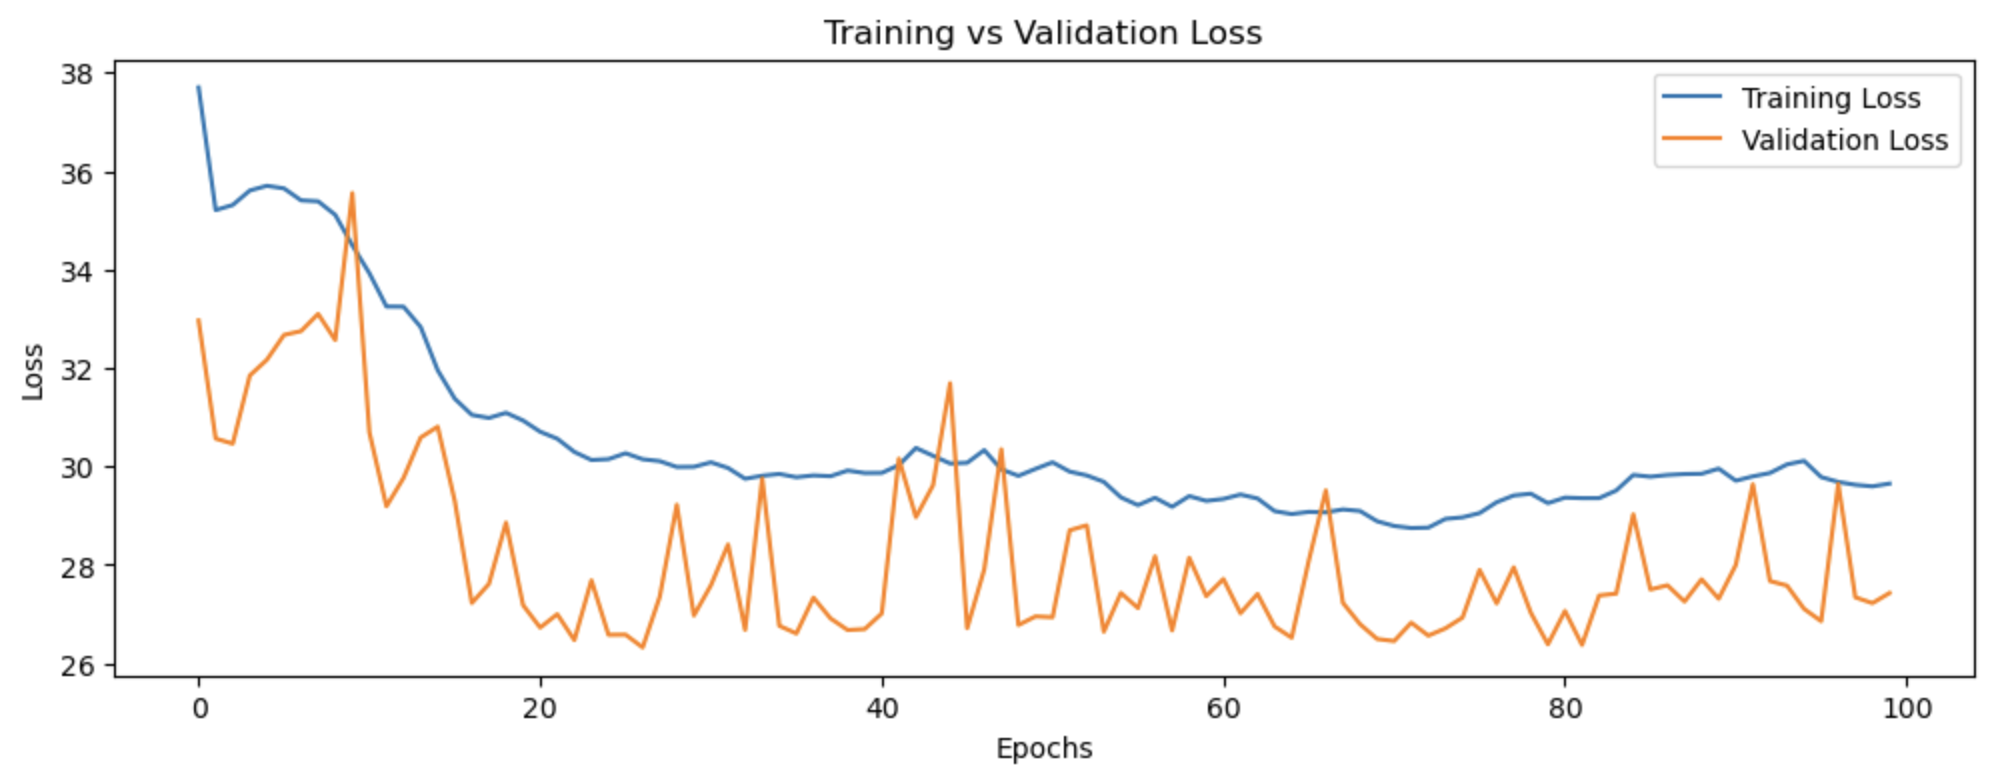

In [6]:
# training curve 1
Image(filename='training_curves/ann/final1.png')

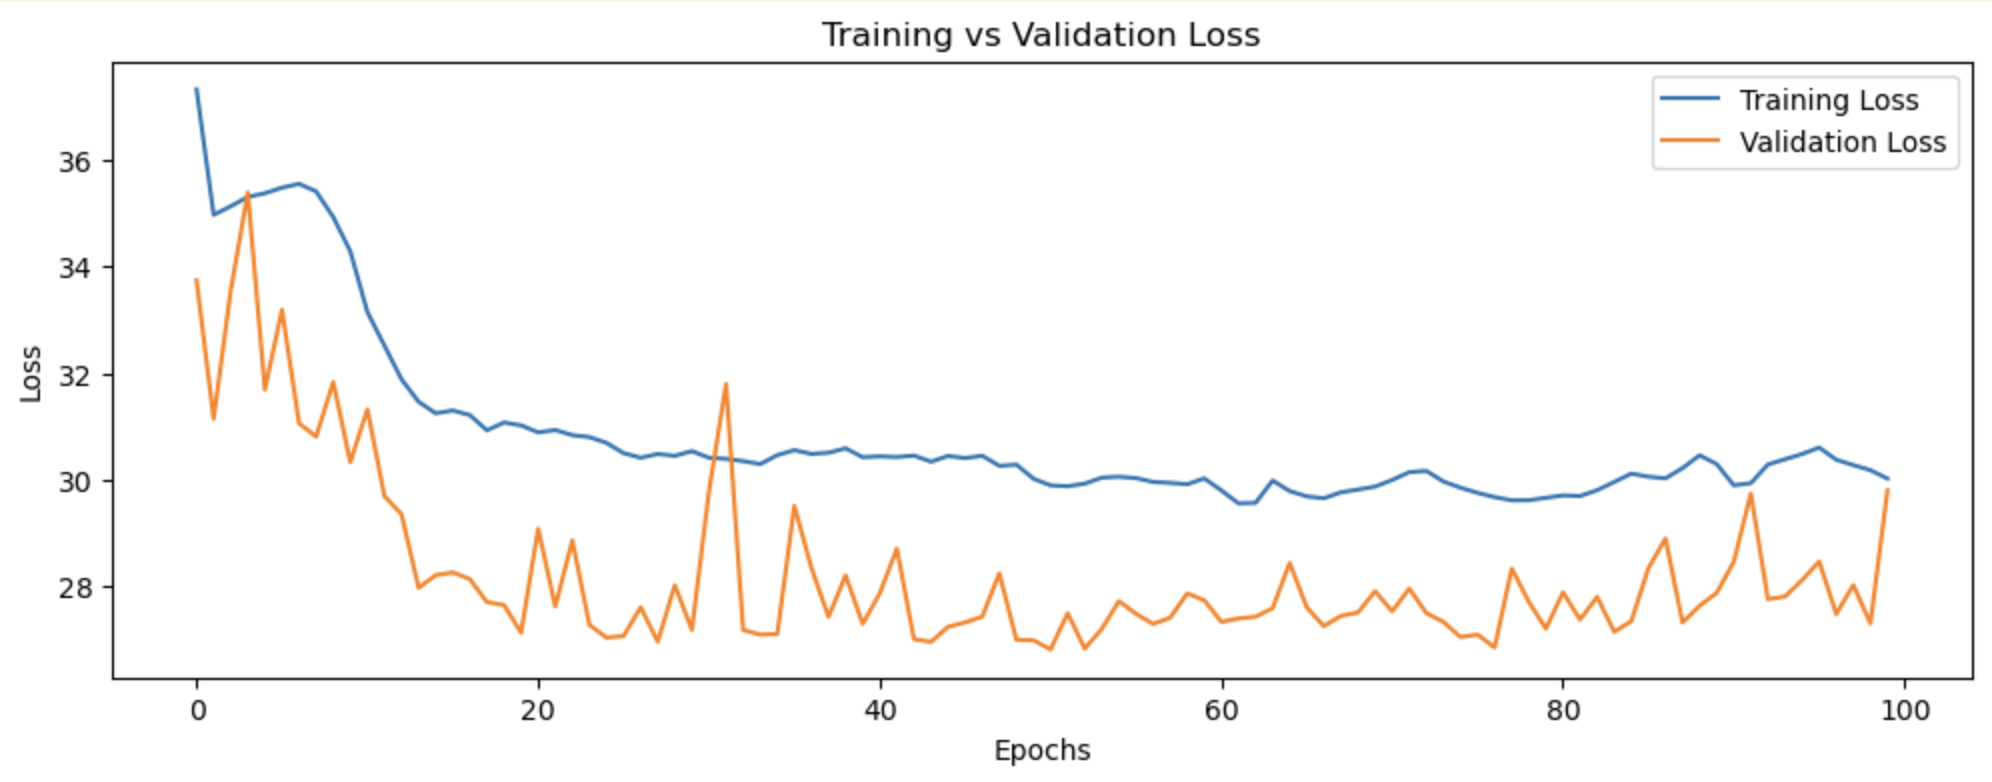

In [7]:
# training curve 2
Image(filename='training_curves/ann/final2.png')

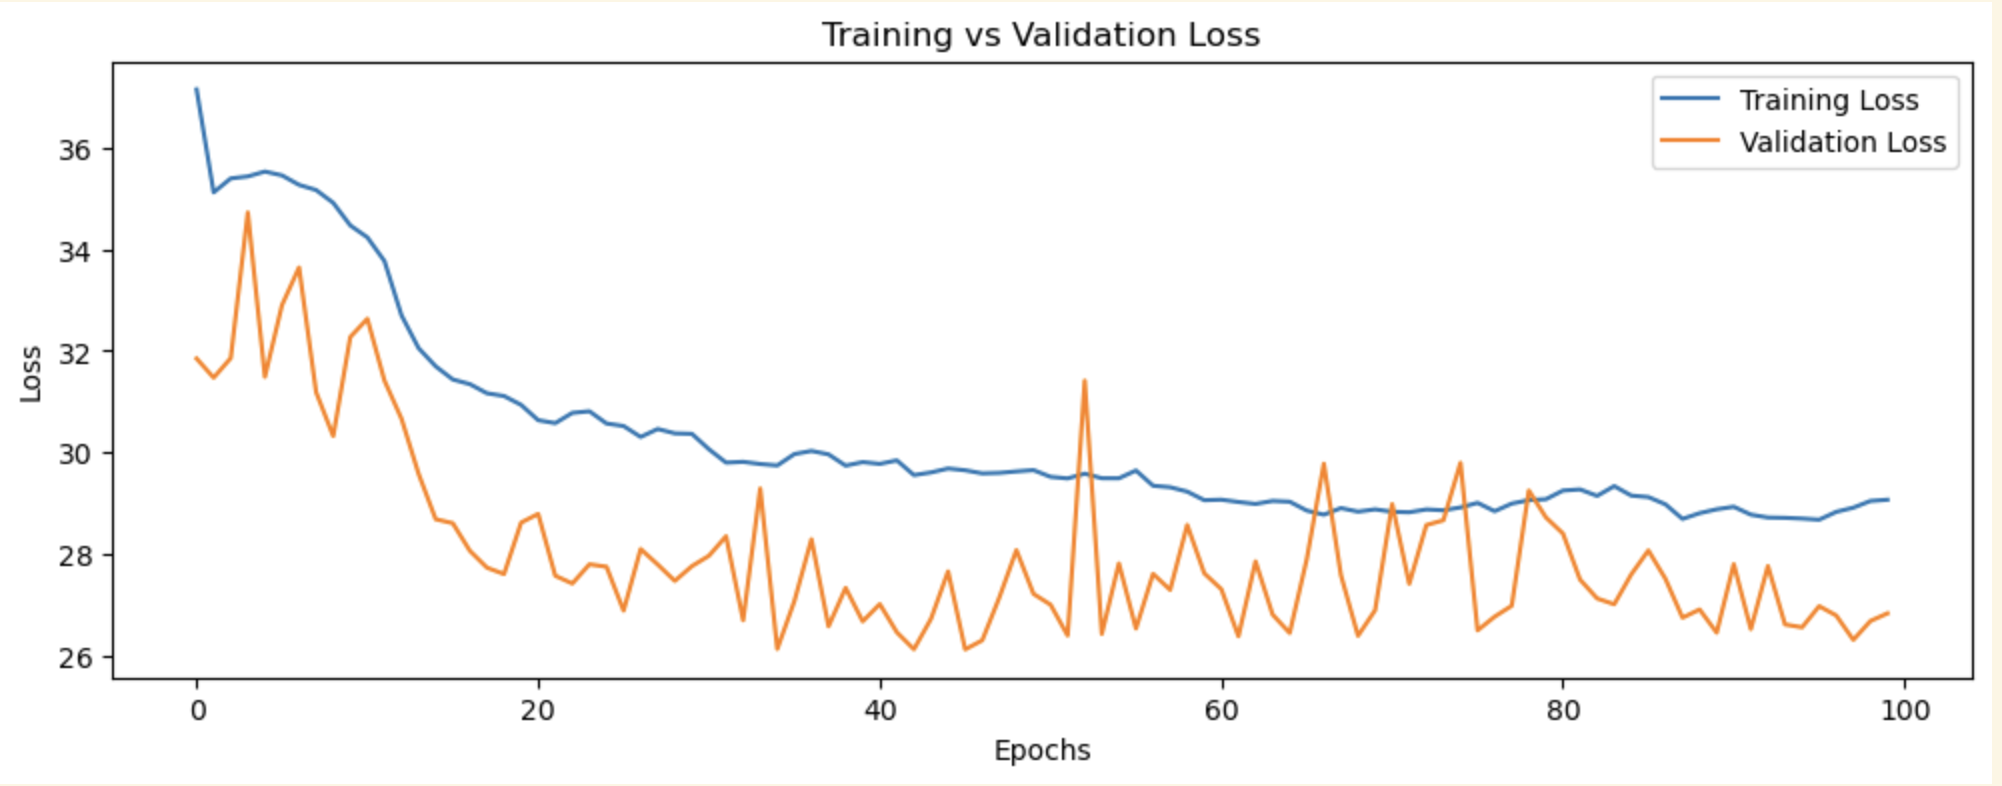

In [8]:
# training curve 3
Image(filename='training_curves/ann/final3.png')

Save model (kernel keeps crashing after training)

In [ ]:
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model1, file)

Load trained model from save file

In [20]:
with open('trained_model.pkl', 'rb') as file:
    model1_trained = pickle.load(file)

In [ ]:
ani5_energies.shape

### Run test set with trained model

In [17]:
test_model1 = Trainer(model=model1_trained, optimizer_type="Adam", learning_rate=1e-3, epoch=100, batch_size=25)
model1_results = test_model1.evaluate(ani5_reps, ani5_energies)

/Users/olukoredeogundele/miniconda3/envs/chem277b/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/olukoredeogundele/miniconda3/envs/chem277b/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE for test model is: 63.34255599975586


### RMSE for ANN is 63.34255599975586

### Next we try the ResNet

I added another layer to the resnet (giving it 4 hidden layers total) because I thought the impact of the residual would be better seen with more hidden layers.

In [19]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        # 768 inputs to 128 node hidden layer
        self.hidden_layer1 = torch.nn.Linear(1000, 128)
        # 128 nodes to 128 nodes
        self.hidden_layer2 = torch.nn.Linear(128, 128)
        # 128 nodes to 128 nodes
        self.hidden_layer3 = torch.nn.Linear(128, 128)
        # 128 nodes to 64 nodes
        self.hidden_layer4 = torch.nn.Linear(128, 64)
        # 64 nodes to 1 output node
        self.output_layer = torch.nn.Linear(64, 1)
        # activation function
        self.activation = F.relu
        # trying dropout to prevent overfitting
        self.dropout = nn.Dropout(p=0.2)

        self.init_weights()

    # Initialize weights from a normal distribution and biases to zero
    # I am not sure this is the right way to do it!
    def init_weights(self):
        for layer in [self.hidden_layer1, self.hidden_layer2, self.hidden_layer3, self.hidden_layer4, self.output_layer]:
            nn.init.normal_(layer.weight, mean=0, std=0.01)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x0):
        x1 = self.activation(self.dropout(self.hidden_layer1(x0)))
         # define residual as output of second layer
        res = x1
        x2 = self.activation(self.dropout(self.hidden_layer2(x1)))
        x3 = self.activation(self.dropout(self.hidden_layer3(x2)))
        # add residual to output from 4th layer
        x3 = x3 + res
        x4 = self.activation(self.dropout(self.hidden_layer4(x3)))
        # don't activate output layer
        x5 = self.output_layer(x4)
        
        return x5.float()

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/m8/skfw9g2x4_g4pq5cv80_g24w0000gn/T/ipykernel_2727/2601278617.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype= torch.float)
/var/folders/m8/skfw9g2x4_g4pq5cv80_g24w0000gn/T/ipykernel_2727/2601278617.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.int64)
  1%|          | 1/100 [00:43<1:12:34, 43.98s/it]

Epoch 1/100 - Loss: 1473.008 - Acc: 0.000
              Val_loss: 937.254 - Val_acc: 0.000


 11%|█         | 11/100 [07:45<1:02:30, 42.14s/it]

Epoch 11/100 - Loss: 1051.175 - Acc: 0.000
              Val_loss: 767.253 - Val_acc: 0.000


 21%|██        | 21/100 [14:34<52:26, 39.83s/it]  

Epoch 21/100 - Loss: 952.575 - Acc: 0.000
              Val_loss: 751.444 - Val_acc: 0.000


 31%|███       | 31/100 [21:21<45:16, 39.37s/it]

Epoch 31/100 - Loss: 904.430 - Acc: 0.000
              Val_loss: 722.991 - Val_acc: 0.000


 41%|████      | 41/100 [27:48<38:02, 38.68s/it]

Epoch 41/100 - Loss: 890.114 - Acc: 0.000
              Val_loss: 743.756 - Val_acc: 0.000


 51%|█████     | 51/100 [34:18<31:49, 38.96s/it]

Epoch 51/100 - Loss: 869.937 - Acc: 0.000
              Val_loss: 768.170 - Val_acc: 0.000


 61%|██████    | 61/100 [40:47<25:20, 38.99s/it]

Epoch 61/100 - Loss: 937.636 - Acc: 0.000
              Val_loss: 831.968 - Val_acc: 0.000


 71%|███████   | 71/100 [47:29<19:05, 39.50s/it]

Epoch 71/100 - Loss: 897.326 - Acc: 0.000
              Val_loss: 778.496 - Val_acc: 0.000


 81%|████████  | 81/100 [55:32<15:23, 48.58s/it]

Epoch 81/100 - Loss: 856.219 - Acc: 0.000
              Val_loss: 752.130 - Val_acc: 0.000


 91%|█████████ | 91/100 [1:03:44<07:23, 49.31s/it]

Epoch 91/100 - Loss: 877.561 - Acc: 0.000
              Val_loss: 773.551 - Val_acc: 0.000


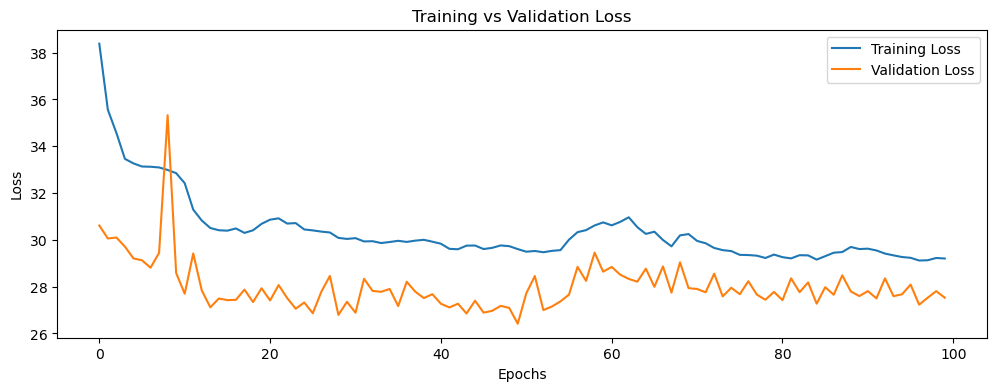

  1%|          | 1/100 [00:47<1:17:59, 47.27s/it]

Epoch 1/100 - Loss: 1508.315 - Acc: 0.000
              Val_loss: 989.875 - Val_acc: 0.000


 11%|█         | 11/100 [08:48<1:11:40, 48.32s/it]

Epoch 11/100 - Loss: 1002.390 - Acc: 0.000
              Val_loss: 782.330 - Val_acc: 0.000


 21%|██        | 21/100 [17:00<1:04:58, 49.35s/it]

Epoch 21/100 - Loss: 908.127 - Acc: 0.000
              Val_loss: 714.885 - Val_acc: 0.000


 31%|███       | 31/100 [25:15<57:36, 50.10s/it]  

Epoch 31/100 - Loss: 897.306 - Acc: 0.000
              Val_loss: 744.548 - Val_acc: 0.000


 41%|████      | 41/100 [33:14<46:02, 46.83s/it]

Epoch 41/100 - Loss: 872.978 - Acc: 0.000
              Val_loss: 722.986 - Val_acc: 0.000


 51%|█████     | 51/100 [40:42<36:44, 44.99s/it]

Epoch 51/100 - Loss: 874.948 - Acc: 0.000
              Val_loss: 793.623 - Val_acc: 0.000


 61%|██████    | 61/100 [48:12<29:10, 44.88s/it]

Epoch 61/100 - Loss: 850.026 - Acc: 0.000
              Val_loss: 753.324 - Val_acc: 0.000


 71%|███████   | 71/100 [55:39<21:42, 44.90s/it]

Epoch 71/100 - Loss: 841.656 - Acc: 0.000
              Val_loss: 736.184 - Val_acc: 0.000


 81%|████████  | 81/100 [1:03:07<13:57, 44.06s/it]

Epoch 81/100 - Loss: 838.802 - Acc: 0.000
              Val_loss: 796.789 - Val_acc: 0.000


 91%|█████████ | 91/100 [1:10:07<06:16, 41.88s/it]

Epoch 91/100 - Loss: 833.860 - Acc: 0.000
              Val_loss: 779.774 - Val_acc: 0.000


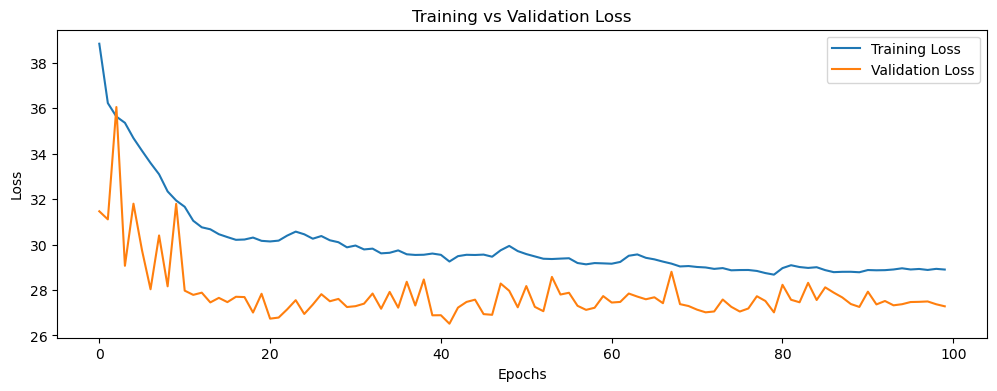

  1%|          | 1/100 [00:43<1:11:14, 43.18s/it]

Epoch 1/100 - Loss: 1492.464 - Acc: 0.000
              Val_loss: 1034.701 - Val_acc: 0.000


 11%|█         | 11/100 [07:34<1:00:56, 41.08s/it]

Epoch 11/100 - Loss: 957.512 - Acc: 0.000
              Val_loss: 807.962 - Val_acc: 0.000


 21%|██        | 21/100 [14:27<54:24, 41.32s/it]  

Epoch 21/100 - Loss: 933.884 - Acc: 0.000
              Val_loss: 751.258 - Val_acc: 0.000


 31%|███       | 31/100 [21:13<46:39, 40.58s/it]

Epoch 31/100 - Loss: 965.978 - Acc: 0.000
              Val_loss: 787.477 - Val_acc: 0.000


 41%|████      | 41/100 [28:00<40:06, 40.79s/it]

Epoch 41/100 - Loss: 894.097 - Acc: 0.000
              Val_loss: 871.830 - Val_acc: 0.000


 51%|█████     | 51/100 [34:47<33:17, 40.76s/it]

Epoch 51/100 - Loss: 885.150 - Acc: 0.000
              Val_loss: 818.049 - Val_acc: 0.000


 61%|██████    | 61/100 [41:33<26:22, 40.58s/it]

Epoch 61/100 - Loss: 865.870 - Acc: 0.000
              Val_loss: 757.236 - Val_acc: 0.000


 71%|███████   | 71/100 [48:27<19:37, 40.60s/it]

Epoch 71/100 - Loss: 835.863 - Acc: 0.000
              Val_loss: 747.796 - Val_acc: 0.000


 81%|████████  | 81/100 [55:11<12:47, 40.38s/it]

Epoch 81/100 - Loss: 840.171 - Acc: 0.000
              Val_loss: 761.411 - Val_acc: 0.000


 91%|█████████ | 91/100 [1:01:54<06:03, 40.37s/it]

Epoch 91/100 - Loss: 837.029 - Acc: 0.000
              Val_loss: 755.022 - Val_acc: 0.000


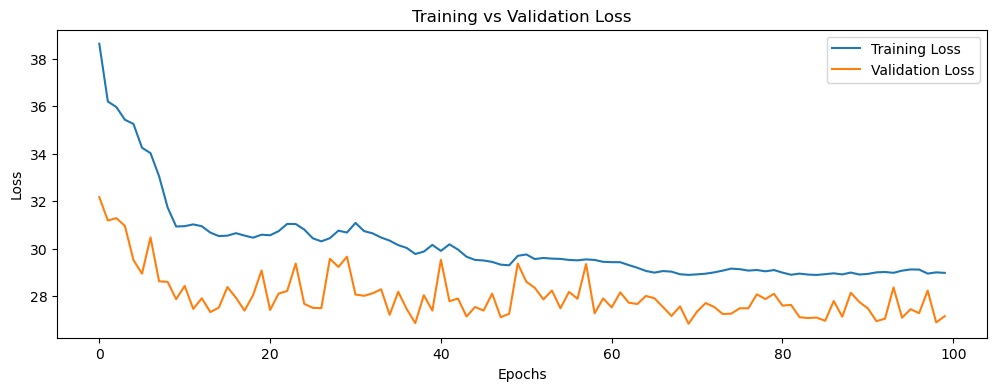

In [19]:
kf = KFold(3, shuffle=True, random_state=49)

for idx, (train_index, val_index) in enumerate(kf.split(mbtr_reps)):
    X_train_fold, X_val_fold = training_reps[train_index], training_reps[val_index]
    y_train_fold, y_val_fold = training_energies[train_index], training_energies[val_index]
    # convert tensor types to float
    test_molecules = torch.FloatTensor(test_molecules)
    val_molecules = torch.FloatTensor(val_molecules)
    test_energies = torch.FloatTensor(test_energies).view(-1, 1)
    val_energies = torch.FloatTensor(val_energies).view(-1, 1)

    model2 = RNN()
    model2.fc4 = nn.Linear(64, 1)
    train_model2 = Trainer(model= model2, optimizer_type= "Adam", learning_rate= 1e-3, epoch= 100, batch_size= 25)
    model2_results = train_model2.train(test_molecules, test_energies, val_molecules, val_energies, l2=True)

### Run test set with trained RNN

In [20]:
# save the trained RNN to a file
with open('trained_rnn.pkl', 'wb') as file:
    pickle.dump(model2, file)

In [21]:
# Load the trained RNN from pkl file
with open('trained_rnn.pkl', 'rb') as file:
    rnn_trained = pickle.load(file)

In [22]:
test_rnn = Trainer(model = rnn_trained, optimizer_type = "Adam", learning_rate = 1e-3, epoch = 100, batch_size = 25)
rnn_results = test_rnn.evaluate(ani5_reps, ani5_energies)

/Users/olukoredeogundele/miniconda3/envs/chem277b/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE for test model is: 64.1415786743164


/Users/olukoredeogundele/miniconda3/envs/chem277b/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### RMSE for RNN is 64.1415786743164
After getting high RMSEs (and warning messages) for both, I went back and checked the shapes for ani5 representations and energies. I found that the array of representations had one more axis than the array of energies.

In [24]:
ani5_energies.shape

(1813151,)

In [9]:
ani5_reps.shape

(1795139, 1000)

When I tried to flatten with different methods like flatten, ravel, or reshape(-1), I got one axis but with the wrong dimensions; I believe the axese were being multiplied instead of stacked and I'm not sure why. I tried to resolve this but was not able to in time.

In [25]:
flat_array = ani5_reps_array.ravel()

print(flat_array.shape)

(1795139000,)
